In [1]:
# Essentials
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pdb as pdb
import pickle
# Tools
from IPython.display import clear_output
import copy
import sys
import pandas as pd
# Specialized packages
from casadi import *
from casadi.tools import *
import control
import time as time
import os.path
from scipy.linalg import solve_discrete_are, inv, eig, block_diag 
from sklearn import linear_model
from sklearn.utils import assert_all_finite
import scipy.signal as signal

# For Plotting
from matplotlib.animation import FuncAnimation, ImageMagickFileWriter
from cycler import cycler
import time as time
# Custom packages
import do_mpc



# Customizing Matplotlib:
mpl.rcParams['font.size'] = 15
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['axes.unicode_minus'] = 'true'
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['xtick.labelsize'] = 'large'
mpl.rcParams['ytick.labelsize'] = 'large'
mpl.rcParams['axes.labelpad'] = 6
mpl.rcParams['pdf.fonttype'] = 42


# Create Model

In [2]:
dt=1 #Time discretization = 1 hour
n1=2 #Rooms in direction 1
n2=2 #Rooms in direction 

In [3]:
A=np.array([[0.8511,0.0541,0.0707],
           [0.1293,0.8635,0.0055],
           [0.0989,0.0003,0.7541]])
B=np.array([[0.0035,0.0003,0.0002]]).T
E_j=1e-3*np.array([[22.217,1.7912,42.212],
             [1.5376,0.6944,2.9214],
             [103.18,0.1032,196.04]])
F_j=0.1


In [4]:
#Set up do-mpc model
def make_model(n1,n2):
    nr=n1*n2
    nx=n1*n2*3 #3 Temperatures per room
    nu=2*nr #Heating Rate and Cooling Rate
    nd=2+nr #Ext temperaure, solar radiation, internal gains
    idx=np.arange(0,n1*n2).reshape(n1,n2)
    model_type = 'discrete'
    model = do_mpc.model.Model(model_type)

    # Introduce new states, inputs and other variables to the model:
    T_r = model.set_variable(var_type='_x', var_name='T_r', shape=(nr,1))
    T_w_int = model.set_variable(var_type='_x', var_name='T_w_int', shape=(nr,1))
    T_w_ext = model.set_variable(var_type='_x', var_name='T_w_ext', shape=(nr,1))

    u_heat = model.set_variable(var_type='_u', var_name='u_heat',shape=(nr,1))
    u_cool=  model.set_variable(var_type='_u', var_name='u_cool',shape=(nr,1))

    T_ext=model.set_variable('_tvp', 'T_ext')
    s_r=model.set_variable('_tvp', 's_r')
    in_g=model.set_variable('_tvp', 'in_g',shape=(nr,1))

    # Set right-hand-side of ODE for all introduced states (_x).
    # Names are inherited from the state definition.
    rhs_T_r=[]
    rhs_T_w_int=[]
    rhs_T_w_ext=[]
    for i in range(n1):
        for j in range(n2):
            idx_r=idx[i,j]
            x=vertcat(T_r[idx_r],T_w_int[idx_r],T_w_ext[idx_r])
            d=vertcat(T_ext,s_r,in_g[idx_r])
            rhs=A@x+B@u_heat[idx_r]-B@u_cool[idx_r]+E_j@d
            if i==0:
                rhs[0]+=0
            else:
                rhs[0]+=F_j*(T_r[idx[i-1,j]]-T_r[idx_r])
            if i>=n1-1:
                rhs[0]+=0
            else:
                rhs[0]+=F_j*(T_r[idx[i+1,j]]-T_r[idx_r])
            if j==0:
                rhs[0]+=0
            else:
                rhs[0]+=F_j*(T_r[idx[i,j-1]]-T_r[idx_r])
            if j>=n2-1:
                rhs[0]+=0
            else:
                rhs[0]+=F_j*(T_r[idx[i,j+1]]-T_r[idx_r])

            rhs_T_r.append(rhs[0])
            rhs_T_w_int.append(rhs[1])
            rhs_T_w_ext.append(rhs[2])


    model.set_rhs('T_r',vertcat(*rhs_T_r))
    model.set_rhs('T_w_int',vertcat(*rhs_T_w_int))
    model.set_rhs('T_w_ext',vertcat(*rhs_T_w_ext))

    # Setup model:
    model.setup()
    return nr,nx,nu,nd,model


In [5]:
nr,nx,nu,nd,model=make_model(n1,n2)

In [6]:
# state constraints
lb_x = -inf*np.ones((nx,1))
lb_x[0]=21
lb_x[1]=16
lb_x[2]=18
lb_x[3]=23
ub_x = np.ones((nx,1))*inf
ub_x[0]=23
ub_x[1]=18
ub_x[2]=20
ub_x[3]=25
# input constraints
lb_u = 0*np.ones((nu,1))
ub_u = 1000*np.ones((nu,1))

# Creating the Simulator and uncertainties

In [7]:
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step = dt)


To simulate the predictions of the uncertain parameters, following template needs to be specified

In [8]:
p_template = simulator.get_tvp_template()

In [9]:
int_gains_max=6
int_gains_min=2
T_env_var=1
sr_unc=0.25
in_g_unc=0.3

Load the measurements of the Bochum weather station. Data starting in January 2008.

In [10]:
with open('exttemp_and_solrad_2008.pkl', 'rb') as f:
    data = pickle.load(f)

In [11]:
data.keys()

dict_keys(['date', 'T', 'sr'])

p_fun_0 describes the "known" uncertainties, i.e. the forecast. The internal gains are assumed to be 6 during workhours, else 2.

In [12]:
def p_fun_0(t_now):
    p_template['T_ext'] = data['T'][t_now//dt]
    p_template['s_r'] = data['sr'][t_now//dt]
    if 9<=t_now%24<=17:
        p_template['in_g'] = int_gains_max
    else:
        p_template['in_g']=int_gains_min
    return p_template

p_fun_max describes the maximum realization of the uncertainties. The internal gains only vary during workhours.

In [13]:
def p_fun_max(t_now):
    p_template=p_fun_0(t_now//dt)
    p_template['T_ext'] += T_env_var
    p_template['s_r'] *= 1+sr_unc
    if 9<=t_now%24<=17:
        p_template['in_g']*=1+in_g_unc
    return p_template

p_fun_min describes the minimum realization of the uncertainties.

In [14]:
def p_fun_min(t_now):
    p_template=p_fun_0(t_now//dt)
    p_template['T_ext'] -=T_env_var
    p_template['s_r'] *= 1-sr_unc
    if 9<=t_now%24<=17:
        p_template['in_g']*=1-in_g_unc
    return p_template

p_fun_var describes a uniformly distributed randomly time varying realization of the uncertain parameters.

In [15]:
def p_fun_var(t):
    np.random.seed(t//dt)
    p_template=p_fun_0(t//dt)
    for keys in p_template.keys():
        if keys!='default':
            if keys=='in_g':
                if 9<=t%24<=17:
                    for l in range(p_template[keys].shape[0]):
                        p_template[keys,l]*=(1+in_g_unc*np.random.uniform(-1,1))
            elif keys=='T_ext':
                p_template[keys]+=T_env_var*np.random.uniform(-1,1)
            elif keys=='s_r':
                p_template[keys]*=(1+sr_unc*np.random.uniform(-1,1))
                p_template[keys]=np.max([0,p_template[keys]])
    return p_template

Test the simulator

In [18]:
simulator.set_tvp_fun(p_fun_var)
simulator.setup()

In [19]:
simulator.reset_history()
# Initial Conditions
x_0 = 20*np.ones((nx,1))
for i in range(nx):
    if lb_x[i]<=x_0[i] and x_0[i]<=ub_x[i]:
        1
    else:
        x_0[i::nr]=lb_x[i]
x_0[-nr:]=10
simulator.x0=x_0
u0=np.zeros((nu,1))
u0[0:nu//2]=250
for i in range(120):
    x0=simulator.make_step(u0)

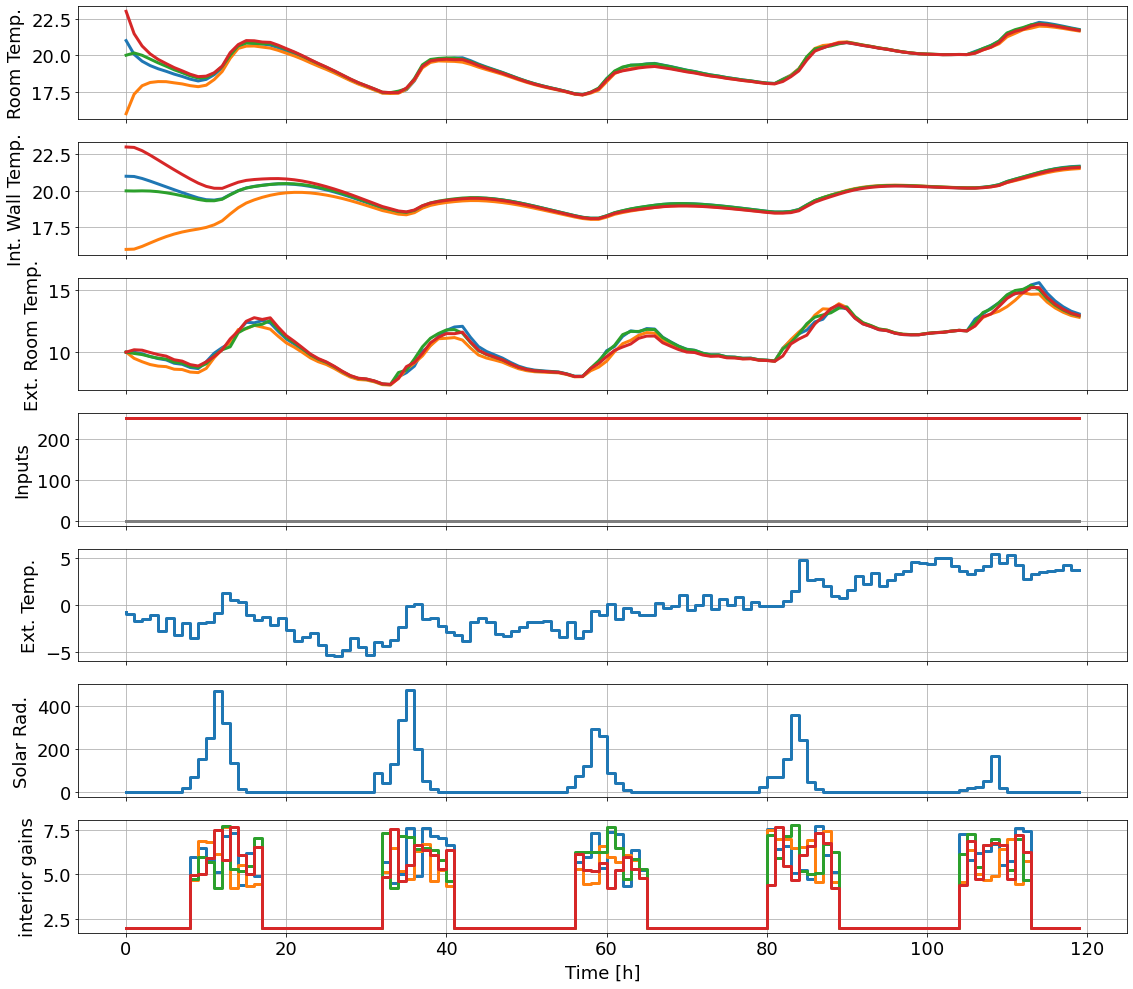

In [20]:
fig, ax=plt.subplots(7,1, sharex=True,figsize=(16,14))
ax[0].plot(simulator.data['_time'],simulator.data['_x','T_r'])
ax[1].plot(simulator.data['_time'],simulator.data['_x','T_w_int'])
ax[2].plot(simulator.data['_time'],simulator.data['_x','T_w_ext'])
ax[3].plot(simulator.data['_time'],simulator.data['_u'])
ax[4].step(simulator.data['_time'],simulator.data['_tvp','T_ext'])
ax[5].step(simulator.data['_time'],simulator.data['_tvp','s_r'])
ax[6].step(simulator.data['_time'],simulator.data['_tvp','in_g'])
ax[0].set_ylabel('Room Temp.')
ax[1].set_ylabel('Int. Wall Temp.')
ax[2].set_ylabel('Ext. Room Temp.')
ax[3].set_ylabel('Inputs')
ax[4].set_ylabel('Ext. Temp.')
ax[5].set_ylabel('Solar Rad.')
ax[6].set_ylabel('interior gains')
ax[6].set_xlabel('Time [h]')
fig.tight_layout()

# General Parameters for all MPC approaches

In [21]:
N = 12

In [22]:
x=SX.sym('x',nx,1)
u=SX.sym('x',nu,1)
p=SX.sym('p',nd,1)
system=Function('system',[model.x,model.u,model.tvp],[model._rhs])

In [23]:
u_b=SX.sym('u_b',nu) # Was implemented, if the change of inputs should be penalized as well
# stage cost
#stage_cost = 1/10*(u-u_b).T@R@(u-u_b)+(u-0).T@R@(u-0)
stage_cost = sum1(u)
stage_cost_fcn = Function('stage_cost',[x,u,u_b],[stage_cost])

# terminal cost
terminal_cost = 0
terminal_cost_fcn = Function('terminal_cost',[x],[terminal_cost])

## Nominal MPC

In [24]:
opt_x = struct_symSX([
    entry('x', shape=nx, repeat=[N+1]),
    entry('u', shape=nu, repeat=[N])
])
opt_p=struct_symSX([
    entry('p',shape=nd, repeat=[N])
])

In [25]:
lb_opt_x = opt_x(0)
ub_opt_x = opt_x(0)

In [26]:
lb_opt_x['x'] = lb_x
ub_opt_x['x'] = ub_x

lb_opt_x['u'] = lb_u
ub_opt_x['u'] = ub_u

In [27]:
J = 0
g = []    # constraint expression g
lb_g = []  # lower bound for constraint expression g
ub_g = []  # upper bound for constraint expression g

In [28]:
x_init = SX.sym('x_init', nx)
u_in=SX.sym('u_in', nu)
x0 = opt_x['x', 0]

g.append(x0-x_init)
lb_g.append(np.zeros((nx,1)))
ub_g.append(np.zeros((nx,1)))
# 01

for i in range(N):
    # objective
    if i>0:
        J += stage_cost_fcn(opt_x['x',i], opt_x['u',i], opt_x['u',i-1])
    else:
        J += stage_cost_fcn(opt_x['x',i], opt_x['u',i], u_in)
    # System equations
    x_next = system(opt_x['x',i], opt_x['u',i],opt_p['p',i])
    
    g.append(x_next - opt_x['x', i+1])
    lb_g.append(np.zeros((nx,1)))
    ub_g.append(np.zeros((nx,1)))
    # 04


# Terminal cost
J += terminal_cost_fcn(opt_x['x', N])
# 05

# Concatenate all constraints
g = vertcat(*g)
lb_g = vertcat(*lb_g)
ub_g = vertcat(*ub_g)

prob = {'f':J,'x':vertcat(opt_x),'g':g, 'p':vertcat(x_init,u_in,vertcat(opt_p))}
mpc_solver = nlpsol('solver','ipopt',prob)

In [29]:
# Define the initial state
x_0 = 20*np.ones((nx,1))
for i in range(nx):
    if lb_x[i]<=x_0[i] and x_0[i]<=ub_x[i]:
        1
    else:
        x_0[i::nr]=lb_x[i]
x_0[-nr:]=10
# Initialize result lists for states and inputs
res_x_mpc = [x_0]
res_u_mpc = []
u0=np.zeros((nu,1))
# Set number of iterations
N_sim = 50

Vary the tvp_function for the different uncertainty realizations:

 - p_fun_var gives timevarying uniformly random values between the bounds, which are defined as:
 - p_fun_max gives the upper bound at time (t)
 - p_fun_min gives the lower bound at time (t)

In [31]:
simulator.set_tvp_fun(p_fun_max)
simulator.reset_history()
simulator.x0=x_0

In [32]:
opt_p_k=opt_p(0)
clc_MPC=np.zeros((N_sim,1))
cv_MPC=np.zeros((N_sim,1))
tic=time.time()
for i in range(N_sim):
    print(i)
    # Get weather forecast
    for k in range(N):
        opt_p_k['p',k]=vertsplit(p_fun_0(k*dt+i*dt))
    # solve optimization problem
    # Warmstart the optimizer by passing the previous solution as an initial guess
    if i>0:
        mpc_res = mpc_solver(p=vertcat(x_0,u_k,vertcat(opt_p_k)), x0=opt_x_k, lbg=lb_g, ubg=ub_g, lbx = lb_opt_x, ubx = ub_opt_x)
    else:
        mpc_res = mpc_solver(p=vertcat(x_0,u0,vertcat(opt_p_k)), lbg=lb_g, ubg=ub_g, lbx = lb_opt_x, ubx = ub_opt_x)

    # Extract the control input
    opt_x_k = opt_x(mpc_res['x'])
    u_k = opt_x_k['u',0]
    # Calculate Closed Loop Cost
    if i>0:
        clc_MPC[i]=clc_MPC[i-1]+stage_cost_fcn(x_0,u_k,res_u_mpc[-1])
    else:
        clc_MPC[i]=stage_cost_fcn(x_0,u_k,u0)
    # simulate the system
    x_next = simulator.make_step(u_k)
    # Calculate Constraint Violations
    cv_MPC[i]=np.sum([np.max([lb_x[l]-x_0[l],0]) for l in range(nx)])+np.sum([np.max([x_0[l]-ub_x[l],0]) for l in range(nx)])

    # Update the initial state
    x_0 = x_next

    # Store the results
    res_x_mpc.append(x_next)
    res_u_mpc.append(u_k)
    # 05
toc_MPC=time.time()-tic
# Make an array from the list of arrays:
res_x_mpc = np.concatenate(res_x_mpc,axis=1)
res_u_mpc = np.concatenate(res_u_mpc, axis=1)

0

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      972
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      252
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      148
                     variables with only upper bounds:        0
Total number of eq

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        14
       nlp_g  |        0 (       0)        0 (       0)        14
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        15
  nlp_hess_l  |        0 (       0)        0 (       0)        13
   nlp_jac_g  |        0 (       0)        0 (       0)        15
       total  |  13.00ms ( 13.00ms)  13.00ms ( 13.00ms)         1
9
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      972
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      252
                     variables with only lower bounds:        0
      

  17r1.3826910e+004 2.54e-001 9.86e+002  -0.6 6.98e+002    -  4.40e-002 2.28e-002f  1
  18r1.3894655e+004 2.54e-001 9.69e+002  -0.6 7.35e+002    -  4.60e-002 2.28e-002f  1
  19r1.3923109e+004 2.54e-001 9.59e+002  -0.6 7.65e+002    -  1.12e-002 9.98e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r1.4037718e+004 2.54e-001 9.28e+002  -0.6 7.60e+002    -  1.05e-001 4.36e-002f  1
  21r1.4060093e+004 2.54e-001 9.22e+002  -0.6 5.90e+002    -  6.05e-002 1.04e-002f  1
  22r1.4071284e+004 2.54e-001 9.21e+002  -0.6 5.94e+002    -  1.54e-001 8.18e-003f  1
  23r1.4137139e+004 2.54e-001 8.74e+002  -0.6 4.96e+002    -  4.08e-003 5.02e-002f  1
  24r1.4169982e+004 2.54e-001 8.48e+002  -0.6 1.30e+002    -  7.95e-002 2.74e-002f  1
  25r1.4240070e+004 2.54e-001 8.00e+002  -0.6 1.19e+002    -  7.10e-002 5.59e-002f  1
  26r1.4245088e+004 2.54e-001 7.38e+002  -0.6 1.88e+001    -  8.71e-001 3.43e-002f  1
  27r1.4554557e+004 2.55e-001 7.86e+001  -0.6 5.76e+001    

Overall NLP error.......:  2.5126609907229492e-009   2.5126609907229492e-009


Number of objective function evaluations             = 16
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 16
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 16
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 15
Total CPU secs in IPOPT (w/o function evaluations)   =      0.013
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        16
       nlp_g  |        0 (       0)        0 (       0)        16
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        17
  nlp_hess_l  |        0

Number of equality constraint evaluations            = 40
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 37
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 34
Total CPU secs in IPOPT (w/o function evaluations)   =      0.031
Total CPU secs in NLP function evaluations           =      0.002

EXIT: Converged to a point of local infeasibility. Problem may be infeasible.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        40
       nlp_g  |   2.00ms ( 50.00us)   2.00ms ( 50.00us)        40
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        13
  nlp_hess_l  |        0 (       0)        0 (       0)        32
   nlp_jac_g  |        0 (       0)        0 (       0)        38
       total  |  55.00ms ( 55.00ms)  55

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      972
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      252
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      148
                     variables with only upper bounds:        0
Total number of equality constraints.................:      156
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.4210910e+004 8.38e-001 1.00e+000  -1.0 0.00e+000    -  0.00e+00

In [33]:
mpc_data=copy.copy(simulator.data)

Text(0.5, 0, 'time [h]')

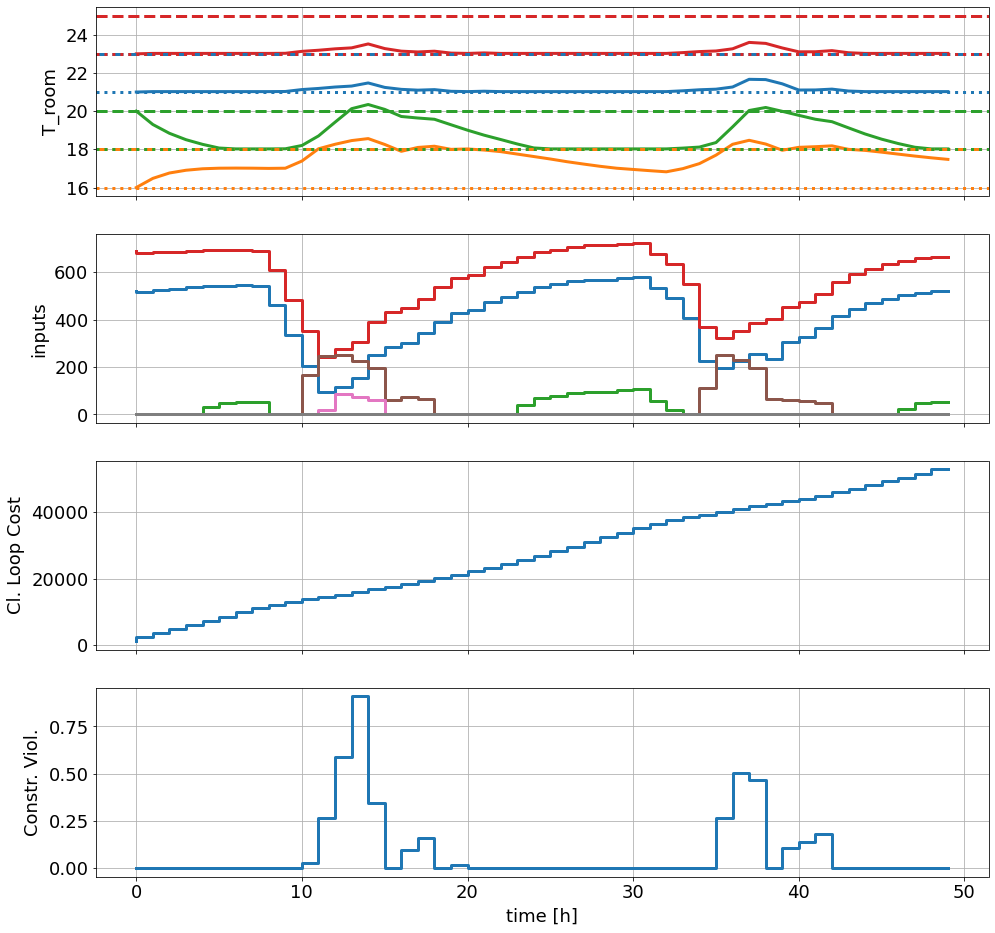

In [34]:
fig, ax = plt.subplots(4,1, sharex=True,figsize=(16,16))

# plot the states
ax[0].plot(mpc_data['_time'],mpc_data['_x','T_r'])
ax[0].axhline(lb_x[0],color='tab:blue',linestyle=':')
ax[0].axhline(ub_x[0],color='tab:blue',linestyle='--')
ax[0].axhline(lb_x[1],color='tab:orange',linestyle=':')
ax[0].axhline(ub_x[1],color='tab:orange',linestyle='--')
ax[0].axhline(lb_x[2],color='tab:green',linestyle=':')
ax[0].axhline(ub_x[2],color='tab:green',linestyle='--')
ax[0].axhline(lb_x[3],color='tab:red',linestyle=':')
ax[0].axhline(ub_x[3],color='tab:red',linestyle='--')
#ax[1].plot(mpc_data['_time'],mpc_data['_x','T_w_int'])
#ax[2].plot(mpc_data['_time'],mpc_data['_x','T_w_ext'])
ax[1].step(mpc_data['_time'],mpc_data['_u'])
#ax[4].step(mpc_data['_time'],mpc_data['_tvp','T_ext'])
#ax[5].step(mpc_data['_time'],mpc_data['_tvp','s_r'])
#ax[6].step(mpc_data['_time'],mpc_data['_tvp','in_g'])
ax[2].step(mpc_data['_time'],clc_MPC)
ax[3].step(mpc_data['_time'],cv_MPC)
# Set labels
ax[0].set_ylabel('T_room')
ax[1].set_ylabel('inputs')
#ax[1].set_ylabel('T_w_int')
#ax[2].set_ylabel('T_w_ext')
#ax[4].set_ylabel('T_ext')
#ax[5].set_ylabel('s_r')
#ax[6].set_ylabel('int. gains')
ax[2].set_ylabel('Cl. Loop Cost')
ax[3].set_ylabel('Constr. Viol.')
ax[-1].set_xlabel('time [h]')

Additional Plot for more information

Text(0.5, 0, 'time [h]')

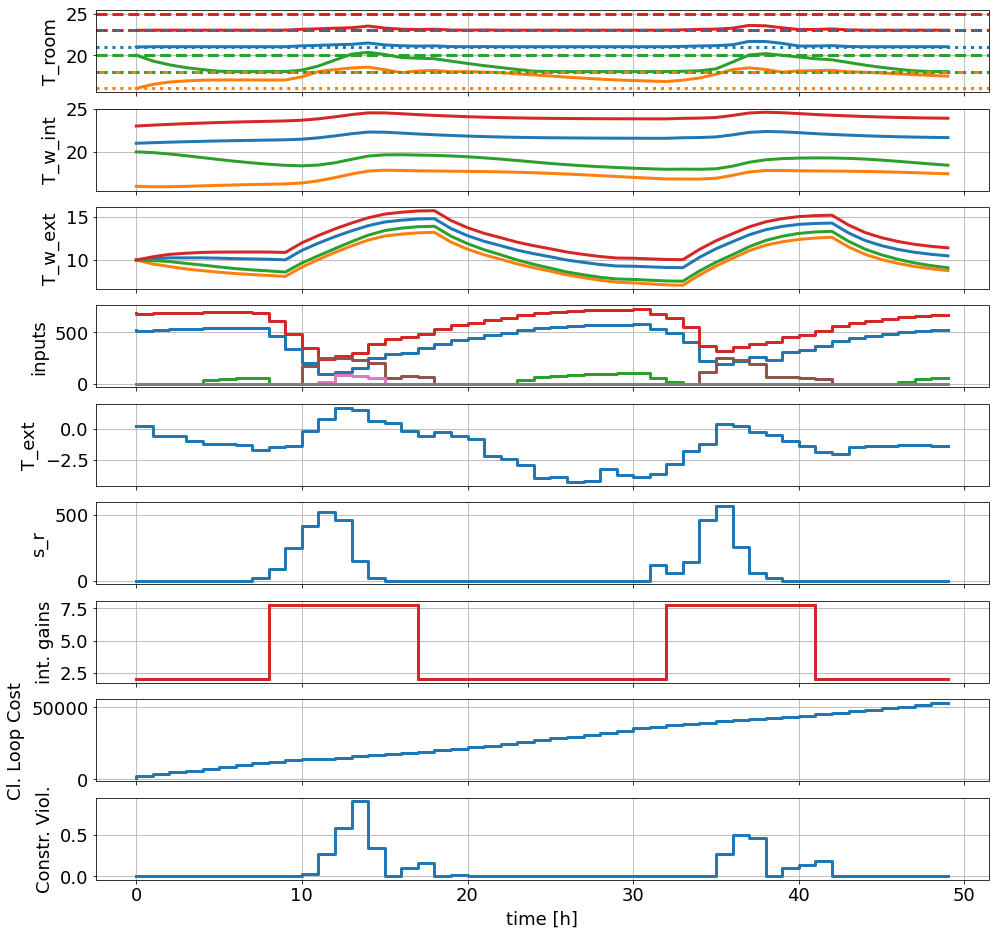

In [36]:
fig, ax = plt.subplots(9,1, sharex=True,figsize=(16,16))

# plot the states
ax[0].plot(mpc_data['_time'],mpc_data['_x','T_r'])
ax[0].axhline(lb_x[0],color='tab:blue',linestyle=':')
ax[0].axhline(ub_x[0],color='tab:blue',linestyle='--')
ax[0].axhline(lb_x[1],color='tab:orange',linestyle=':')
ax[0].axhline(ub_x[1],color='tab:orange',linestyle='--')
ax[0].axhline(lb_x[2],color='tab:green',linestyle=':')
ax[0].axhline(ub_x[2],color='tab:green',linestyle='--')
ax[0].axhline(lb_x[3],color='tab:red',linestyle=':')
ax[0].axhline(ub_x[3],color='tab:red',linestyle='--')
ax[1].plot(mpc_data['_time'],mpc_data['_x','T_w_int'])
ax[2].plot(mpc_data['_time'],mpc_data['_x','T_w_ext'])
ax[3].step(mpc_data['_time'],mpc_data['_u'])
ax[4].step(mpc_data['_time'],mpc_data['_tvp','T_ext'])
ax[5].step(mpc_data['_time'],mpc_data['_tvp','s_r'])
ax[6].step(mpc_data['_time'],mpc_data['_tvp','in_g'])
ax[7].step(mpc_data['_time'],clc_MPC)
ax[8].step(mpc_data['_time'],cv_MPC)
# Set labels
ax[0].set_ylabel('T_room')
ax[3].set_ylabel('inputs')
ax[1].set_ylabel('T_w_int')
ax[2].set_ylabel('T_w_ext')
ax[4].set_ylabel('T_ext')
ax[5].set_ylabel('s_r')
ax[6].set_ylabel('int. gains')
ax[7].set_ylabel('Cl. Loop Cost')
ax[8].set_ylabel('Constr. Viol.')
ax[-1].set_xlabel('time [h]')

# Open-Loop Approach

Pretty much the same structure as nominal MPC, except for now two trajectories

$
\min_{x_{\left[0:N\right]}^+,x_{\left[0:N\right]}^-,u_{\left[0:N-1\right]}} \sum_{k=0}^{N-1} (\ell(x_k^+,u_k)+\ell(x_k^-,u_k))+V_f(x_{N}^+)+V_f(x_{N}^-) \\
\begin{align}
	\text{s.t.}:\quad&x_0^+=x_0, \label{eq:Open_Loop:subeq:IS+}\\
	&x_0^-=x_0, \label{eq:Open_Loop:subeq:IS-}\\
	&x_{k+1}^{+}=f(x_k^{+},u_k,p^{+}),\ \forall k\in\{0,...,N-1\},\label{eq:Open_Loop:subeq:model+}\\
	&x_{k+1}^{-}=f(x_k^{-},u_k,p^{-}),\ \forall k\in\{0,...,N-1\},\label{eq:Open_Loop:subeq:model-} \\
	&x_k^+,x_k^-\in X ,\ \forall k\in\{0,...,N-1\},\label{eq:Open_Loop:subeq:state_constr}\\
	&u_k\in U,\ \forall k\in\{0,...,N-1\},\label{eq:Open_Loop:subeq:input_constr}\\
	&x_N^+,x_N^-\in X_f. \label{eq:Open_Loop:subeq:terminal_set}
\end{align}
$

In [37]:
opt_x = struct_symSX([
    entry('x', shape=nx, repeat=[N+1,2]),
    entry('u', shape=nu, repeat=[N])
])
opt_p=struct_symSX([
    entry('p_min',shape=nd, repeat=[N]),
    entry('p_max',shape=nd, repeat=[N])
])

In [38]:
lb_opt_x = opt_x(0)
ub_opt_x = opt_x(0)

In [39]:
lb_opt_x['x'] = lb_x
ub_opt_x['x'] = ub_x

lb_opt_x['u'] = lb_u
ub_opt_x['u'] = ub_u

In [40]:
J = 0 #Cost function
g = []    # constraint expression g
lb_g = []  # lower bound for constraint expression g
ub_g = []  # upper bound for constraint expression g

In [41]:
x_init = SX.sym('x_init', nx)
u_be=SX.sym('u_be',nu)
x0 = opt_x['x', 0, 0]
g.append(opt_x['x', 0, 0]-opt_x['x', 0,1])
g.append(x0-x_init)
lb_g.append(np.zeros((2*nx,1)))
ub_g.append(np.zeros((2*nx,1)))


for i in range(N):

    # objective
    if i>0:
        J += stage_cost_fcn(opt_x['x',i,0], opt_x['u',i],opt_x['u',i-1])
        J += stage_cost_fcn(opt_x['x',i,1], opt_x['u',i],opt_x['u',i-1])
    else:
        J += stage_cost_fcn(opt_x['x',i,0], opt_x['u',i],u_be)
        J += stage_cost_fcn(opt_x['x',i,1], opt_x['u',i],u_be)


    # equality constraints (system equation)
    x_next_plus = system(opt_x['x',i,0], opt_x['u',i],opt_p['p_max',i])
    x_next_minus = system(opt_x['x',i,1], opt_x['u',i],opt_p['p_min',i])
    g.append(x_next_plus - opt_x['x', i+1,0])
    g.append(x_next_minus - opt_x['x', i+1,1])
    lb_g.append(np.zeros((2*nx,1)))
    ub_g.append(np.zeros((2*nx,1)))




J += terminal_cost_fcn(opt_x['x', N,0])
J += terminal_cost_fcn(opt_x['x', N,1])

g = vertcat(*g)
lb_g = vertcat(*lb_g)
ub_g = vertcat(*ub_g)

prob = {'f':J,'x':vertcat(opt_x),'g':g, 'p':vertcat(x_init,u_be,opt_p)}
mpc_mon_solver = nlpsol('solver','ipopt',prob)

In [42]:
# Define the initial state
x_0 = 20*np.ones((nx,1))
for i in range(nx):
    if lb_x[i]<=x_0[i] and x_0[i]<=ub_x[i]:
        1
    else:
        x_0[i::nr]=lb_x[i]
x_0[-nr:]=10
# Initialize result lists for states and inputs
res_x_mpc = [x_0]
res_u_mpc = []

# Set number of iterations
N_sim = 50

Vary the tvp_function for the different uncertainty realizations:

 - p_fun_var gives timevarying uniformly random values between the bounds, which are defined as:
 - p_fun_max gives the upper bound at time (t)
 - p_fun_min gives the lower bound at time (t)

In [44]:
simulator.set_tvp_fun(p_fun_var)
simulator.reset_history()
simulator.x0=x_0

In [45]:
opt_p_k=opt_p(0)
for i in range(N_sim):
    print(i)


    
    # Initialize Prediction of external influences
    for k in range(N):
        opt_p_k['p_min',k]=vertcat(p_fun_min(k*dt+i*dt))
        opt_p_k['p_max',k]=vertcat(p_fun_max(k*dt+i*dt))

    # Warmstart the optimizer by passing the previous solution as an initial guess!
    if i>0:
        mpc_res = mpc_mon_solver(p=vertcat(x_0,u_k,opt_p_k), x0=opt_x_k, lbg=lb_g, ubg=ub_g, lbx = lb_opt_x, ubx = ub_opt_x)
    else:
        mpc_res = mpc_mon_solver(p=vertcat(x_0,0*np.ones((nu,1)),opt_p_k), lbg=lb_g, ubg=ub_g, lbx = lb_opt_x, ubx = ub_opt_x)




    # Extract the control input
    opt_x_k = opt_x(mpc_res['x'])
    u_k = opt_x_k['u',0]


    # simulate the system
    x_next = simulator.make_step(u_k)
    # 03
    
    # 04 - Your code here!
    # Update the initial state
    x_0 = x_next
    #p_0=simulator.data['_tvp'][-1,:]

0
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1956
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      408
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      200
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0

  nlp_grad_f  |        0 (       0)        0 (       0)        22
  nlp_hess_l  |        0 (       0)        0 (       0)        52
   nlp_jac_g  |        0 (       0)        0 (       0)        56
       total  |  99.00ms ( 99.00ms)  99.02ms ( 99.02ms)         1
3
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1956
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      408
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      200
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        0
        inequa

  59r3.1648467e+004 3.76e-001 1.52e-007  -1.8 3.95e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r3.1590372e+004 3.81e-001 1.91e-001  -4.1 7.83e+000    -  9.49e-001 8.88e-001f  1
  61r3.1587783e+004 3.81e-001 2.63e+001  -4.1 4.93e-001    -  1.00e+000 5.18e-001f  1
  62r3.1564083e+004 3.81e-001 8.16e-010  -4.1 2.85e+000    -  1.00e+000 1.00e+000f  1
  63r3.1545857e+004 3.80e-001 1.36e-002  -6.1 2.19e+000    -  8.66e-001 9.85e-001f  1
  64r3.1544454e+004 3.80e-001 7.73e-012  -6.1 1.47e-001    -  1.00e+000 1.00e+000f  1
  65r3.1536902e+004 3.79e-001 1.38e-003  -9.0 8.22e-001    -  8.88e-001 9.67e-001f  1

Number of Iterations....: 65

                                   (scaled)                 (unscaled)
Objective...............:  3.1536509263315507e+004   3.1536509263315507e+004
Dual infeasibility......:  2.0000003902453543e+000   2.0000003902453543e+000
Constraint violation....:  3.7903475137269460e-001   3.790347

  59r3.1540616e+004 2.90e-001 1.12e-008  -3.0 5.69e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r3.1504195e+004 2.90e-001 1.66e-002  -6.6 3.56e+000    -  9.39e-001 9.77e-001f  1
  61r3.1502953e+004 2.90e-001 1.84e-001  -6.6 1.28e-001    -  1.00e+000 9.61e-001f  1
  62r3.1496503e+004 2.88e-001 2.50e-012  -6.6 9.33e-001    -  1.00e+000 1.00e+000f  1
  63r3.1494329e+004 2.88e-001 2.24e-004  -9.0 4.91e-001    -  9.91e-001 9.32e-001f  1

Number of Iterations....: 63

                                   (scaled)                 (unscaled)
Objective...............:  3.1494172950920427e+004   3.1494172950920427e+004
Dual infeasibility......:  2.0000150960457512e+000   2.0000150960457512e+000
Constraint violation....:  2.8761202768865601e-001   2.8761202768865601e-001
Complementarity.........:  2.8325251948987283e-008   2.8325251948987283e-008
Overall NLP error.......:  1.0472685707406695e+000   2.0000150960457512e+000




  48r3.1145507e+004 2.74e-001 3.95e-010  -4.4 2.58e-001    -  1.00e+000 1.00e+000f  1
  49r3.1121212e+004 2.77e-001 7.33e-003  -6.6 1.70e+000    -  9.49e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r3.1118772e+004 2.77e-001 2.73e-012  -6.6 1.93e-001    -  1.00e+000 1.00e+000f  1
  51r3.1113859e+004 2.79e-001 5.93e-004  -9.0 6.88e-001    -  9.90e-001 9.93e-001f  1

Number of Iterations....: 51

                                   (scaled)                 (unscaled)
Objective...............:  3.1113389033812437e+004   3.1113389033812437e+004
Dual infeasibility......:  2.0000172069252580e+000   2.0000172069252580e+000
Constraint violation....:  2.7873606564483566e-001   2.7873606564483566e-001
Complementarity.........:  3.4968890657718269e-008   3.4968890657718269e-008
Overall NLP error.......:  9.7379893878240054e-001   2.0000172069252580e+000


Number of objective function evaluations             = 66
Number of objective gradient

   7 3.1139059e+004 1.07e+000 4.13e+005  -1.0 2.16e+002    -  2.35e-001 2.67e-003h  1
   8 3.1139375e+004 1.07e+000 5.82e+006  -1.0 2.15e+002    -  8.26e-003 5.87e-004h  1
   9r3.1139375e+004 1.07e+000 1.00e+003   0.0 0.00e+000    -  0.00e+000 3.81e-007R  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r3.1231507e+004 9.14e-001 1.01e+003   0.0 5.15e+003    -  3.57e-003 2.10e-003f  1
  11 3.1231466e+004 9.14e-001 9.19e+003  -1.0 2.17e+002    -  1.06e-001 1.52e-005h  1
  12r3.1231466e+004 9.14e-001 9.99e+002  -0.0 0.00e+000    -  0.00e+000 2.72e-007R  4
  13r3.1323935e+004 6.92e-001 9.96e+002  -0.0 1.85e+003    -  2.77e-003 4.45e-003f  1
  14 3.1323872e+004 6.92e-001 7.42e+003  -1.0 2.31e+002    -  1.11e-001 2.18e-005h  1
  15r3.1323872e+004 6.92e-001 9.99e+002  -0.2 0.00e+000    -  0.00e+000 4.50e-007R  2
  16r3.1370213e+004 5.22e-001 9.99e+002  -0.2 1.21e+003    -  5.32e-003 4.49e-003f  1
  17 3.1370161e+004 5.22e-001 5.86e+002  -1.0 2.42e+002    

  10 2.9580463e+004 1.07e-014 2.27e-013  -3.8 1.43e-002    -  1.00e+000 1.00e+000f  1
  11 2.9580449e+004 1.07e-014 2.27e-013  -5.7 7.78e-004    -  1.00e+000 1.00e+000f  1
  12 2.9580449e+004 1.07e-014 1.71e-013  -8.6 9.77e-006    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  2.9580448782954289e+004   2.9580448782954289e+004
Dual infeasibility......:  1.7053025658242404e-013   1.7053025658242404e-013
Constraint violation....:  1.0658141036401503e-014   1.0658141036401503e-014
Complementarity.........:  2.5090993647124699e-009   2.5090993647124699e-009
Overall NLP error.......:  2.5090993647124699e-009   2.5090993647124699e-009


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 13
Number of inequality constraint evaluations          = 0
Number of equality con

   6 3.4086538e+004 1.07e-014 2.32e-001  -2.5 7.23e-001    -  1.00e+000 9.78e-001f  1
   7 3.4086353e+004 1.07e-014 1.17e-013  -2.5 1.60e-002    -  1.00e+000 1.00e+000f  1
   8 3.4086096e+004 7.11e-015 1.33e-013  -3.8 1.82e-002    -  1.00e+000 1.00e+000f  1
   9 3.4086081e+004 1.07e-014 1.08e-013  -5.7 9.78e-004    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.4086081e+004 1.07e-014 1.39e-013  -8.6 1.24e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  3.4086081119026763e+004   3.4086081119026763e+004
Dual infeasibility......:  1.3853178578433051e-013   1.3853178578433051e-013
Constraint violation....:  1.0658141036401503e-014   1.0658141036401503e-014
Complementarity.........:  2.5076403367753147e-009   2.5076403367753147e-009
Overall NLP error.......:  2.5076403367753147e-009   2.5076403367753147e-009




  74 3.3241674e+004 1.67e-001 7.55e+009  -1.0 6.14e+001    -  8.22e-001 7.87e-005h  1
  75r3.3241674e+004 1.67e-001 1.00e+003  -0.8 0.00e+000    -  0.00e+000 3.53e-007R  4
  76r3.3257175e+004 1.59e-001 9.97e+002  -0.8 1.48e+003    -  7.68e-003 1.96e-003f  1
  77r3.3397788e+004 1.14e-001 9.88e+002  -0.8 1.43e+003    -  4.46e-003 9.50e-003f  1
  78 3.3397737e+004 1.14e-001 8.57e+003  -1.0 2.06e+002    -  8.57e-002 1.91e-005h  1
  79r3.3397737e+004 1.14e-001 9.99e+002  -0.9 0.00e+000    -  0.00e+000 2.69e-007R  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80r3.3451379e+004 1.25e-001 1.00e+003  -0.9 6.11e+002    -  2.29e-002 4.61e-003f  1
  81r3.3453428e+004 1.25e-001 1.01e+003  -0.9 5.73e+002    -  7.10e-002 2.81e-004f  1
  82r3.3542656e+004 1.45e-001 9.86e+002  -0.9 3.98e+002    -  1.37e-002 2.60e-002f  1
  83r3.3547102e+004 1.74e-001 9.71e+002  -0.9 3.39e+002    -  2.49e-003 1.28e-002f  1
  84r3.3558769e+004 1.84e-001 9.69e+002  -0.9 1.35e+002    

  13 3.2404592e+004 2.61e-001 2.92e+010  -1.0 9.57e+001    -  6.71e-005 4.62e-001f  1
  14 3.2392877e+004 2.62e-001 2.92e+010  -1.0 8.87e+004    -  4.67e-005 9.53e-005f  1
  15 3.2322256e+004 2.66e-001 2.91e+010  -1.0 7.58e+004    -  4.57e-005 4.70e-004f  1
  16 3.2312648e+004 2.66e-001 2.91e+010  -1.0 4.52e+004    -  7.84e-005 3.05e-005f  1
  17 3.2225241e+004 2.71e-001 2.91e+010  -1.0 5.77e+004    -  6.51e-005 2.94e-004f  1
  18 3.2211189e+004 2.77e-001 2.91e+010  -1.0 5.78e+004    -  4.18e-004 4.80e-005f  1
  19 3.2155397e+004 2.99e-001 2.91e+010  -1.0 5.76e+004    -  1.79e-004 1.95e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.2139941e+004 3.06e-001 2.91e+010  -1.0 5.74e+004    -  1.62e-004 5.59e-005f  1
  21 3.2121566e+004 3.14e-001 2.91e+010  -1.0 5.71e+004    -  1.68e-004 6.79e-005f  1
  22 3.1971661e+004 3.79e-001 2.91e+010  -1.0 5.70e+004    -  1.69e-004 5.63e-004f  1
  23 3.1969704e+004 3.80e-001 2.91e+010  -1.0 5.68e+004    

  28r3.1863915e+004 2.97e-001 8.32e+002  -1.0 2.38e+002    -  1.55e-003 1.53e-002f  1
  29r3.1895192e+004 2.99e-001 8.14e+002  -1.0 2.34e+002    -  2.22e-002 2.19e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r3.1921059e+004 3.07e-001 8.08e+002  -1.0 5.22e+002    -  2.30e-003 1.03e-002f  1
  31r3.1939814e+004 3.10e-001 7.98e+002  -1.0 4.30e+002    -  1.58e-002 9.20e-003f  1
  32r3.1962512e+004 3.10e-001 7.81e+002  -1.0 2.02e+002    -  1.93e-002 2.40e-002f  1
  33r3.1978804e+004 3.13e-001 7.68e+002  -1.0 1.70e+002    -  1.69e-002 1.53e-002f  1
  34r3.2004220e+004 3.17e-001 7.58e+002  -1.0 2.07e+002    -  8.96e-003 1.83e-002f  1
  35r3.2020928e+004 3.15e-001 7.42e+002  -1.0 1.30e+002    -  7.14e-001 2.64e-002f  1
  36r3.2067298e+004 2.75e-001 5.13e+002  -1.0 3.94e+001    -  5.13e-001 3.08e-001f  1
  37r3.2185548e+004 1.77e-001 3.95e+001  -1.0 3.12e+001    -  6.71e-001 9.46e-001f  1
  38r3.2264468e+004 1.76e-001 5.02e+000  -1.0 1.73e+001    

  11 3.1532942e+004 1.94e+000 1.66e+014  -1.0 2.94e+002    -  3.46e-001 1.99e-002h  1
  12 3.1533015e+004 1.94e+000 1.65e+014  -1.0 2.85e+002    -  2.06e-002 2.03e-004h  1
  13 3.1532362e+004 2.08e+000 1.65e+014  -1.0 2.56e+004    -  5.01e-008 2.77e-005f  4
  14 3.1532563e+004 2.08e+000 1.65e+014  -1.0 2.85e+002    -  2.94e-002 5.56e-004h  2
  15 3.1532664e+004 2.08e+000 1.65e+014  -1.0 2.85e+002    -  6.50e-001 2.81e-004h  2
  16 3.1532742e+004 2.08e+000 1.65e+014  -1.0 2.57e+002    -  3.94e-002 3.11e-004h  3
  17 3.1532930e+004 2.10e+000 1.65e+014  -1.0 4.78e+002    -  4.71e-004 4.71e-004s 11
  18 3.1532219e+004 2.17e+000 1.65e+014  -1.0 1.97e+002    -  9.67e-004 9.67e-004s 11
  19 3.1534814e+004 2.31e+000 1.65e+014  -1.0 2.92e+002    -  2.56e-003 2.56e-003s 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r3.1534814e+004 2.31e+000 1.00e+003   0.4 0.00e+000    -  0.00e+000 0.00e+000R  1
  21r3.1515254e+004 8.37e-001 1.01e+003   0.4 2.85e+003    

  35r3.1599013e+004 7.32e-001 8.98e+002  -0.2 1.64e+002    -  3.62e-002 1.85e-002f  1
  36r3.1542343e+004 7.20e-001 8.51e+002  -0.2 1.01e+002    -  2.08e-001 5.80e-002f  1
  37r3.1436734e+004 6.85e-001 7.50e+002  -0.2 8.45e+001    -  3.60e-003 1.17e-001f  1
  38r3.1468096e+004 6.78e-001 7.30e+002  -0.2 3.62e+002    -  2.83e-002 2.62e-002f  1
  39r3.1475365e+004 6.75e-001 7.19e+002  -0.2 2.28e+002    -  1.48e-001 1.42e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r3.1476430e+004 6.70e-001 7.48e+002  -0.2 7.53e+001    -  4.45e-001 1.98e-002f  1
  41r3.1475855e+004 5.67e-001 4.95e+002  -0.2 9.28e+001    -  6.41e-001 3.05e-001f  1
  42r3.1500034e+004 4.66e-001 3.88e+002  -0.2 7.68e+001    -  8.15e-001 3.48e-001f  1
  43 3.1492416e+004 4.66e-001 4.83e+000  -1.0 2.55e+002    -  5.56e-003 1.09e-003f  1
  44 3.1490280e+004 4.66e-001 2.09e+002  -1.0 2.95e+002    -  2.12e-002 4.63e-004f  1
  45 3.1490179e+004 4.66e-001 5.93e+004  -1.0 3.00e+002    

   2 3.1950389e+004 1.18e+000 1.43e+001  -1.0 2.81e+002    -  2.60e-002 4.30e-003f  1
   3 3.1869772e+004 1.16e+000 5.04e+001  -1.0 2.58e+002    -  7.98e-002 1.72e-002f  1
   4 3.1827441e+004 1.13e+000 9.09e+001  -1.0 2.08e+002    -  9.88e-002 2.03e-002f  1
   5 3.1782185e+004 1.09e+000 1.72e+002  -1.0 2.29e+002    -  1.86e-001 3.30e-002f  1
   6 3.1760551e+004 1.07e+000 3.13e+002  -1.0 2.54e+002    -  1.53e-001 2.17e-002f  1
   7 3.1750211e+004 1.06e+000 3.34e+002  -1.0 2.42e+002    -  2.96e-002 1.41e-002f  1
   8 3.1748231e+004 1.05e+000 1.62e+004  -1.0 2.40e+002    -  2.19e-001 2.50e-003h  1
   9 3.1747271e+004 1.05e+000 3.69e+006  -1.0 2.44e+002    -  3.10e-001 1.36e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.1747254e+004 1.05e+000 5.37e+009  -1.0 2.45e+002    -  4.49e-002 3.07e-005h  1
  11 3.1421863e+004 7.78e-001 4.37e+009  -1.0 2.34e+002    -  1.86e-001 2.60e-001f  1
  12 3.1290730e+004 6.13e-001 2.27e+009  -1.0 1.72e+002    

  10 3.1808637e+004 1.42e-014 1.35e-013  -8.6 1.19e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  3.1808637033479354e+004   3.1808637033479354e+004
Dual infeasibility......:  1.3519907229055773e-013   1.3519907229055773e-013
Constraint violation....:  1.4210854715202004e-014   1.4210854715202004e-014
Complementarity.........:  2.5071035873553094e-009   2.5071035873553094e-009
Overall NLP error.......:  2.5071035873553094e-009   2.5071035873553094e-009


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPO

As said in the paper, this approach does not lead to feasible solutions.

Text(0.5, 0, 'time [h]')

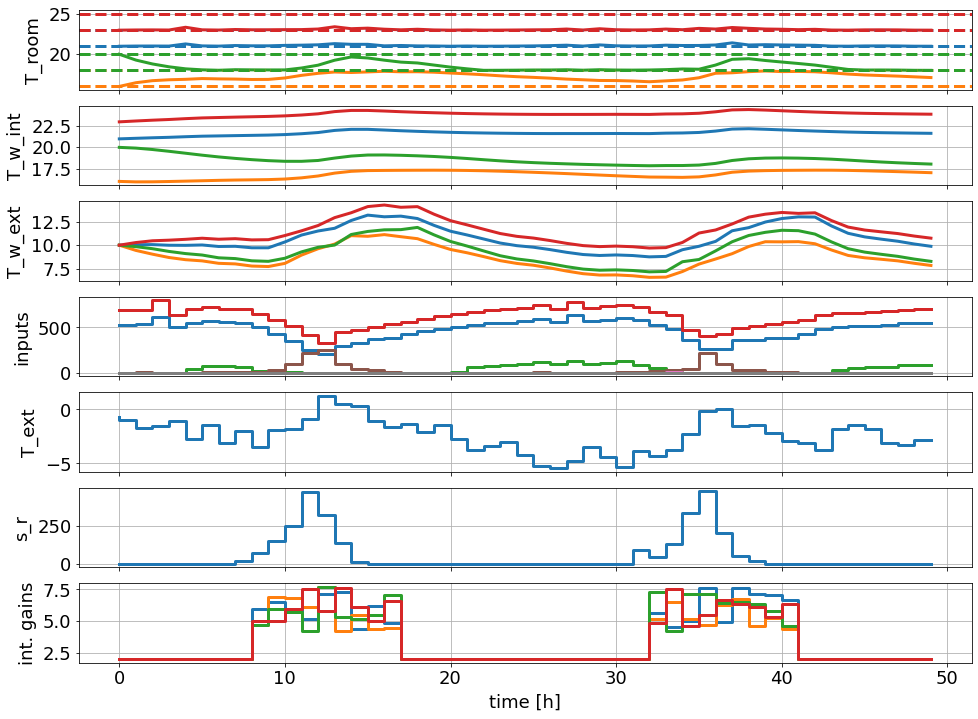

In [47]:
fig, ax = plt.subplots(7,1, sharex=True,figsize=(16,12))

# plot the states
ax[0].plot(simulator.data['_time'],simulator.data['_x','T_r'])
ax[0].axhline(lb_x[0],color='tab:blue',linestyle='--')
ax[0].axhline(ub_x[0],color='tab:blue',linestyle='--')
ax[0].axhline(lb_x[1],color='tab:orange',linestyle='--')
ax[0].axhline(ub_x[1],color='tab:orange',linestyle='--')
ax[0].axhline(lb_x[2],color='tab:green',linestyle='--')
ax[0].axhline(ub_x[2],color='tab:green',linestyle='--')
ax[0].axhline(lb_x[3],color='tab:red',linestyle='--')
ax[0].axhline(ub_x[3],color='tab:red',linestyle='--')
ax[1].plot(simulator.data['_time'],simulator.data['_x','T_w_int'])
ax[2].plot(simulator.data['_time'],simulator.data['_x','T_w_ext'])
ax[3].step(simulator.data['_time'],simulator.data['_u'])
ax[4].step(simulator.data['_time'],simulator.data['_tvp','T_ext'])
ax[5].step(simulator.data['_time'],simulator.data['_tvp','s_r'])
ax[6].step(simulator.data['_time'],simulator.data['_tvp','in_g'])
# Set labels
ax[0].set_ylabel('T_room')
ax[3].set_ylabel('inputs')
ax[1].set_ylabel('T_w_int')
ax[2].set_ylabel('T_w_ext')
ax[4].set_ylabel('T_ext')
ax[5].set_ylabel('s_r')
ax[6].set_ylabel('int. gains')
ax[-1].set_xlabel('time [h]')

# Closed Loop approach

$
\min_{x_{\left[0:N\right]}^{s+},x_{\left[0:N\right]}^{s-},u_{\left[0:N-1\right]}^s,\forall s\in S} \quad \sum_{s=1}^{N_s}  \sum_{k=0}^{N-1} (\ell(x_k^{s+},u_k^s)+\ell(x_k^{s-},u_k^s))+V_f(x_{N}^{s+})+V_f(x_{N}^{s-})\\
\begin{align}
	\text{s.t}:\ &x_0^{s\pm}=x_0,\ \forall s \in S,\\
	&h(x_k^{\left[1:N_s\right]\pm})\preceq 0,\ \forall k\in\{1,...,N-1\}, \label{eq:Closed_Loop:subeq:dividing_RS}\\
	&x_k^{s\pm}\in X,\ \forall k\in\{1,...,N-1\},\ \forall s \in S,\\
	&x_N^{s\pm}\in X_f,\ \forall s \in S, \label{eq:Closed_Loop:subeq:terminal_Constr}\\
	&\begin{split}
	&x_{k+1}^{N_s+}\succeq f(x_k^{s\pm},u_k^s,p^{\pm})\succeq x_{k+1}^{1-},\\
	&\qquad \forall k\in\{0,...,N-1\},\ \forall s \in S,\label{eq:Closed_Loop:subeq:Bounding}
	\end{split}\\
	&u_0^0=u_0^s,\ \forall s \in S. \label{eq:Closed_Loop:subeq:In. Input Constr}
\end{align}
$

In [48]:
N=12

In [51]:
cuts=np.zeros((nx,1))
cuts[0:4]=1
#cuts[-4:]=1
ns=1 #Number of Subregions
for i in range(nx):
    ns*=(cuts[i]+1)
ns=int(ns[0])
print(ns)

16


In [53]:
opt_x_ro = struct_symSX([
    entry('x_min', shape=nx, repeat=[N+1,ns]),
    entry('x_max', shape=nx, repeat=[N+1,ns]),
    entry('delta',shape=(nx),repeat=[N,int(np.max(cuts))]), #This is an ancillary variable, 
    #making the optmization problem easier to formulate 
    #(corresponds to the offsets in each dimension of all subhyperrectangles)
    entry('u', shape=nu, repeat=[N,ns])
])
opt_p=struct_symSX([
    entry('p_min',shape=nd, repeat=[N]),
    entry('p_max',shape=nd, repeat=[N])
])

In [54]:
lb_opt_x_ro = opt_x_ro(0)
ub_opt_x_ro = opt_x_ro(np.inf)

In [55]:
lb_opt_x_ro['x_min'] = lb_x
lb_opt_x_ro['x_max'] = lb_x
ub_opt_x_ro['x_min'] = ub_x
ub_opt_x_ro['x_max'] = ub_x


lb_opt_x_ro['delta',:] = np.zeros((nx,1))
ub_opt_x_ro['delta',:] = np.ones((nx,1))*inf

lb_opt_x_ro['u'] = lb_u
ub_opt_x_ro['u'] = ub_u

In [61]:
J=0
g=[]
lb_g=[]
ub_g=[]
x_init_min=SX.sym('x_init_min',nx)
x_init_max=SX.sym('x_init_max',nx)
u_in = SX.sym('u_in', nu)
g.append(x_init_min-opt_x_ro['x_min',0,0])
g.append(x_init_max-opt_x_ro['x_max',0,-1])
lb_g.append(np.zeros((2*nx,1)))
ub_g.append(np.zeros((2*nx,1)))

for n in range(N):
    
    # This part here is basically describing the implicit offsets in h(x) for the lower left corner (delta) and the 
    # upper right corner (atled)
    atled=SX.sym('atled',nx,int(np.max(cuts)))
    for m in range(nx):
        for h in range(int(np.max(cuts))):
            if cuts[m]<=h:
                g.append(opt_x_ro['delta',n,h][m])            
                lb_g.append(0)
                ub_g.append(0)
            elif cuts[m]-1>h:
                g.append(opt_x_ro['delta',n,h+1][m]-opt_x_ro['delta',n,h][m])
                lb_g.append(0)
                ub_g.append(inf)
            if cuts[m]<=h:
                atled[m,h]=0
            else:
                atled[m,h]=opt_x_ro['x_max',n,-1][m]-opt_x_ro['x_min',n,0][m]-opt_x_ro['delta',n,h][m]
            if cuts[m]>h:   
                g.append(opt_x_ro['x_max',n,-1][m]-opt_x_ro['x_min',n,0][m]-opt_x_ro['delta',n,h][m])
                lb_g.append(0)
                ub_g.append(inf)


    # Still h(x). This part adds the offsets onto each subset
    for s in range(ns):
        count=np.zeros((nx,1)) # Some way of counting through all the sets in each dimension
        remainder=ns
        rest=s
        for l in range(nx):
            if cuts[l]>0:
                remainder/=(cuts[l]+1)
                count[l]=rest//remainder
                rest-=remainder*count[l]
        for k in range(nx):
            if count[k]==0 and count[k]==cuts[k]:
                g.append(opt_x_ro['x_min',n,s][k]-opt_x_ro['x_min',n,0][k])
                lb_g.append(0)
                ub_g.append(0)
                g.append(opt_x_ro['x_max',n,-1][k]-opt_x_ro['x_max',n,s][k])
                lb_g.append(0)
                ub_g.append(0)
            elif count[k]==0 and count[k]!=cuts[k]:
                g.append(opt_x_ro['x_min',n,s][k]-opt_x_ro['x_min',n,0][k])
                lb_g.append(0)
                ub_g.append(0)
                g.append(opt_x_ro['x_max',n,-1][k]-opt_x_ro['x_max',n,s][k]-atled[k,int(count[k])])
                lb_g.append(0)
                ub_g.append(0)
            elif count[k]==cuts[k] and count[k]!=0:
                g.append(opt_x_ro['x_min',n,s][k]-opt_x_ro['x_min',n,0][k]-opt_x_ro['delta',n,int(count[k]-1)][k])
                lb_g.append(0)
                ub_g.append(0)
                g.append(opt_x_ro['x_max',n,-1][k]-opt_x_ro['x_max',n,s][k])
                lb_g.append(0)
                ub_g.append(0)
            else:
                g.append(opt_x_ro['x_min',n,s][k]-opt_x_ro['x_min',n,0][k]-opt_x_ro['delta',n,int(count[k]-1)][k])
                lb_g.append(0)
                ub_g.append(0)
                g.append(opt_x_ro['x_max',n,-1][k]-opt_x_ro['x_max',n,s][k]-atled[k,int(count[k])])
                lb_g.append(0)
                ub_g.append(0)


    for s in range(ns):
        # Propagate the corners of each subset
        x_next_plus = system(opt_x_ro['x_max',n,s], opt_x_ro['u',n,s],opt_p['p_max',n])
        x_next_minus = system(opt_x_ro['x_min',n,s], opt_x_ro['u',n,s],opt_p['p_min',n])
        # Constrain them to lie in the hyperrectangle spanned by opt_x_ro['x_max',n+1,-1] and opt_x_ro['x_min',n+1,0]
        g.append(opt_x_ro['x_max',n+1,-1]-x_next_plus)
        g.append(-opt_x_ro['x_min',n+1,0]+x_next_minus)
        lb_g.append(np.zeros((2*nx,1)))
        ub_g.append(inf*np.ones((2*nx,1)))
    

    
    g.append(opt_x_ro['x_max',n,-1]-opt_x_ro['x_min',n,0])
    lb_g.append(np.zeros((nx,1)))
    ub_g.append(inf*np.ones((nx,1)))


    # Cost function
    for s in range(ns):
        if n>0:
            J += stage_cost_fcn(opt_x_ro['x_min',n,s], opt_x_ro['u',n,s],opt_x_ro['u',n-1,s])
            J += stage_cost_fcn(opt_x_ro['x_max',n,s], opt_x_ro['u',n,s],opt_x_ro['u',n-1,s])
        else:
            J += stage_cost_fcn(opt_x_ro['x_min',n,s], opt_x_ro['u',n,s],u_in)
            J += stage_cost_fcn(opt_x_ro['x_max',n,s], opt_x_ro['u',n,s],u_in)
for s in range(ns):
    J += terminal_cost_fcn(opt_x_ro['x_max', -1,s])
    J += terminal_cost_fcn(opt_x_ro['x_min', -1,s])
    g.append(opt_x_ro['u',0,s]-opt_x_ro['u', 0,0])
    lb_g.append(np.zeros((nu,1)))
    ub_g.append(np.zeros((nu,1)))


g = vertcat(*g)
lb_g = vertcat(*lb_g)
ub_g = vertcat(*ub_g)

prob = {'f':J,'x':vertcat(opt_x_ro),'g':g, 'p':vertcat(x_init_max,x_init_min,u_in,opt_p)}
solver_mx_cut_bon_mpc = nlpsol('solver','ipopt',prob,{'ipopt':{'max_iter':3000}})

In [57]:
# Define the initial state
x_0 = 20*np.ones((nx,1))
for i in range(nx):
    if lb_x[i]<=x_0[i] and x_0[i]<=ub_x[i]:
        1
    else:
        x_0[i::nr]=lb_x[i]
x_0[-nr:]=10
# Initialize result lists for states and inputs
res_x_mpc = [x_0]
res_u_mpc = []

# Set number of iterations
N_sim = 50

Vary the tvp_function for the different uncertainty realizations:

 - p_fun_var gives timevarying uniformly random values between the bounds, which are defined as:
 - p_fun_max gives the upper bound at time (t)
 - p_fun_min gives the lower bound at time (t)

In [59]:
simulator.set_tvp_fun(p_fun_var)
simulator.reset_history()
simulator.x0=x_0

In [60]:
tic=time.time()
opt_p_k=opt_p(0)
clc_HCB=np.zeros((N_sim,1))
cv_HCB=np.zeros((N_sim,1))
solution=[]
for i in range(N_sim):
    print(i)
    # 01 - Your code here!
    # solve optimization problem
    

    for k in range(N):
        opt_p_k['p_min',k]=vertcat(p_fun_min(k*dt+i*dt))
        opt_p_k['p_max',k]=vertcat(p_fun_max(k*dt+i*dt))

    # optionally: Warmstart the optimizer by passing the previous solution as an initial guess!
    if i>0:
        mpc_res = solver_mx_cut_bon_mpc(p=vertcat(x_0,x_0,u_k,opt_p_k), x0=opt_x_k, lbg=lb_g,ubg=ub_g,lbx=lb_opt_x_ro,ubx=ub_opt_x_ro)
    else:
        mpc_res = solver_mx_cut_bon_mpc(p=vertcat(x_0,x_0,0*np.ones((nu,1)),opt_p_k),lbg=lb_g,ubg=ub_g,lbx=lb_opt_x_ro,ubx=ub_opt_x_ro)
    # 01


    # 02 - Your code here!
    # Extract the control input
    opt_x_k = opt_x_ro(mpc_res['x'])
    u_k = opt_x_k['u',0,0]
    # 02
    solution.append(opt_x_k)
    if i>0:
        clc_HCB[i]=clc_HCB[i-1]+stage_cost_fcn(x_0,u_k,res_u_mpc[-1])
    else:
        clc_HCB[i]=stage_cost_fcn(x_0,u_k,u0)
    # calculate Constraint Violation
    cv_HCB[i]=np.sum([np.max([lb_x[l]-x_0[l],0]) for l in range(nx)])+np.sum([np.max([x_0[l]-ub_x[l],0]) for l in range(nx)])

    # 03 - Your code here!
    # simulate the system
    x_next = simulator.make_step(u_k)
    # 03
    
    # 04 - Your code here!
    # Update the initial state
    x_0 = x_next
    #p_0=simulator.data['_tvp'][-1,:]
    res_x_mpc.append(x_next)
    res_u_mpc.append(u_k)
    
toc_HCB=time.time()-tic    

0
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    10152
Number of nonzeros in inequality constraint Jacobian.:    31152
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     6672
                     variables with only lower bounds:      144
                variables with lower and upper bounds:     3200
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4856
Total number of inequality constraints...............:     4800
        inequality constraints with only lower bounds:     4800
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0

  79 1.0633077e+004 1.86e+001 2.76e+003  -1.0 6.69e+002 -18.8 7.47e-003 4.52e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 1.0833708e+004 1.85e+001 2.77e+003  -1.0 6.66e+002 -19.3 5.78e-003 1.02e-003h  1
  81 1.1175754e+004 1.85e+001 2.78e+003  -1.0 6.65e+002 -19.8 6.76e-003 1.74e-003h  1
  82 1.1960876e+004 1.84e+001 2.78e+003  -1.0 6.62e+002 -19.1 7.12e-003 4.01e-003h  1
  83 1.2280703e+004 1.84e+001 2.78e+003  -1.0 6.60e+002 -19.6 2.33e-003 1.57e-003h  1
  84 1.2919787e+004 1.84e+001 2.78e+003  -1.0 6.57e+002 -19.1 6.67e-003 3.15e-003h  1
  85 1.3996529e+004 1.83e+001 2.77e+003  -1.0 6.51e+002 -19.6 6.41e-003 5.14e-003h  1
  86 1.4389434e+004 1.82e+001 2.77e+003  -1.0 6.42e+002 -19.1 6.66e-003 1.82e-003h  1
  87 1.5112651e+004 1.82e+001 2.76e+003  -1.0 6.50e+002 -19.6 6.62e-003 3.28e-003h  1
  88 1.5168639e+004 1.82e+001 2.77e+003  -1.0 6.40e+002 -19.1 6.94e-003 2.56e-004h  1
  89 1.6222979e+004 1.81e+001 2.76e+003  -1.0 6.47e+002 -19

 166 1.8930566e+005 7.95e+000 2.01e+003  -1.0 3.18e+002 -19.1 1.56e-002 4.58e-003h  1
 167 1.9182970e+005 7.81e+000 1.95e+003  -1.0 3.16e+002 -19.6 2.84e-003 1.76e-002h  1
 168 1.9198174e+005 7.80e+000 2.29e+003  -1.0 3.11e+002 -19.1 2.45e-002 1.08e-003h  1
 169 1.9988015e+005 7.36e+000 2.11e+003  -1.0 3.10e+002 -19.6 1.16e-002 5.61e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 2.0015459e+005 7.35e+000 2.11e+003  -1.0 2.93e+002 -19.1 1.20e-002 2.06e-003h  1
 171 2.0151562e+005 7.27e+000 2.08e+003  -1.0 2.93e+002 -19.6 5.23e-003 1.02e-002h  1
 172 2.0234092e+005 7.23e+000 2.08e+003  -1.0 2.90e+002 -19.1 3.46e-002 6.25e-003h  1
 173 2.0723751e+005 6.96e+000 1.99e+003  -1.0 2.87e+002 -19.6 2.62e-003 3.72e-002h  1
 174 2.1266120e+005 6.66e+000 1.90e+003  -1.0 2.77e+002 -19.1 2.19e-002 4.28e-002h  1
 175 2.1290068e+005 6.65e+000 1.90e+003  -1.0 2.69e+002 -19.6 2.35e-002 1.98e-003h  1
 176 2.1550266e+005 6.51e+000 1.86e+003  -1.0 2.68e+002 -19

 258 3.4258375e+005 1.72e-007 1.38e+000  -5.7 4.07e-001 -19.1 9.13e-001 9.16e-001f  1
 259 3.4258294e+005 2.22e-007 1.66e+001  -5.7 1.88e-001 -19.6 1.00e+000 9.74e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 3.4258292e+005 2.28e-007 3.18e-011  -5.7 2.51e+001 -19.1 1.00e+000 1.00e+000f  1
 261 3.4258292e+005 2.28e-007 1.27e+003  -8.6 2.91e-004  -9.3 2.65e-001 2.84e-002h  1
 262 3.4258292e+005 2.28e-007 2.92e+003  -8.6 2.83e-004  -8.8 7.90e-001 2.53e-001f  1
 263 3.4258292e+005 2.25e-007 1.67e+003  -8.6 2.11e-004  -9.3 2.98e-001 4.27e-001f  1
 264 3.4258292e+005 2.20e-007 6.42e+002  -8.6 1.21e-004  -5.3 3.02e-001 6.15e-001f  1
 265 3.4258291e+005 2.17e-007 8.80e+002  -8.6 4.68e-005  -5.7 3.12e-001 5.19e-001f  1
 266 3.4258291e+005 2.14e-007 2.21e+003  -8.6 2.27e-005  -5.3 1.32e-001 7.83e-001f  1
 267 3.4258291e+005 2.13e-007 1.38e+003  -8.6 5.15e-006  -4.9 4.79e-001 5.89e-001f  1
 268 3.4258291e+005 2.13e-007 3.55e+002  -8.6 2.23e-006  -5

 345r3.4258291e+005 1.42e-007 1.00e+003  -6.9 1.90e-003    -  1.31e-003 2.10e-003f  1
 346r3.4258291e+005 1.43e-007 9.97e+002  -6.9 7.30e-004    -  3.07e-003 3.00e-003f  1
 347r3.4258291e+005 1.45e-007 9.88e+002  -6.9 2.32e-004    -  1.72e-002 6.36e-003f  1
 348r3.4258291e+005 1.47e-007 9.67e+002  -6.9 7.95e-005    -  7.69e-002 2.09e-002f  1
 349r3.4258291e+005 1.47e-007 9.32e+002  -6.9 4.32e-005    -  1.08e-001 3.62e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350r3.4258291e+005 1.46e-007 8.34e+002  -6.9 4.53e-005    -  1.63e-001 1.05e-001f  1
 351r3.4258291e+005 1.41e-007 5.82e+002  -6.9 4.67e-005    -  2.06e-001 3.32e-001f  1
 352r3.4258291e+005 1.40e-007 5.45e+002  -6.9 4.03e-005    -  6.73e-002 1.93e-001h  1
 353r3.4258291e+005 1.40e-007 5.34e+002  -6.9 3.67e-005    -  5.63e-003 2.40e-002h  1
 354r3.4258291e+005 1.40e-007 5.26e+002  -6.9 3.64e-005    -  3.69e-001 2.43e-002h  1
 355r3.4258291e+005 1.20e-007 5.19e+002  -6.9 5.05e-005    

  22 3.2774020e+005 8.00e-001 2.36e+003  -1.0 2.30e+002 -10.2 2.00e-002 8.47e-003h  1
  23 3.2865483e+005 7.43e-001 1.08e+003  -1.0 2.42e+002 -10.7 2.24e-003 7.22e-002h  1
  24 3.2873840e+005 7.38e-001 1.40e+003  -1.0 2.00e+002 -11.2 3.16e-002 6.39e-003h  1
  25 3.2923539e+005 7.09e-001 1.34e+003  -1.0 2.01e+002 -11.6 3.90e-002 3.92e-002h  1
  26 3.2949399e+005 6.95e-001 1.91e+003  -1.0 1.83e+002 -12.1 7.64e-002 1.90e-002h  1
  27 3.3011156e+005 6.64e-001 2.24e+003  -1.0 1.85e+002 -12.6 9.52e-002 4.53e-002h  1
  28 3.3036037e+005 6.52e-001 2.41e+003  -1.0 1.84e+002 -13.1 5.34e-002 1.84e-002h  1
  29 3.3050552e+005 6.45e-001 2.46e+003  -1.0 1.59e+002 -13.6 2.41e-002 1.02e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 3.3134675e+005 6.07e-001 2.08e+003  -1.0 1.88e+002 -14.0 6.72e-003 5.91e-002h  1
  31 3.3189589e+005 5.83e-001 2.16e+003  -1.0 1.81e+002 -14.5 8.18e-002 3.95e-002h  1
  32 3.3219535e+005 5.71e-001 2.07e+003  -1.0 1.58e+002 -15

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 3.4898580e+005 1.00e-008 3.92e+001  -9.0 5.37e-008  -4.7 7.85e-001 7.85e-001s 22
 111 3.4898580e+005 1.00e-008 3.61e+001  -9.0 7.61e-008  -5.2 7.72e-002 7.72e-002s 22
 112 3.4898580e+005 1.00e-008 1.54e+002  -9.0 2.91e-007  -4.8 8.06e-001 0.00e+000S 22
 113 3.4898580e+005 1.00e-008 2.78e+000  -9.0 9.62e-008  -5.2 9.02e-001 1.00e+000h  1
 114 3.4898580e+005 1.00e-008 1.15e+002  -9.0 9.69e-008  -4.8 1.00e+000 3.67e-001h  1
 115 3.4898580e+005 1.00e-008 6.48e-012  -9.0 1.15e-007  -5.3 1.00e+000 1.00e+000f  1

Number of Iterations....: 115

                                   (scaled)                 (unscaled)
Objective...............:  3.4898580003889889e+005   3.4898580003889889e+005
Dual infeasibility......:  6.4801497501321137e-012   6.4801497501321137e-012
Constraint violation....:  9.9995274605743487e-009   9.9995274605743487e-009
Complementarity.........:  1.7761648473154375e-009   1.77616484731543

  56 3.5083552e+005 1.49e-001 1.22e+003  -1.0 1.58e+002 -19.6 1.86e-002 3.03e-002h  1
  57 3.5234675e+005 1.06e-001 7.57e+002  -1.0 3.89e+001 -19.1 8.47e-003 2.90e-001h  1
  58 3.5321070e+005 8.10e-002 6.85e+002  -1.0 4.00e+001 -19.6 6.34e-002 2.34e-001h  1
  59 3.5376767e+005 6.50e-002 5.36e+002  -1.0 3.85e+001 -19.1 5.08e-001 1.96e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 3.5469241e+005 3.85e-002 2.87e+002  -1.0 4.40e+001 -19.6 2.58e-001 4.05e-001h  1
  61 3.5486734e+005 3.36e-002 7.36e+002  -1.0 1.55e+001 -19.1 7.63e-001 1.27e-001h  1
  62 3.5513877e+005 2.59e-002 6.08e+002  -1.0 1.95e+001 -19.6 2.80e-001 2.26e-001h  1
  63 3.5540021e+005 1.85e-002 9.40e+002  -1.0 6.41e+000 -19.1 9.90e-001 2.80e-001h  1
  64 3.5568472e+005 1.05e-002 5.42e+002  -1.0 8.11e+000 -19.6 4.26e-001 4.24e-001h  1
  65 3.5606344e+005 1.79e-004 7.31e+002  -1.0 2.47e+000 -19.1 1.86e-001 9.62e-001h  1
  66 3.5607200e+005 9.48e-005 2.27e+003  -1.0 6.65e-001 -19

  18 3.3339123e+005 9.10e-001 4.01e+002  -1.0 5.44e+002  -8.3 3.91e-002 1.21e-002f  1
  19 3.3279186e+005 8.76e-001 5.66e+002  -1.0 5.30e+002  -8.8 7.72e-002 3.72e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.3238395e+005 8.48e-001 8.24e+002  -1.0 4.78e+002  -9.3 9.56e-002 3.26e-002f  1
  21 3.3226979e+005 8.34e-001 1.00e+003  -1.0 3.85e+002  -9.7 6.11e-002 1.67e-002f  1
  22 3.3224733e+005 8.21e-001 9.71e+002  -1.0 2.91e+002 -10.2 1.25e-002 1.56e-002f  1
  23 3.3229209e+005 7.89e-001 8.09e+002  -1.0 2.69e+002 -10.7 1.07e-002 3.87e-002h  1
  24 3.3238817e+005 7.75e-001 9.69e+002  -1.0 2.51e+002 -11.2 5.42e-002 1.74e-002h  1
  25 3.3244370e+005 7.72e-001 1.02e+003  -1.0 2.36e+002 -11.6 1.67e-002 4.64e-003h  1
  26 3.3311005e+005 7.18e-001 6.35e+002  -1.0 2.31e+002 -12.1 1.37e-003 7.02e-002h  1
  27 3.3329418e+005 7.05e-001 1.11e+003  -1.0 2.00e+002 -12.6 1.07e-001 1.69e-002h  1
  28 3.3359415e+005 6.90e-001 1.10e+003  -1.0 1.84e+002 -13

 106 3.5817307e+005 1.00e-008 6.26e-012  -8.6 9.99e-008  -5.1 1.00e+000 1.00e+000h  1
 107 3.5817307e+005 1.00e-008 4.80e+001  -9.0 1.04e-007  -4.7 7.06e-001 9.70e-001h  1
 108 3.5817307e+005 1.00e-008 3.96e+001  -9.0 2.98e-007  -5.2 4.30e-001 6.25e-002f  5
 109 3.5817307e+005 1.00e-008 1.13e-001  -9.0 5.37e-007  -4.8 9.99e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 3.5817307e+005 1.00e-008 1.12e+002  -9.0 1.77e-007  -5.2 3.86e-001 1.00e+000h  1
 111 3.5817307e+005 1.00e-008 4.38e+000  -9.0 3.87e-008  -4.8 9.85e-001 1.00e+000h  1
 112 3.5817307e+005 1.00e-008 9.03e+001  -9.0 7.87e-008  -5.3 9.96e-001 5.00e-001h  2
 113 3.5817307e+005 1.00e-008 9.23e-012  -9.0 5.05e-008  -4.9 1.00e+000 1.00e+000h  1
 114 3.5817307e+005 9.99e-009 3.71e+001  -9.0 2.54e-008  -4.4 7.96e-001 1.00e+000h  1
 115 3.5817307e+005 6.10e-009 2.05e+001  -9.0 5.72e-008  -4.9 7.23e-001 1.00e+000h  1
 116 3.5817307e+005 3.80e-009 8.20e+000  -9.0 3.65e-007  -4

  51 3.4613048e+005 2.94e-001 2.02e+003  -1.0 6.67e+001 -19.1 9.36e-002 2.98e-003h  1
  52 3.4910655e+005 2.27e-001 1.16e+003  -1.0 7.11e+001 -19.6 9.94e-003 2.27e-001h  1
  53 3.4945729e+005 2.19e-001 1.01e+003  -1.0 9.79e+001 -19.1 1.80e-001 3.47e-002h  1
  54 3.5071844e+005 1.91e-001 9.65e+002  -1.0 1.42e+002 -19.6 9.02e-003 1.30e-001h  1
  55 3.5090570e+005 1.87e-001 8.40e+002  -1.0 4.64e+001 -19.1 1.49e-001 2.20e-002h  1
  56 3.5109849e+005 1.82e-001 8.15e+002  -1.0 4.31e+001 -19.6 3.01e-002 2.31e-002h  1
  57 3.5149104e+005 1.73e-001 8.05e+002  -1.0 2.03e+002 -19.1 1.14e-002 4.80e-002h  1
  58 3.5248824e+005 1.51e-001 7.71e+002  -1.0 2.46e+002 -19.6 4.67e-002 1.28e-001h  1
  59 3.5278081e+005 1.45e-001 7.57e+002  -1.0 4.04e+001 -19.1 2.15e-002 4.24e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 3.5286883e+005 1.43e-001 6.94e+002  -1.0 4.30e+001 -19.6 6.89e-002 1.33e-002h  1
  61 3.5304105e+005 1.39e-001 6.56e+002  -1.0 5.57e+001 -19

   8 3.4281343e+005 1.02e+000 1.18e+002  -1.0 6.53e+002  -3.5 1.89e-002 9.39e-003f  1
   9 3.4226030e+005 1.02e+000 1.19e+002  -1.0 6.91e+002  -4.0 3.40e-003 3.05e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.4105798e+005 1.01e+000 1.38e+002  -1.0 7.02e+002  -4.5 1.20e-002 6.79e-003f  1
  11 3.3930167e+005 1.00e+000 1.02e+002  -1.0 7.00e+002  -5.0 1.29e-003 1.07e-002f  1
  12 3.3894143e+005 1.00e+000 1.55e+002  -1.0 6.86e+002  -5.4 1.51e-002 2.40e-003f  1
  13 3.3649033e+005 9.82e-001 1.42e+002  -1.0 6.63e+002  -5.9 1.59e-002 1.77e-002f  1
  14 3.3536503e+005 9.72e-001 1.73e+002  -1.0 5.66e+002  -6.4 1.47e-002 1.03e-002f  1
  15 3.3471276e+005 9.65e-001 1.40e+002  -1.0 5.60e+002  -6.9 3.97e-003 7.70e-003f  1
  16 3.3387182e+005 9.54e-001 1.47e+002  -1.0 5.54e+002  -7.4 1.28e-002 1.16e-002f  1
  17 3.3318327e+005 9.42e-001 1.35e+002  -1.0 5.45e+002  -7.8 1.08e-002 1.25e-002f  1
  18 3.3245291e+005 9.27e-001 1.51e+002  -1.0 5.34e+002  -8

  97 3.5857503e+005 1.00e-008 3.83e+001  -8.6 3.59e-005  -4.6 8.57e-001 1.00e+000f  1
  98 3.5857503e+005 1.00e-008 1.70e+002  -8.6 2.89e-006  -5.1 4.85e-001 1.00e+000h  1
  99 3.5857503e+005 1.00e-008 2.92e+002  -8.6 8.32e-007  -4.7 3.68e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 3.5857503e+005 1.00e-008 4.81e+002  -8.6 1.34e-006  -5.2 1.74e-001 1.00e+000h  1
 101 3.5857503e+005 1.00e-008 6.49e+002  -8.6 1.52e-006  -4.7 1.59e-001 1.00e+000h  1
 102 3.5857503e+005 1.00e-008 5.21e+002  -8.6 2.09e-006  -5.2 1.35e-001 3.05e-005h 16
 103 3.5857503e+005 1.00e-008 6.67e+002  -8.6 2.08e-006  -4.8 1.80e-001 1.00e+000h  1
 104 3.5857503e+005 1.00e-008 6.02e+002  -8.6 8.57e-006  -5.3 6.95e-002 6.57e-003h  4
 105 3.5857503e+005 1.00e-008 4.05e+002  -8.6 3.14e-006  -5.7 2.43e-001 6.25e-002h  5
 106 3.5857503e+005 1.00e-008 6.61e+002  -8.6 4.24e-006  -5.3 4.58e-002 1.00e+000h  1
 107 3.5857503e+005 1.00e-008 7.42e+002  -8.6 3.50e-006  -4

  39 3.3319786e+005 5.92e-001 2.48e+003  -1.0 3.07e+002 -18.3 3.29e-002 2.85e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.3383292e+005 5.71e-001 2.40e+003  -1.0 1.52e+002 -18.8 3.59e-002 3.54e-002h  1
  41 3.3444284e+005 5.52e-001 2.33e+003  -1.0 1.50e+002 -19.3 3.66e-002 3.39e-002h  1
  42 3.3448088e+005 5.51e-001 2.44e+003  -1.0 1.33e+002 -19.8 2.67e-002 1.98e-003h  1
  43 3.3462334e+005 5.47e-001 2.42e+003  -1.0 1.95e+002 -19.1 5.65e-003 7.04e-003h  1
  44 3.3496157e+005 5.37e-001 2.30e+003  -1.0 1.29e+002 -19.6 6.37e-004 1.77e-002h  1
  45 3.3510729e+005 5.33e-001 2.30e+003  -1.0 1.23e+002 -19.1 1.21e-002 7.66e-003h  1
  46 3.3575039e+005 5.15e-001 2.13e+003  -1.0 1.27e+002 -19.6 1.57e-002 3.41e-002h  1
  47 3.3652947e+005 4.93e-001 1.96e+003  -1.0 1.22e+002 -19.1 2.38e-002 4.18e-002h  1
  48 3.3722258e+005 4.75e-001 1.96e+003  -1.0 1.16e+002 -19.6 5.49e-002 3.81e-002h  1
  49 3.3748662e+005 4.68e-001 1.97e+003  -1.0 1.08e+002 -19

   4 3.5356356e+005 1.10e+000 1.95e+001  -1.0 8.78e+001  -1.6 1.28e-002 8.77e-003f  1
   5 3.5110534e+005 1.08e+000 3.78e+001  -1.0 2.07e+002  -2.1 2.84e-002 1.73e-002f  1
   6 3.4830291e+005 1.07e+000 8.09e+001  -1.0 3.63e+002  -2.6 2.77e-002 1.33e-002f  1
   7 3.4326179e+005 1.05e+000 1.12e+002  -1.0 5.18e+002  -3.1 2.96e-002 2.08e-002f  1
   8 3.4111621e+005 1.04e+000 1.35e+002  -1.0 6.19e+002  -3.5 1.50e-002 9.38e-003f  1
   9 3.4002821e+005 1.03e+000 1.71e+002  -1.0 6.57e+002  -4.0 1.31e-002 5.06e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.3816954e+005 1.02e+000 2.32e+002  -1.0 6.70e+002  -4.5 2.22e-002 9.22e-003f  1
  11 3.3643744e+005 1.01e+000 2.23e+002  -1.0 6.71e+002  -5.0 8.49e-003 9.87e-003f  1
  12 3.3546349e+005 1.01e+000 2.77e+002  -1.0 6.57e+002  -5.4 1.64e-002 6.19e-003f  1
  13 3.3238958e+005 9.86e-001 1.71e+002  -1.0 6.23e+002  -5.9 4.29e-003 2.18e-002f  1
  14 3.3171100e+005 9.80e-001 3.14e+002  -1.0 5.35e+002  -6

  93 3.5272575e+005 1.07e-008 9.23e+002  -8.6 1.03e-006  -4.8 2.28e-001 1.00e+000h  1
  94 3.5272575e+005 1.00e-008 1.17e+003  -8.6 3.70e-007  -4.4 2.24e-001 1.00e+000H  1
  95 3.5272575e+005 1.00e-008 1.33e+003  -8.6 3.28e-006  -4.9 8.45e-002 9.98e-001h  1
  96 3.5272575e+005 1.00e-008 1.12e+003  -8.6 2.61e-006  -5.4 1.33e-001 1.56e-002f  7
  97 3.5272575e+005 1.00e-008 1.10e+003  -8.6 2.69e-006  -4.9 5.35e-002 3.81e-001h  1
  98 3.5272575e+005 1.00e-008 6.24e+002  -8.6 3.12e-006  -5.4 1.51e-002 5.08e-001f  1
  99 3.5272575e+005 1.00e-008 3.81e+002  -8.6 8.38e-007  -5.0 4.14e-001 3.51e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 3.5272575e+005 1.00e-008 3.80e+002  -8.6 5.55e-007  -4.6 3.58e-001 1.01e-003f  9
 101 3.5272575e+005 1.00e-008 1.71e+002  -8.6 5.54e-007  -5.0 3.92e-001 8.32e-001h  1
 102 3.5272575e+005 1.00e-008 1.05e+002  -8.6 7.04e-007  -5.5 8.85e-001 4.88e-004f 12
 103 3.5272575e+005 1.00e-008 1.41e+001  -8.6 8.54e-007  -5

  51 3.3124538e+005 3.91e-001 1.21e+003  -1.0 2.59e+002 -19.1 2.81e-002 3.92e-003h  1
  52 3.3202756e+005 3.71e-001 1.09e+003  -1.0 2.86e+002 -19.6 2.43e-002 5.07e-002h  1
  53 3.3239678e+005 3.62e-001 1.06e+003  -1.0 2.64e+002 -19.1 2.24e-002 2.50e-002h  1
  54 3.3295046e+005 3.48e-001 9.57e+002  -1.0 2.75e+002 -19.6 1.05e-002 3.84e-002h  1
  55 3.3296655e+005 3.48e-001 9.94e+002  -1.0 2.94e+002 -19.1 1.92e-002 1.15e-003h  1
  56 3.3340488e+005 3.37e-001 9.05e+002  -1.0 3.01e+002 -19.6 3.05e-003 3.13e-002h  1
  57 3.3379329e+005 3.27e-001 8.42e+002  -1.0 2.87e+002 -19.1 1.05e-002 2.85e-002h  1
  58 3.3387753e+005 3.25e-001 9.07e+002  -1.0 7.45e+001 -19.6 4.02e-002 5.81e-003h  1
  59 3.3412343e+005 3.20e-001 9.40e+002  -1.0 6.28e+001 -19.1 4.21e-002 1.69e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 3.3518210e+005 2.97e-001 9.02e+002  -1.0 6.21e+001 -19.6 9.00e-002 7.32e-002h  1
  61 3.3657532e+005 2.65e-001 6.76e+002  -1.0 6.00e+001 -19

   3 3.4415319e+005 1.10e+000 6.01e+000  -1.0 2.87e+001  -1.1 1.33e-002 2.78e-002f  1
   4 3.4209922e+005 1.07e+000 6.43e+000  -1.0 7.65e+001  -1.6 3.04e-002 2.89e-002f  1
   5 3.3861065e+005 1.04e+000 7.09e+001  -1.0 1.87e+002  -2.1 4.48e-002 2.46e-002f  1
   6 3.3663216e+005 1.03e+000 2.15e+002  -1.0 3.59e+002  -2.6 3.65e-002 9.58e-003f  1
   7 3.3489731e+005 1.03e+000 2.58e+002  -1.0 5.12e+002  -3.1 1.39e-002 7.36e-003f  1
   8 3.2961053e+005 1.01e+000 2.14e+002  -1.0 5.99e+002  -3.5 1.66e-002 2.17e-002f  1
   9 3.2710760e+005 9.94e-001 3.54e+002  -1.0 6.38e+002  -4.0 2.91e-002 1.17e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.2496463e+005 9.82e-001 4.58e+002  -1.0 6.41e+002  -4.5 2.44e-002 1.15e-002f  1
  11 3.2246461e+005 9.67e-001 4.01e+002  -1.0 6.02e+002  -5.0 9.47e-003 1.56e-002f  1
  12 3.2101440e+005 9.57e-001 5.74e+002  -1.0 5.50e+002  -5.4 3.23e-002 1.06e-002f  1
  13 3.1937105e+005 9.41e-001 7.59e+002  -1.0 5.42e+002  -5

  93 3.3926577e+005 1.00e-008 5.37e+001  -8.6 1.78e-006  -5.1 6.32e-001 4.46e-001h  1
  94 3.3926577e+005 2.46e-008 7.18e+001  -8.6 1.25e-003  -5.6 1.48e-001 5.34e-001F  1
  95 3.3926577e+005 1.00e-008 2.53e+002  -8.6 4.82e-007  -5.1 2.97e-001 1.00e+000f  1
  96 3.3926577e+005 1.00e-008 4.72e+002  -8.6 1.09e-006  -4.7 1.27e-001 1.00e+000h  1
  97 3.3926577e+005 1.00e-008 2.74e+002  -8.6 2.92e-007  -5.2 6.39e-001 1.00e+000h  1
  98 3.3926577e+005 1.00e-008 4.83e+002  -8.6 2.11e-007  -4.8 1.36e-001 1.00e+000h  1
  99 3.3926577e+005 1.00e-008 4.84e+002  -8.6 2.78e-007  -5.2 8.57e-002 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 3.3926577e+005 1.00e-008 3.29e+002  -8.6 3.00e-007  -4.8 5.52e-001 1.00e+000h  1
 101 3.3926577e+005 1.00e-008 3.10e+002  -8.6 2.04e-006  -5.3 4.81e-001 1.00e+000h  1
 102 3.3926577e+005 1.00e-008 2.07e-011  -8.6 1.50e-006  -4.9 1.00e+000 1.00e+000h  1
 103 3.3926577e+005 1.00e-008 2.36e+002  -8.6 1.79e-007  -5

  38 3.1473667e+005 2.41e-001 1.85e+003  -1.0 9.44e+001 -17.8 3.04e-002 2.73e-002h  1
  39 3.1524508e+005 2.30e-001 1.77e+003  -1.0 1.26e+002 -18.3 4.81e-002 4.57e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.1617749e+005 2.10e-001 1.52e+003  -1.0 1.90e+002 -18.8 3.86e-002 8.73e-002h  1
  41 3.1622818e+005 2.09e-001 1.56e+003  -1.0 1.59e+002 -19.3 2.92e-002 5.04e-003h  1
  42 3.1647988e+005 2.04e-001 1.58e+003  -1.0 1.18e+002 -19.8 5.77e-002 2.44e-002h  1
  43 3.1660933e+005 2.02e-001 1.55e+003  -1.0 2.02e+002 -19.1 5.15e-003 1.08e-002h  1
  44 3.1708776e+005 1.93e-001 1.41e+003  -1.0 6.93e+001 -19.6 1.90e-003 4.53e-002h  1
  45 3.1714879e+005 1.92e-001 1.45e+003  -1.0 6.70e+001 -19.1 3.53e-002 5.96e-003h  1
  46 3.1772504e+005 1.81e-001 1.49e+003  -1.0 6.60e+001 -19.6 1.26e-001 5.59e-002h  1
  47 3.1871524e+005 1.63e-001 1.32e+003  -1.0 6.24e+001 -19.1 8.65e-002 1.01e-001h  1
  48 3.1878045e+005 1.61e-001 1.35e+003  -1.0 1.17e+002 -19

   3 3.2427886e+005 8.29e-001 4.30e+001  -1.0 2.90e+001  -1.1 2.22e-002 3.16e-002f  1
   4 3.2235043e+005 8.04e-001 1.33e+002  -1.0 8.35e+001  -1.6 6.87e-002 3.00e-002f  1
   5 3.1927299e+005 7.83e-001 2.78e+002  -1.0 2.18e+002  -2.1 5.62e-002 2.59e-002f  1
   6 3.1627350e+005 7.69e-001 2.58e+002  -1.0 3.78e+002  -2.6 1.65e-002 1.85e-002f  1
   7 3.1390924e+005 7.59e-001 2.51e+002  -1.0 5.32e+002  -3.1 1.30e-002 1.34e-002f  1
   8 3.1203790e+005 7.50e-001 3.29e+002  -1.0 6.28e+002  -3.5 2.10e-002 1.13e-002f  1
   9 3.0979251e+005 7.39e-001 3.30e+002  -1.0 6.48e+002  -4.0 1.60e-002 1.52e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.0826546e+005 7.29e-001 4.54e+002  -1.0 5.92e+002  -4.5 2.79e-002 1.25e-002f  1
  11 3.0703791e+005 7.20e-001 3.80e+002  -1.0 5.87e+002  -5.0 4.26e-003 1.27e-002f  1
  12 3.0657367e+005 7.16e-001 5.10e+002  -1.0 5.78e+002  -5.4 2.22e-002 5.70e-003f  1
  13 3.0523605e+005 7.01e-001 6.03e+002  -1.0 5.70e+002  -5

  93 3.2222616e+005 1.00e-008 6.65e+002  -8.6 8.05e-007  -4.9 1.52e-001 2.50e-001h  3
  94 3.2222616e+005 1.00e-008 5.95e+002  -8.6 3.97e-007  -5.4 1.02e-001 3.05e-005h 16
  95 3.2222616e+005 1.00e-008 5.46e+002  -8.6 3.73e-006  -4.9 5.65e-002 3.78e-001h  1
  96 3.2222616e+005 1.00e-008 4.46e+002  -8.6 4.19e-006  -5.4 5.43e-001 1.85e-001f  1
  97 3.2222616e+005 1.00e-008 3.79e+002  -8.6 2.76e-006  -5.0 2.52e-001 1.48e-001f  1
  98 3.2222616e+005 1.00e-008 2.97e+002  -8.6 1.59e-006  -5.5 1.00e+000 2.18e-001f  1
  99 3.2222616e+005 1.00e-008 1.54e+002  -8.6 5.95e-007  -5.0 1.00e+000 4.81e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 3.2222616e+005 1.00e-008 1.52e+002  -8.6 1.01e-007  -5.5 1.00e+000 1.22e-002f  7
 101 3.2222616e+005 1.00e-008 2.86e+000  -8.6 1.06e-007  -5.1 1.00e+000 9.81e-001h  1
 102 3.2222616e+005 1.00e-008 1.41e+002  -8.6 2.99e-007  -5.6 1.00e+000 1.95e-003f 10
 103 3.2222616e+005 1.00e-008 6.15e-012  -8.6 2.92e-007  -5

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 3.1758124e+005 9.98e-009 6.85e+001  -8.6 2.68e-005  -4.7 1.00e+000 7.60e-001f  1
  51 3.1758124e+005 1.00e-008 2.94e+001  -8.6 5.33e-005  -5.2 1.00e+000 8.97e-001f  1
  52 3.1758124e+005 1.00e-008 3.64e+001  -8.6 1.99e-005  -4.8 8.59e-001 1.00e+000f  1
  53 3.1758124e+005 2.17e-008 4.14e+002  -8.6 5.84e-005  -5.3 3.31e-001 1.00e+000H  1
  54 3.1758124e+005 1.00e-008 6.32e+002  -8.6 2.17e-005  -4.8 9.79e-002 1.00e+000h  1
In iteration 54, 1 Slack too small, adjusting variable bound
  55 3.1758124e+005 1.00e-008 4.55e+002  -8.6 6.37e-005  -5.3 2.84e-001 2.94e-001h  1
In iteration 55, 1 Slack too small, adjusting variable bound
  56 3.1758124e+005 1.00e-008 3.91e+002  -8.6 2.41e-005  -4.9 1.37e-001 1.31e-001h  1
In iteration 56, 1 Slack too small, adjusting variable bound
  57 3.1758124e+005 1.00e-008 3.93e+002  -8.6 7.09e-005  -5.4 1.25e-001 3.04e-001h  1
In iteration 57, 1 Slack too small, adjusting va

  38 3.0851368e+005 6.47e-002 7.52e+002  -1.0 1.74e+001 -17.8 1.94e-001 2.65e-003h  1
  39 3.0860095e+005 6.16e-002 7.40e+002  -1.0 1.74e+001 -18.3 5.73e-002 4.68e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.0867621e+005 5.91e-002 1.06e+003  -1.0 1.66e+001 -18.8 1.03e-001 4.05e-002h  1
  41 3.0965089e+005 2.74e-002 5.12e+002  -1.0 1.60e+001 -19.3 1.37e-002 5.36e-001h  1
  42 3.1013352e+005 1.16e-002 6.69e+002  -1.0 7.55e+000 -19.8 1.90e-001 5.76e-001h  1
  43 3.1019797e+005 9.52e-003 2.41e+003  -1.0 3.24e+000 -19.1 7.32e-001 1.81e-001h  1
  44 3.1048778e+005 8.93e-005 2.11e+001  -1.0 2.67e+000 -19.6 9.91e-001 9.91e-001h  1
  45 3.1048996e+005 3.29e-005 1.62e+003  -1.0 1.02e-001 -19.1 1.00e+000 7.41e-001f  1
  46 3.1049068e+005 1.26e-005 1.00e-006  -1.0 7.04e-002 -19.6 1.00e+000 1.00e+000h  1
  47 3.1029565e+005 5.76e-006 1.98e+001  -2.5 3.37e+000 -19.1 4.32e-001 5.55e-001f  1
  48 3.1016869e+005 1.18e-006 1.28e+000  -2.5 1.30e+000 -19

  13 2.9705904e+005 8.36e-001 1.62e+003  -1.0 2.91e+002  -5.9 6.00e-002 1.89e-002f  1
  14 2.9692376e+005 7.89e-001 1.30e+003  -1.0 2.60e+002  -6.4 1.71e-002 5.63e-002f  1
  15 2.9694378e+005 7.69e-001 1.81e+003  -1.0 2.29e+002  -6.9 1.19e-001 2.48e-002h  1
  16 2.9720570e+005 7.42e-001 2.30e+003  -1.0 1.92e+002  -7.4 1.44e-001 3.58e-002h  1
  17 2.9751690e+005 7.20e-001 2.74e+003  -1.0 1.22e+002  -7.8 1.47e-001 2.91e-002h  1
  18 2.9826259e+005 6.72e-001 2.63e+003  -1.0 1.26e+002  -8.3 8.43e-002 6.64e-002h  1
  19 2.9855653e+005 6.55e-001 2.96e+003  -1.0 1.23e+002  -8.8 1.44e-001 2.60e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.0092961e+005 5.18e-001 1.90e+003  -1.0 1.25e+002  -9.3 5.50e-002 2.09e-001h  1
  21 3.0194970e+005 4.61e-001 1.80e+003  -1.0 1.03e+002  -9.7 1.52e-001 1.11e-001h  1
  22 3.0203630e+005 4.56e-001 2.36e+003  -1.0 5.28e+001 -10.2 2.59e-001 8.96e-003h  1
  23 3.0424346e+005 3.55e-001 1.73e+003  -1.0 5.26e+001 -10

  14 3.0418178e+005 3.61e-001 2.01e+003  -1.0 7.47e+001  -6.4 7.46e-002 1.15e-001h  1
  15 3.0516818e+005 3.12e-001 2.05e+003  -1.0 4.76e+001  -6.9 2.23e-001 1.36e-001h  1
  16 3.0606302e+005 2.73e-001 1.99e+003  -1.0 4.28e+001  -7.4 1.93e-001 1.24e-001h  1
  17 3.0720619e+005 2.25e-001 1.52e+003  -1.0 3.80e+001  -7.8 1.23e-001 1.76e-001h  1
  18 3.0730762e+005 2.21e-001 1.87e+003  -1.0 1.73e+001  -8.3 2.08e-001 1.70e-002h  1
  19 3.0879022e+005 1.66e-001 1.61e+003  -1.0 1.72e+001  -8.8 3.79e-001 2.47e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.0972355e+005 1.33e-001 1.17e+003  -1.0 1.98e+001  -9.3 8.71e-002 2.02e-001h  1
  21 3.1086943e+005 9.18e-002 1.15e+003  -1.0 2.14e+001  -9.7 7.03e-001 3.09e-001h  1
  22 3.1154533e+005 6.79e-002 9.35e+002  -1.0 1.16e+001 -10.2 5.78e-001 2.61e-001h  1
  23 3.1272347e+005 2.63e-002 3.84e+002  -1.0 7.45e+000 -10.7 8.03e-001 6.12e-001h  1
  24 3.1344008e+005 1.33e-003 4.19e+001  -1.0 1.86e+000 -11

  38 3.2059492e+005 1.00e-008 4.87e+001  -8.6 3.39e-006  -4.8 6.67e-001 1.00e+000h  1
  39 3.2059492e+005 1.00e-008 2.68e+002  -8.6 9.40e-006  -5.3 2.00e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.2059492e+005 1.00e-008 1.26e+002  -8.6 3.42e-006  -4.9 7.72e-001 1.00e+000h  1
  41 3.2059492e+005 1.00e-008 3.71e+002  -8.6 9.41e-006  -5.3 9.88e-002 1.00e+000h  1
  42 3.2059492e+005 1.00e-008 5.52e+002  -8.6 3.41e-006  -4.9 1.58e-001 1.00e+000h  1
  43 3.2059492e+005 1.00e-008 6.86e+002  -8.6 9.30e-006  -5.4 1.79e-001 1.00e+000h  1
  44 3.2059492e+005 1.24e-008 8.27e+002  -8.6 3.36e-006  -5.0 1.48e-001 1.00e+000h  1
  45 3.2059492e+005 1.40e-008 9.65e+002  -8.6 9.04e-006  -5.4 1.32e-001 1.00e+000h  1
  46 3.2059492e+005 1.21e-008 8.77e+002  -8.6 3.25e-006  -5.0 2.56e-001 8.09e-001h  1
  47 3.2059492e+005 1.21e-008 6.38e+002  -8.6 8.89e-006  -5.5 2.07e-001 9.77e-004f 11
  48 3.2059492e+005 1.00e-008 8.36e+002  -8.6 3.52e-006  -5

  35 3.2536948e+005 1.00e-008 1.77e+002  -8.6 1.81e-004  -5.2 2.15e-001 1.00e+000h  1
  36 3.2536948e+005 1.00e-008 2.35e+002  -8.6 6.75e-005  -4.8 4.97e-001 1.00e+000h  1
  37 3.2536948e+005 1.00e-008 2.90e+002  -8.6 1.99e-004  -5.2 1.67e-001 5.00e-001h  2
  38 3.2536948e+005 1.00e-008 2.79e+002  -8.6 7.48e-005  -4.8 2.67e-001 5.00e-001h  2
  39 3.2536948e+005 1.00e-008 2.66e+002  -8.6 2.21e-004  -5.3 1.49e-001 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.2536948e+005 1.00e-008 3.21e+002  -8.6 8.34e-005  -4.9 4.18e-001 1.00e+000h  1
In iteration 40, 1 Slack too small, adjusting variable bound
  41 3.2536948e+005 1.00e-008 3.39e+002  -8.6 2.45e-004  -5.3 1.43e-001 3.69e-001h  1
  42 3.2536948e+005 1.00e-008 5.58e+002  -8.6 9.22e-005  -4.9 1.05e-001 1.00e+000h  1
  43 3.2536948e+005 1.00e-008 6.86e+002  -8.6 2.70e-004  -5.4 1.86e-001 1.00e+000h  1
  44 3.2536948e+005 1.00e-008 8.44e+002  -8.6 1.00e-004  -5.0 1.31e-001 1.00e+000h  

  39 3.3001866e+005 1.00e-008 1.71e+002  -8.6 4.59e-007  -5.1 8.39e-001 2.76e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.3001866e+005 1.00e-008 7.51e-012  -8.6 2.90e-007  -4.7 1.00e+000 1.00e+000f  1

Number of Iterations....: 40

                                   (scaled)                 (unscaled)
Objective...............:  3.3001865803497366e+005   3.3001865803497366e+005
Dual infeasibility......:  7.5121969526953536e-012   7.5121969526953536e-012
Constraint violation....:  9.9993016092439312e-009   9.9993016092439312e-009
Complementarity.........:  9.7203945467572233e-009   9.7203945467572233e-009
Overall NLP error.......:  9.9993016092439312e-009   9.9993016092439312e-009


Number of objective function evaluations             = 41
Number of objective gradient evaluations             = 41
Number of equality constraint evaluations            = 41
Number of inequality constraint evaluations          = 41
Number of equality constra

  57 3.3846192e+005 1.00e-008 6.28e+001  -8.6 7.43e-007  -4.7 7.36e-001 1.00e+000h  1
  58 3.3846192e+005 1.00e-008 6.40e+001  -8.6 4.69e-007  -5.1 6.86e-001 1.00e+000h  1
  59 3.3846192e+005 1.00e-008 8.23e+001  -8.6 1.51e-006  -4.7 1.00e+000 4.18e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 3.3846192e+005 1.00e-008 1.40e+002  -8.6 8.28e-008  -5.2 1.00e+000 7.81e-003f  8
  61 3.3846192e+005 1.00e-008 5.33e-012  -8.6 3.37e-008  -4.8 1.00e+000 1.00e+000h  1

Number of Iterations....: 61

                                   (scaled)                 (unscaled)
Objective...............:  3.3846192112825933e+005   3.3846192112825933e+005
Dual infeasibility......:  5.3344407686424365e-012   5.3344407686424365e-012
Constraint violation....:  9.9989325357001399e-009   9.9989325357001399e-009
Complementarity.........:  2.7345652787062817e-009   2.7345652787062817e-009
Overall NLP error.......:  9.9989325357001399e-009   9.9989325357001399e-009




  56 3.4727518e+005 1.00e-008 2.09e+001  -8.6 2.80e-007  -5.3 2.15e-001 9.83e-001h  1
  57 3.4727518e+005 1.00e-008 1.41e+002  -8.6 5.75e-007  -4.9 1.00e+000 4.88e-004h 12
  58 3.4727518e+005 1.00e-008 6.47e-012  -8.6 5.76e-007  -5.3 1.00e+000 1.00e+000h  1

Number of Iterations....: 58

                                   (scaled)                 (unscaled)
Objective...............:  3.4727518461313960e+005   3.4727518461313960e+005
Dual infeasibility......:  6.4713091458722453e-012   6.4713091458722453e-012
Constraint violation....:  9.9993002106990722e-009   9.9993002106990722e-009
Complementarity.........:  3.4446527753323824e-009   3.4446527753323824e-009
Overall NLP error.......:  9.9993002106990722e-009   9.9993002106990722e-009


Number of objective function evaluations             = 95
Number of objective gradient evaluations             = 59
Number of equality constraint evaluations            = 95
Number of inequality constraint evaluations          = 95
Number of equality co

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 3.5250788e+005 1.00e-008 1.30e+003  -8.6 4.53e-007  -4.7 1.21e-001 1.00e+000H  1
  61 3.5250788e+005 1.00e-008 1.26e+003  -8.6 4.36e-007  -5.2 1.57e-001 1.00e+000h  1
  62 3.5250788e+005 1.00e-008 9.32e+002  -8.6 3.21e-007  -4.8 3.86e-001 1.00e+000h  1
  63 3.5250788e+005 1.00e-008 8.73e+002  -8.6 8.37e-008  -5.2 2.70e-001 1.00e+000h  1
  64 3.5250788e+005 1.00e-008 1.07e+003  -8.6 1.03e-007  -4.8 4.07e-002 1.00e+000h  1
  65 3.5250788e+005 1.00e-008 9.92e+002  -8.6 3.77e-006  -5.3 3.31e-002 1.87e-001h  1
  66 3.5250788e+005 1.00e-008 8.83e+002  -8.6 3.08e-006  -5.8 9.59e-002 1.11e-001f  1
  67 3.5250788e+005 1.00e-008 8.46e+002  -8.6 2.53e-006  -5.3 3.42e-001 4.10e-002f  1
  68 3.5250788e+005 1.00e-008 5.05e+002  -8.6 1.87e-006  -4.9 7.61e-001 4.03e-001f  1
  69 3.5250788e+005 1.00e-008 6.20e+001  -8.6 3.65e-007  -4.5 1.00e+000 8.77e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  48 3.5964287e+005 1.00e-008 1.60e+002  -8.6 7.96e-007  -5.4 1.00e+000 4.53e-001f  1
  49 3.5964287e+005 1.00e-008 3.42e+001  -8.6 4.18e-007  -4.9 7.43e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 3.5964287e+005 1.00e-008 1.83e+002  -8.6 3.39e-007  -5.4 4.41e-001 1.00e+000h  1
  51 3.5964287e+005 1.00e-008 2.72e+002  -8.6 5.17e-007  -5.0 4.28e-001 1.00e+000h  1
  52 3.5964287e+005 1.00e-008 4.24e+002  -8.6 9.11e-007  -4.6 2.49e-001 1.00e+000h  1
  53 3.5964287e+005 1.00e-008 6.40e+002  -8.6 5.01e-007  -5.0 1.06e-001 1.00e+000h  1
  54 3.5964287e+005 1.00e-008 7.92e+002  -8.6 4.73e-007  -4.6 1.51e-001 1.00e+000h  1
  55 3.5964287e+005 1.00e-008 8.55e+002  -8.6 4.29e-007  -5.1 2.12e-001 1.00e+000h  1
  56 3.5964287e+005 1.70e-008 9.51e+002  -8.6 1.28e-006  -4.7 1.71e-001 1.00e+000h  1
  57 3.5964287e+005 1.00e-008 8.35e+002  -8.6 1.20e-006  -5.1 2.07e-001 4.84e-001h  1
  58 3.5964287e+005 2.05e-008 1.00e+003  -8.6 1.06e-006  -5

  38 3.6300690e+005 1.99e-005 1.00e-006  -1.0 2.53e+000 -17.8 1.00e+000 1.00e+000h  1
  39 3.6280295e+005 9.09e-006 1.74e+001  -2.5 1.05e+001 -18.3 7.16e-001 5.49e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.6273270e+005 5.24e-006 6.19e+001  -2.5 1.69e+001 -18.8 8.78e-001 4.47e-001f  1
  41 3.6267353e+005 1.97e-006 5.45e+001  -2.5 1.43e+001 -19.3 1.00e+000 6.94e-001f  1
  42 3.6265015e+005 6.49e-007 1.90e+001  -2.5 4.36e+000 -19.8 1.00e+000 9.05e-001f  1
  43 3.6264777e+005 4.94e-007 2.83e-008  -2.5 8.88e-001 -19.1 1.00e+000 1.00e+000f  1
  44 3.6264058e+005 1.39e-007 3.97e+000  -3.8 1.09e+000 -19.6 1.00e+000 7.56e-001f  1
  45 3.6263829e+005 2.16e-008 1.51e-009  -3.8 3.81e-002 -19.1 1.00e+000 1.00e+000f  1
  46 3.6263778e+005 8.76e-009 1.16e+000  -5.7 8.60e-003 -19.6 1.00e+000 9.68e-001f  1
  47 3.6263776e+005 9.68e-009 1.96e-011  -5.7 4.92e-002 -19.1 1.00e+000 1.00e+000f  1
  48 3.6263776e+005 9.96e-009 3.19e+001  -8.6 1.11e-001 -19

  46 3.5503616e+005 4.78e-001 2.54e+003  -1.0 1.03e+002 -19.6 3.26e-002 3.81e-002h  1
  47 3.5609416e+005 4.35e-001 1.68e+003  -1.0 1.05e+002 -19.1 1.00e-002 8.98e-002h  1
  48 3.5640215e+005 4.23e-001 1.80e+003  -1.0 8.91e+001 -19.6 6.07e-002 2.88e-002h  1
  49 3.5685197e+005 4.05e-001 1.69e+003  -1.0 8.29e+001 -19.1 3.44e-002 4.19e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 3.6041650e+005 2.68e-001 1.06e+003  -1.0 8.27e+001 -19.6 5.63e-002 3.39e-001h  1
  51 3.6045105e+005 2.66e-001 1.01e+003  -1.0 5.25e+001 -19.1 1.57e-002 4.98e-003h  1
  52 3.6054790e+005 2.63e-001 9.77e+002  -1.0 8.08e+001 -19.6 1.74e-002 1.42e-002h  1
  53 3.6078758e+005 2.53e-001 9.81e+002  -1.0 9.48e+001 -19.1 2.81e-002 3.54e-002h  1
  54 3.6108748e+005 2.42e-001 1.09e+003  -1.0 7.82e+001 -19.6 1.58e-002 4.50e-002h  1
  55 3.6131899e+005 2.33e-001 8.64e+002  -1.0 7.51e+001 -19.1 7.34e-002 3.64e-002h  1
  56 3.6134791e+005 2.32e-001 7.67e+002  -1.0 4.85e+001 -19

  31 3.5228712e+005 7.36e-001 1.10e+003  -1.0 2.18e+002 -14.5 2.11e-003 8.30e-003h  1
  32 3.5232300e+005 7.35e-001 1.17e+003  -1.0 2.30e+002 -15.0 9.50e-003 2.45e-003h  1
  33 3.5276667e+005 7.09e-001 8.05e+002  -1.0 2.88e+002 -15.5 3.47e-003 3.52e-002h  1
  34 3.5306357e+005 6.90e-001 9.77e+002  -1.0 3.49e+002 -15.9 4.55e-002 2.60e-002h  1
  35 3.5309163e+005 6.89e-001 1.43e+003  -1.0 3.96e+002 -16.4 2.55e-002 2.34e-003h  1
  36 3.5325715e+005 6.82e-001 1.09e+003  -1.0 3.05e+002 -16.9 2.69e-003 1.05e-002h  1
  37 3.5341601e+005 6.72e-001 9.57e+002  -1.0 3.86e+002 -17.4 1.11e-003 1.41e-002h  1
  38 3.5345562e+005 6.70e-001 1.29e+003  -1.0 1.95e+002 -17.8 4.38e-002 2.89e-003h  1
  39 3.5380269e+005 6.54e-001 1.30e+003  -1.0 1.83e+002 -18.3 3.04e-002 2.42e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.5400680e+005 6.45e-001 1.32e+003  -1.0 1.71e+002 -18.8 1.90e-002 1.35e-002h  1
  41 3.5413934e+005 6.39e-001 1.37e+003  -1.0 2.10e+002 -19

   3 3.6969888e+005 1.16e+000 3.60e+001  -1.0 3.43e+001  -1.1 1.66e-002 1.14e-002f  1
   4 3.6807770e+005 1.13e+000 3.61e+001  -1.0 9.27e+001  -1.6 2.83e-002 2.71e-002f  1
   5 3.6612940e+005 1.11e+000 4.11e+001  -1.0 2.14e+002  -2.1 2.34e-002 1.81e-002f  1
   6 3.6345000e+005 1.09e+000 6.01e+001  -1.0 3.98e+002  -2.6 2.95e-002 1.79e-002f  1
   7 3.6143703e+005 1.08e+000 1.12e+002  -1.0 5.52e+002  -3.1 2.59e-002 1.27e-002f  1
   8 3.5901259e+005 1.06e+000 1.86e+002  -1.0 6.62e+002  -3.5 3.56e-002 1.63e-002f  1
   9 3.5781948e+005 1.05e+000 1.93e+002  -1.0 7.46e+002  -4.0 1.20e-002 9.69e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.5617437e+005 1.04e+000 2.73e+002  -1.0 7.76e+002  -4.5 3.74e-002 1.47e-002f  1
  11 3.5482049e+005 1.02e+000 2.86e+002  -1.0 8.12e+002  -5.0 2.01e-002 1.51e-002f  1
  12 3.5308587e+005 1.00e+000 2.41e+002  -1.0 8.11e+002  -5.4 1.11e-002 2.24e-002f  1
  13 3.5233163e+005 9.89e-001 2.76e+002  -1.0 7.60e+002  -5

  93 3.7445855e+005 1.00e-008 4.52e+002  -8.6 3.31e-007  -4.9 2.18e-001 1.00e+000h  1
  94 3.7445855e+005 1.00e-008 4.56e+002  -8.6 3.91e-007  -5.4 3.83e-001 1.00e+000h  1
  95 3.7445855e+005 1.00e-008 6.49e+002  -8.6 1.81e-006  -4.9 1.32e-001 1.00e+000h  1
  96 3.7445855e+005 1.00e-008 6.80e+002  -8.6 1.60e-006  -5.4 2.02e-001 7.63e-001h  1
  97 3.7445855e+005 1.00e-008 5.46e+002  -8.6 1.25e-006  -5.0 1.39e-001 9.77e-004f 11
  98 3.7445855e+005 1.00e-008 6.43e+002  -8.6 7.14e-007  -5.5 5.79e-002 5.00e-001h  2
  99 3.7445855e+005 1.00e-008 8.81e+002  -8.6 8.89e-007  -5.0 5.67e-002 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 3.7445855e+005 1.00e-008 7.96e+002  -8.6 3.45e-007  -5.5 3.20e-001 1.00e+000h  1
 101 3.7445855e+005 1.16e-008 8.62e+002  -8.6 1.27e-006  -5.1 1.30e-001 7.17e-001h  1
 102 3.7445855e+005 1.09e-008 8.20e+002  -8.6 5.78e-007  -5.6 6.74e-002 1.22e-001f  1
 103 3.7445855e+005 1.08e-008 6.31e+002  -8.6 4.37e-007  -5

  42 3.4785496e+005 6.54e-001 3.38e+002  -1.0 3.52e+002 -19.8 1.04e-003 2.14e-002h  1
  43 3.4807937e+005 6.44e-001 6.24e+002  -1.0 3.39e+002 -19.1 4.06e-002 1.48e-002h  1
  44 3.4826309e+005 6.38e-001 9.33e+002  -1.0 1.66e+002 -19.6 2.67e-002 1.01e-002h  1
  45 3.4846929e+005 6.31e-001 8.29e+002  -1.0 1.55e+002 -19.1 6.14e-003 1.07e-002h  1
  46 3.4864737e+005 6.25e-001 1.03e+003  -1.0 1.51e+002 -19.6 2.10e-002 9.09e-003h  1
  47 3.4898699e+005 6.15e-001 9.15e+002  -1.0 1.50e+002 -19.1 1.04e-002 1.69e-002h  1
  48 3.4998476e+005 5.84e-001 3.56e+002  -1.0 1.48e+002 -19.6 1.18e-002 4.99e-002h  1
  49 3.5033162e+005 5.74e-001 4.31e+002  -1.0 1.42e+002 -19.1 2.52e-002 1.78e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 3.5051129e+005 5.68e-001 1.02e+003  -1.0 1.42e+002 -19.6 6.87e-002 9.19e-003h  1
  51 3.5089814e+005 5.57e-001 9.79e+002  -1.0 1.64e+002 -19.1 1.62e-002 1.92e-002h  1
  52 3.5107542e+005 5.52e-001 9.91e+002  -1.0 1.33e+002 -19

 131 3.7494586e+005 1.00e-008 1.40e+002  -8.6 4.25e-007  -4.5 1.00e+000 6.26e-003h  8
 132 3.7494586e+005 1.00e-008 1.92e+001  -8.6 4.31e-007  -5.0 1.00e+000 8.64e-001h  1
 133 3.7494586e+005 1.00e-008 1.41e+002  -8.6 1.58e-007  -5.5 1.00e+000 1.95e-003f 10
 134 3.7494586e+005 1.00e-008 5.91e-012  -8.6 1.35e-007  -5.1 1.00e+000 1.00e+000h  1

Number of Iterations....: 134

                                   (scaled)                 (unscaled)
Objective...............:  3.7494585978964920e+005   3.7494585978964920e+005
Dual infeasibility......:  5.9117155615240335e-012   5.9117155615240335e-012
Constraint violation....:  9.9994589810295985e-009   9.9994589810295985e-009
Complementarity.........:  2.7899779540772722e-009   2.7899779540772722e-009
Overall NLP error.......:  9.9994589810295985e-009   9.9994589810295985e-009


Number of objective function evaluations             = 174
Number of objective gradient evaluations             = 135
Number of equality constraint evaluations       

  62 3.5401320e+005 4.26e-001 1.66e+003  -1.0 1.29e+002 -19.6 9.54e-002 2.18e-002h  1
  63 3.5444054e+005 4.16e-001 1.60e+003  -1.0 2.62e+002 -19.1 1.63e-002 2.28e-002h  1
  64 3.5523606e+005 3.96e-001 1.47e+003  -1.0 6.61e+002 -19.6 3.23e-002 4.74e-002h  1
  65 3.5530997e+005 3.95e-001 1.46e+003  -1.0 2.64e+002 -19.1 2.98e-003 4.43e-003h  1
  66 3.5541959e+005 3.92e-001 1.49e+003  -1.0 2.88e+002 -19.6 1.92e-002 6.54e-003h  1
  67 3.5676663e+005 3.62e-001 1.60e+003  -1.0 9.32e+001 -19.1 1.42e-001 7.54e-002h  1
  68 3.5848806e+005 3.25e-001 1.34e+003  -1.0 8.48e+001 -19.6 7.32e-002 1.04e-001h  1
  69 3.6000481e+005 2.90e-001 9.33e+002  -1.0 1.79e+002 -19.1 1.98e-003 1.06e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 3.6043709e+005 2.80e-001 9.67e+002  -1.0 1.45e+002 -19.6 5.91e-002 3.35e-002h  1
  71 3.6095919e+005 2.69e-001 1.21e+003  -1.0 1.22e+002 -19.1 1.60e-001 4.15e-002h  1
  72 3.6253537e+005 2.34e-001 1.24e+003  -1.0 8.06e+001 -19

  27 3.3977552e+005 8.23e-001 8.44e+002  -1.0 2.60e+002 -12.6 3.45e-002 6.22e-003f  1
  28 3.3973768e+005 8.06e-001 7.93e+002  -1.0 2.52e+002 -13.1 1.77e-002 2.11e-002f  1
  29 3.3978636e+005 7.93e-001 1.43e+003  -1.0 2.40e+002 -13.6 7.42e-002 1.54e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 3.3996699e+005 7.77e-001 2.45e+003  -1.0 2.32e+002 -14.0 1.24e-001 2.07e-002h  1
  31 3.4021981e+005 7.62e-001 2.81e+003  -1.0 2.11e+002 -14.5 6.68e-002 1.96e-002h  1
  32 3.4079198e+005 7.32e-001 2.43e+003  -1.0 1.89e+002 -15.0 5.66e-003 3.96e-002h  1
  33 3.4098676e+005 7.22e-001 2.94e+003  -1.0 1.54e+002 -15.5 8.29e-002 1.27e-002h  1
  34 3.4124502e+005 7.11e-001 2.96e+003  -1.0 1.33e+002 -15.9 2.46e-002 1.51e-002h  1
  35 3.4131313e+005 7.09e-001 3.01e+003  -1.0 2.36e+002 -16.4 1.33e-002 4.00e-003h  1
  36 3.4194136e+005 6.83e-001 2.67e+003  -1.0 1.32e+002 -16.9 1.41e-003 3.63e-002h  1
  37 3.4196620e+005 6.82e-001 2.75e+003  -1.0 1.31e+002 -17

 114 3.6926353e+005 1.00e-008 2.67e+001  -9.0 5.36e-008  -5.0 6.36e-001 1.00e+000f  1
 115 3.6926353e+005 1.00e-008 5.79e+001  -9.0 2.63e-008  -5.5 4.52e-001 5.44e-002h  4
 116 3.6926353e+005 1.00e-008 2.05e+001  -9.0 6.11e-008  -5.1 8.35e-001 1.00e+000h  1
 117 3.6926353e+005 1.00e-008 5.04e+001  -9.0 4.81e-008  -4.6 7.51e-001 1.00e+000h  1
 118 3.6926353e+005 1.00e-008 1.77e+002  -9.0 5.29e-007  -4.2 2.37e-001 1.00e+000h  1
 119 3.6926353e+005 1.00e-008 5.83e-012  -9.0 2.86e-007  -4.7 1.00e+000 1.00e+000h  1

Number of Iterations....: 119

                                   (scaled)                 (unscaled)
Objective...............:  3.6926352825915447e+005   3.6926352825915447e+005
Dual infeasibility......:  5.8287845479648686e-012   5.8287845479648686e-012
Constraint violation....:  9.9988281970871171e-009   9.9988281970871171e-009
Complementarity.........:  1.6082582559229147e-009   1.6082582559229147e-009
Overall NLP error.......:  9.9988281970871171e-009   9.9988281970871171e-

  56 3.4549924e+005 4.49e-001 7.27e+002  -1.0 1.20e+002 -19.6 7.27e-003 2.26e-002h  1
  57 3.4619470e+005 4.32e-001 6.99e+002  -1.0 1.23e+002 -19.1 3.88e-002 3.91e-002h  1
  58 3.4702456e+005 4.11e-001 6.51e+002  -1.0 1.45e+002 -19.6 5.64e-002 4.79e-002h  1
  59 3.4722888e+005 4.05e-001 6.39e+002  -1.0 5.41e+002 -19.1 1.97e-002 1.35e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 3.4780594e+005 3.90e-001 8.17e+002  -1.0 5.49e+002 -19.6 8.87e-002 3.76e-002h  1
  61 3.4796422e+005 3.86e-001 1.03e+003  -1.0 3.06e+002 -19.1 6.78e-002 9.41e-003h  1
  62 3.4923270e+005 3.57e-001 7.33e+002  -1.0 2.80e+002 -19.6 1.35e-002 7.58e-002h  1
  63 3.4952089e+005 3.51e-001 8.93e+002  -1.0 2.11e+002 -19.1 6.75e-002 1.84e-002h  1
  64 3.5065079e+005 3.25e-001 9.38e+002  -1.0 7.86e+001 -19.6 1.05e-001 7.19e-002h  1
  65 3.5067828e+005 3.25e-001 9.76e+002  -1.0 8.99e+001 -19.1 1.54e-002 1.95e-003h  1
  66 3.5093995e+005 3.19e-001 9.10e+002  -1.0 8.55e+001 -19

Total number of variables............................:     6672
                     variables with only lower bounds:      144
                variables with lower and upper bounds:     3200
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4856
Total number of inequality constraints...............:     4800
        inequality constraints with only lower bounds:     4800
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.6523381e+005 1.21e+000 2.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.6264200e+005 1.19e+000 1.98e+000  -1.0 1.46e+002  -2.0 3.31e-002 1.93e-002f  1
   2 3.6193844e+005 1.18e+000 8.84e+000  -1.0 6.84e+001  -1.6 3.85e-002 1.07e-002f  1
   3 3.6145246e+005 1.16e+000 1.22e+001  -1.0 2.94e+001  -1.1 2.07e-002 1.76e-002f  

  88 3.5997523e+005 4.45e-005 1.14e+003  -1.0 4.99e+000 -19.6 4.19e-001 9.67e-001h  1
  89 3.5997967e+005 2.54e-005 2.80e+003  -1.0 9.83e+000 -19.1 9.90e-001 5.09e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 3.5998773e+005 1.41e-005 9.89e+001  -1.0 2.86e+000 -19.6 8.17e-001 1.00e+000h  1
  91 3.5998757e+005 1.07e-005 1.00e-006  -1.0 7.67e-001 -19.1 1.00e+000 1.00e+000h  1
  92 3.5979134e+005 4.67e-006 4.64e+001  -2.5 1.08e+000 -19.6 7.70e-001 5.83e-001f  1
  93 3.5972697e+005 2.52e-006 8.43e+001  -2.5 1.10e+000 -19.1 8.15e-001 4.95e-001f  1
  94 3.5967707e+005 8.06e-007 3.07e+001  -2.5 1.41e+000 -19.6 9.84e-001 7.78e-001f  1
  95 3.5966323e+005 3.07e-007 2.83e-008  -2.5 7.26e-001 -19.1 1.00e+000 1.00e+000f  1
  96 3.5965629e+005 6.62e-008 3.42e+000  -3.8 1.76e-001 -19.6 1.00e+000 8.16e-001f  1
  97 3.5965474e+005 1.08e-008 1.51e-009  -3.8 3.84e-002 -19.1 1.00e+000 1.00e+000f  1
  98 3.5965428e+005 9.73e-009 7.70e-002  -5.7 1.10e-002 -19

   8 3.4026260e+005 1.06e+000 3.36e+002  -1.0 5.87e+002  -3.5 3.58e-002 1.53e-002f  1
   9 3.3546475e+005 1.04e+000 4.07e+002  -1.0 5.82e+002  -4.0 3.21e-002 2.27e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.3460395e+005 1.03e+000 6.46e+002  -1.0 6.02e+002  -4.5 3.44e-002 5.16e-003f  1
  11 3.3336114e+005 1.02e+000 6.83e+002  -1.0 6.14e+002  -5.0 1.42e-002 8.83e-003f  1
  12 3.3130194e+005 1.01e+000 6.74e+002  -1.0 6.20e+002  -5.4 1.64e-002 1.62e-002f  1
  13 3.2992143e+005 9.95e-001 1.02e+003  -1.0 6.18e+002  -5.9 5.81e-002 1.27e-002f  1
  14 3.2869603e+005 9.80e-001 1.15e+003  -1.0 5.99e+002  -6.4 3.30e-002 1.47e-002f  1
  15 3.2658729e+005 9.51e-001 1.15e+003  -1.0 5.64e+002  -6.9 3.50e-002 3.02e-002f  1
  16 3.2610129e+005 9.41e-001 1.15e+003  -1.0 4.98e+002  -7.4 1.29e-002 9.98e-003f  1
  17 3.2477430e+005 9.14e-001 1.11e+003  -1.0 4.82e+002  -7.8 2.75e-002 2.96e-002f  1
  18 3.2413217e+005 8.95e-001 9.93e+002  -1.0 4.30e+002  -8

  97 3.5238312e+005 9.68e-009 1.96e-011  -5.7 1.22e-004 -15.5 1.00e+000 1.00e+000f  1
  98 3.5238311e+005 9.95e-009 3.24e+001  -8.6 1.72e-004 -16.0 1.00e+000 8.84e-001f  1
  99 3.5238311e+005 9.99e-009 4.96e+001  -8.6 2.01e-005  -4.1 1.00e+000 8.29e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 3.5238311e+005 1.00e-008 3.06e+001  -8.6 3.37e-006  -4.6 7.74e-001 9.18e-001f  1
 101 3.5238311e+005 1.00e-008 7.08e+001  -8.6 3.64e-007  -5.1 7.80e-001 1.00e+000f  1
 102 3.5238311e+005 1.00e-008 1.63e+002  -8.6 9.96e-007  -4.6 5.49e-001 1.00e+000h  1
 103 3.5238311e+005 1.00e-008 3.51e+002  -8.6 6.23e-007  -5.1 2.28e-001 1.00e+000h  1
 104 3.5238311e+005 1.00e-008 5.35e+002  -8.6 4.70e-007  -4.7 1.67e-001 1.00e+000h  1
 105 3.5238311e+005 1.00e-008 5.56e+002  -8.6 7.10e-007  -5.2 3.28e-001 1.00e+000h  1
 106 3.5238311e+005 1.00e-008 7.18e+002  -8.6 8.21e-007  -4.7 1.52e-001 1.00e+000h  1
 107 3.5238311e+005 1.00e-008 6.82e+002  -8.6 2.33e-006  -5

  39 3.2286045e+005 5.42e-001 1.42e+003  -1.0 2.44e+002 -18.3 5.16e-003 7.84e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.2298353e+005 5.37e-001 1.48e+003  -1.0 2.49e+002 -18.8 2.93e-002 7.65e-003h  1
  41 3.2326153e+005 5.28e-001 1.48e+003  -1.0 2.33e+002 -19.3 2.51e-002 1.72e-002h  1
  42 3.2365629e+005 5.15e-001 1.37e+003  -1.0 1.45e+002 -19.8 1.87e-003 2.54e-002h  1
  43 3.2366522e+005 5.14e-001 1.49e+003  -1.0 1.04e+002 -19.1 4.04e-002 5.59e-004h  1
  44 3.2395831e+005 5.05e-001 1.42e+003  -1.0 1.05e+002 -19.6 2.26e-003 1.76e-002h  1
  45 3.2437733e+005 4.92e-001 1.36e+003  -1.0 1.10e+002 -19.1 1.67e-002 2.59e-002h  1
  46 3.2471172e+005 4.82e-001 1.29e+003  -1.0 1.18e+002 -19.6 6.34e-003 2.10e-002h  1
  47 3.2526270e+005 4.65e-001 1.26e+003  -1.0 1.25e+002 -19.1 4.10e-002 3.54e-002h  1
  48 3.2558483e+005 4.55e-001 1.27e+003  -1.0 1.21e+002 -19.6 3.73e-002 2.12e-002h  1
  49 3.2575108e+005 4.50e-001 1.23e+003  -1.0 2.11e+002 -19

 129 3.4427307e+005 1.00e-008 1.00e-011  -8.6 6.99e-007  -4.8 1.00e+000 1.00e+000h  1

Number of Iterations....: 129

                                   (scaled)                 (unscaled)
Objective...............:  3.4427306703598669e+005   3.4427306703598669e+005
Dual infeasibility......:  1.0027844180120529e-011   1.0027844180120529e-011
Constraint violation....:  9.9995699628068598e-009   9.9995699628068598e-009
Complementarity.........:  2.6431450283222179e-009   2.6431450283222179e-009
Overall NLP error.......:  9.9995699628068598e-009   9.9995699628068598e-009


Number of objective function evaluations             = 184
Number of objective gradient evaluations             = 130
Number of equality constraint evaluations            = 184
Number of inequality constraint evaluations          = 184
Number of equality constraint Jacobian evaluations   = 130
Number of inequality constraint Jacobian evaluations = 130
Number of Lagrangian Hessian evaluations             = 129
Total CPU s

  65 3.2444530e+005 1.85e-001 8.25e+002  -1.0 8.92e+001 -19.1 9.15e-002 1.15e-001h  1
  66 3.2481893e+005 1.76e-001 8.87e+002  -1.0 7.51e+001 -19.6 2.09e-001 4.74e-002h  1
  67 3.2499692e+005 1.72e-001 8.70e+002  -1.0 4.97e+001 -19.1 2.95e-002 2.39e-002h  1
  68 3.2554087e+005 1.59e-001 7.63e+002  -1.0 4.84e+001 -19.6 1.90e-002 7.35e-002h  1
  69 3.2555490e+005 1.59e-001 7.87e+002  -1.0 4.48e+001 -19.1 3.43e-002 2.00e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 3.2627048e+005 1.43e-001 6.35e+002  -1.0 4.48e+001 -19.6 7.37e-004 9.98e-002h  1
  71 3.2685595e+005 1.30e-001 6.15e+002  -1.0 4.08e+001 -19.1 1.43e-001 9.13e-002h  1
  72 3.2891761e+005 8.42e-002 3.20e+002  -1.0 3.78e+001 -19.6 2.28e-001 3.52e-001h  1
  73 3.3021855e+005 5.56e-002 2.59e+002  -1.0 2.40e+001 -19.1 6.72e-002 3.39e-001h  1
  74 3.3075588e+005 4.39e-002 2.05e+002  -1.0 1.54e+001 -19.6 2.10e-001 2.10e-001h  1
  75 3.3133951e+005 3.13e-002 1.34e+002  -1.0 1.28e+001 -19

   6 3.2211793e+005 8.96e-001 5.37e+001  -1.0 3.51e+002  -2.6 1.56e-002 1.23e-002f  1
   7 3.2020019e+005 8.87e-001 1.62e+002  -1.0 4.97e+002  -3.1 2.56e-002 1.06e-002f  1
   8 3.1664290e+005 8.68e-001 5.14e+001  -1.0 5.75e+002  -3.5 7.58e-003 2.08e-002f  1
   9 3.1413019e+005 8.54e-001 1.49e+002  -1.0 5.90e+002  -4.0 2.80e-002 1.63e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.1203602e+005 8.40e-001 3.21e+002  -1.0 5.77e+002  -4.5 3.68e-002 1.61e-002f  1
  11 3.1009954e+005 8.25e-001 4.33e+002  -1.0 5.61e+002  -5.0 3.30e-002 1.86e-002f  1
  12 3.0852872e+005 8.08e-001 4.79e+002  -1.0 5.38e+002  -5.4 2.68e-002 2.00e-002f  1
  13 3.0764323e+005 7.97e-001 6.08e+002  -1.0 5.25e+002  -5.9 3.15e-002 1.40e-002f  1
  14 3.0659974e+005 7.82e-001 6.77e+002  -1.0 5.17e+002  -6.4 2.99e-002 1.93e-002f  1
  15 3.0564827e+005 7.65e-001 8.12e+002  -1.0 4.99e+002  -6.9 4.12e-002 2.09e-002f  1
  16 3.0494985e+005 7.51e-001 1.04e+003  -1.0 4.70e+002  -7

  94 3.2282674e+005 1.00e-008 6.96e+002  -8.6 4.09e-007  -4.8 2.30e-001 3.12e-002h  6
  95 3.2282674e+005 1.00e-008 5.93e+002  -8.6 3.85e-007  -5.3 1.16e-001 4.88e-004h 12
  96 3.2282674e+005 1.00e-008 4.42e+002  -8.6 3.88e-007  -4.9 1.92e-001 2.44e-004h 13
  97 3.2282674e+005 1.00e-008 3.47e+002  -8.6 6.41e-007  -5.3 1.59e-001 1.53e-005h 17
  98 3.2282674e+005 1.00e-008 3.35e+002  -8.6 4.50e-007  -4.9 3.62e-002 3.62e-002s 22
  99 3.2282674e+005 1.00e-008 3.22e+002  -8.6 6.11e-007  -5.4 3.83e-002 3.83e-002s 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 3.2282674e+005 1.00e-008 3.05e+002  -8.6 6.03e-007  -5.0 5.16e-002 5.16e-002s 22
 101 3.2282674e+005 1.00e-008 2.88e+002  -8.6 6.68e-007  -5.4 5.77e-002 5.77e-002s 22
 102 3.2282674e+005 1.00e-008 2.28e+002  -8.6 6.28e-007  -5.0 1.41e-001 0.00e+000S 22
 103 3.2282674e+005 1.00e-008 2.62e+002  -8.6 7.39e-007  -5.5 7.26e-002 5.00e-001h  2
 104 3.2282674e+005 1.00e-008 3.41e+002  -8.6 3.44e-007  -5

  31 3.1436416e+005 1.90e-001 1.55e+003  -1.0 3.51e+001 -14.5 2.15e-001 2.60e-002h  1
  32 3.1447807e+005 1.87e-001 1.56e+003  -1.0 4.36e+001 -15.0 1.04e-001 1.88e-002h  1
  33 3.1528407e+005 1.61e-001 1.30e+003  -1.0 3.36e+001 -15.5 3.30e-002 1.39e-001h  1
  34 3.1533948e+005 1.59e-001 1.33e+003  -1.0 3.61e+001 -15.9 1.26e-001 1.11e-002h  1
  35 3.1620016e+005 1.32e-001 1.04e+003  -1.0 3.59e+001 -16.4 1.77e-002 1.73e-001h  1
  36 3.1626254e+005 1.30e-001 1.13e+003  -1.0 2.99e+001 -16.9 2.89e-001 1.49e-002h  1
  37 3.1653389e+005 1.21e-001 1.09e+003  -1.0 2.98e+001 -17.4 1.99e-001 6.44e-002h  1
  38 3.1682355e+005 1.13e-001 1.04e+003  -1.0 2.80e+001 -17.8 1.86e-001 7.06e-002h  1
  39 3.1933068e+005 4.02e-002 3.93e+002  -1.0 2.61e+001 -18.3 1.88e-001 6.43e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.2031005e+005 1.20e-002 3.64e+002  -1.0 9.43e+000 -18.8 9.64e-001 7.01e-001h  1
  41 3.2058833e+005 4.09e-003 4.82e+002  -1.0 2.84e+000 -19

   3 3.1606983e+005 1.04e+000 8.89e+001  -1.0 2.95e+001  -1.1 1.23e-001 4.17e-002f  1
   4 3.1460932e+005 1.02e+000 1.54e+002  -1.0 8.30e+001  -1.6 5.30e-002 2.71e-002f  1
   5 3.1247083e+005 9.91e-001 2.07e+002  -1.0 2.02e+002  -2.1 3.61e-002 2.46e-002f  1
   6 3.1138843e+005 9.80e-001 7.22e+002  -1.0 3.48e+002  -2.6 8.31e-002 1.13e-002f  1
   7 3.1009493e+005 9.62e-001 8.92e+002  -1.0 5.14e+002  -3.1 4.15e-002 1.84e-002f  1
   8 3.0881899e+005 9.40e-001 8.42e+002  -1.0 5.74e+002  -3.5 1.90e-002 2.28e-002f  1
   9 3.0833857e+005 9.30e-001 8.13e+002  -1.0 5.70e+002  -4.0 7.60e-003 1.02e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.0770218e+005 9.16e-001 1.38e+003  -1.0 5.48e+002  -4.5 9.14e-002 1.50e-002f  1
  11 3.0673050e+005 8.84e-001 1.44e+003  -1.0 4.96e+002  -5.0 5.14e-002 3.56e-002f  1
  12 3.0598408e+005 8.49e-001 2.11e+003  -1.0 4.41e+002  -5.4 1.48e-001 3.91e-002f  1
  13 3.0537193e+005 8.01e-001 1.96e+003  -1.0 3.59e+002  -5

   7 3.0666932e+005 6.64e-001 1.42e+003  -1.0 4.11e+002  -3.1 1.09e-001 1.23e-002f  1
   8 3.0547962e+005 6.29e-001 1.15e+003  -1.0 3.71e+002  -3.5 2.76e-002 5.38e-002f  1
   9 3.0519250e+005 6.15e-001 1.10e+003  -1.0 2.92e+002  -4.0 1.17e-002 2.17e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.0511789e+005 6.10e-001 1.48e+003  -1.0 2.86e+002  -4.5 6.85e-002 8.04e-003f  1
  11 3.0494249e+005 5.84e-001 1.81e+003  -1.0 2.63e+002  -5.0 1.04e-001 4.32e-002f  1
  12 3.0502887e+005 5.66e-001 2.06e+003  -1.0 2.16e+002  -5.4 8.01e-002 2.98e-002h  1
  13 3.0551093e+005 5.24e-001 1.52e+003  -1.0 1.81e+002  -5.9 2.59e-003 7.40e-002h  1
  14 3.0591077e+005 5.02e-001 2.38e+003  -1.0 1.38e+002  -6.4 2.14e-001 4.27e-002h  1
  15 3.0693328e+005 4.55e-001 3.14e+003  -1.0 7.64e+001  -6.9 3.22e-001 9.36e-002h  1
  16 3.0873479e+005 3.82e-001 2.69e+003  -1.0 6.50e+001  -7.4 1.80e-001 1.62e-001h  1
  17 3.1014863e+005 3.25e-001 2.18e+003  -1.0 9.70e+001  -7

  32 3.2056230e+005 1.58e-008 4.36e+001  -8.6 2.53e-004 -10.5 1.00e+000 8.47e-001f  1
  33 3.2056230e+005 1.00e-008 1.99e+001  -8.6 1.16e-006  -4.6 1.00e+000 9.31e-001f  1
  34 3.2056230e+005 1.00e-008 2.22e-011  -8.6 3.96e-007  -5.1 1.00e+000 1.00e+000f  1

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:  3.2056230282848736e+005   3.2056230282848736e+005
Dual infeasibility......:  2.2168933355715126e-011   2.2168933355715126e-011
Constraint violation....:  9.9996718645157929e-009   9.9996718645157929e-009
Complementarity.........:  1.0917809387594067e-008   1.0917809387594067e-008
Overall NLP error.......:  9.9996718645157929e-009   1.0917809387594067e-008


Number of objective function evaluations             = 35
Number of objective gradient evaluations             = 35
Number of equality constraint evaluations            = 35
Number of inequality constraint evaluations          = 35
Number of equality co

   7 3.1292354e+005 4.15e-001 3.40e+003  -1.0 3.57e+002  -3.1 3.20e-001 7.59e-003f  1
   8 3.1277979e+005 3.85e-001 3.08e+003  -1.0 2.16e+002  -3.5 5.96e-002 7.31e-002f  1
   9 3.1282197e+005 3.71e-001 3.01e+003  -1.0 2.11e+002  -4.0 4.39e-002 3.60e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.1288250e+005 3.62e-001 3.61e+003  -1.0 1.99e+002  -4.5 1.63e-001 2.34e-002h  1
  11 3.1337875e+005 3.25e-001 3.49e+003  -1.0 1.56e+002  -5.0 1.69e-001 1.04e-001h  1
  12 3.1363719e+005 3.13e-001 4.30e+003  -1.0 9.25e+001  -5.4 3.16e-001 3.56e-002h  1
  13 3.1492424e+005 2.62e-001 3.47e+003  -1.0 6.69e+001  -5.9 1.05e-001 1.62e-001h  1
  14 3.1512900e+005 2.55e-001 4.13e+003  -1.0 2.59e+001  -6.4 3.95e-001 2.70e-002h  1
  15 3.1683124e+005 1.99e-001 3.07e+003  -1.0 2.59e+001  -6.9 9.80e-002 2.20e-001h  1
  16 3.1838894e+005 1.49e-001 2.61e+003  -1.0 2.08e+001  -7.4 5.30e-001 2.52e-001h  1
  17 3.2037693e+005 8.56e-002 1.46e+003  -1.0 2.30e+001  -7

  19 3.2491917e+005 1.37e-002 2.78e+002  -1.0 2.66e+000  -8.8 2.93e-001 4.37e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.2530943e+005 1.03e-003 9.46e+002  -1.0 3.20e+000  -9.3 2.12e-001 9.02e-001h  1
  21 3.2531638e+005 8.72e-004 7.60e+002  -1.0 9.14e-001  -9.7 3.27e-001 1.56e-001h  1
  22 3.2534970e+005 1.94e-005 2.41e+001  -1.0 1.23e+000 -10.2 9.91e-001 1.00e+000h  1
  23 3.2534953e+005 1.40e-005 1.00e-006  -1.0 3.55e-001 -10.7 1.00e+000 1.00e+000h  1
  24 3.2514346e+005 5.71e-006 1.10e+001  -2.5 4.92e+000 -11.2 6.58e-001 6.01e-001f  1
  25 3.2504100e+005 1.59e-006 3.55e+001  -2.5 1.63e+000 -11.6 5.42e-001 7.72e-001f  1
  26 3.2501160e+005 3.96e-007 2.83e-008  -2.5 3.70e-001 -12.1 1.00e+000 1.00e+000f  1
  27 3.2500249e+005 1.64e-008 1.50e-009  -3.8 1.41e-001 -12.6 1.00e+000 1.00e+000f  1
  28 3.2500199e+005 9.65e-009 2.00e-011  -5.7 4.95e-003 -13.1 1.00e+000 1.00e+000f  1
  29 3.2500198e+005 9.95e-009 3.44e+001  -8.6 6.43e-005 -13

  21 3.3263247e+005 6.17e-006 1.30e+001  -2.5 5.44e+000  -9.7 6.56e-001 5.90e-001f  1
  22 3.3252227e+005 1.51e-006 4.69e+001  -2.5 2.36e+000 -10.2 5.62e-001 8.08e-001f  1
  23 3.3249712e+005 3.95e-007 2.83e-008  -2.5 3.47e-001 -10.7 1.00e+000 1.00e+000f  1
  24 3.3248807e+005 1.83e-008 1.51e-009  -3.8 9.10e-002 -11.2 1.00e+000 1.00e+000f  1
  25 3.3248758e+005 9.67e-009 1.91e-011  -5.7 4.44e-003 -11.6 1.00e+000 1.00e+000f  1
  26 3.3248757e+005 9.95e-009 3.41e+001  -8.6 6.42e-005 -12.1 1.00e+000 8.77e-001f  1
In iteration 26, 1 Slack too small, adjusting variable bound
  27 3.3248757e+005 9.99e-009 2.90e+001  -8.6 7.84e-006  -4.3 1.00e+000 9.00e-001f  1
  28 3.3248757e+005 1.00e-008 4.75e+001  -8.6 2.78e-006  -4.8 1.00e+000 8.37e-001h  1
  29 3.3248757e+005 1.00e-008 4.70e-011  -8.6 8.01e-006  -5.2 1.00e+000 1.00e+000f  1

Number of Iterations....: 29

                                   (scaled)                 (unscaled)
Objective...............:  3.3248756943118252e+005   3.32487569

Total number of variables............................:     6672
                     variables with only lower bounds:      144
                variables with lower and upper bounds:     3200
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4856
Total number of inequality constraints...............:     4800
        inequality constraints with only lower bounds:     4800
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.3889917e+005 3.80e-001 2.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.3628760e+005 3.71e-001 2.25e+000  -1.0 1.40e+002  -2.0 4.79e-002 2.32e-002f  1
   2 3.3551252e+005 3.66e-001 1.27e+001  -1.0 6.38e+001  -1.6 4.30e-002 1.48e-002f  1
   3 3.3481951e+005 3.54e-001 3.46e+001  -1.0 2.59e+001  -1.1 8.06e-002 3.16e-002f  

  11 3.3277284e+005 3.12e-001 2.80e+003  -1.0 1.23e+002  -5.0 1.47e-001 4.07e-003h  1
  12 3.3325894e+005 2.90e-001 2.74e+003  -1.0 1.08e+002  -5.4 1.53e-001 7.39e-002h  1
  13 3.3378162e+005 2.68e-001 3.73e+003  -1.0 8.91e+001  -5.9 3.53e-001 7.54e-002h  1
  14 3.3497468e+005 2.26e-001 4.69e+003  -1.0 7.59e+001  -6.4 5.89e-001 1.59e-001h  1
  15 3.3534288e+005 2.13e-001 4.77e+003  -1.0 6.36e+001  -6.9 2.40e-001 5.52e-002h  1
  16 3.3542361e+005 2.11e-001 4.75e+003  -1.0 6.01e+001  -7.4 3.74e-002 1.29e-002h  1
  17 3.3586554e+005 1.96e-001 4.36e+003  -1.0 5.93e+001  -7.8 3.52e-002 6.99e-002h  1
  18 3.3701152e+005 1.58e-001 3.35e+003  -1.0 5.52e+001  -8.3 5.96e-002 1.91e-001h  1
  19 3.3894208e+005 9.68e-002 1.76e+003  -1.0 4.46e+001  -8.8 1.80e-001 3.88e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.4015891e+005 5.82e-002 1.32e+003  -1.0 2.73e+001  -9.3 5.62e-001 3.97e-001h  1
  21 3.4063918e+005 4.32e-002 2.53e+003  -1.0 1.64e+001  -9

  11 3.3168363e+005 9.15e-001 6.49e+002  -1.0 2.78e+002  -5.0 2.29e-002 3.81e-002f  1
  12 3.3179799e+005 8.86e-001 1.29e+003  -1.0 1.64e+002  -5.4 1.44e-001 3.24e-002h  1
  13 3.3206328e+005 8.45e-001 1.06e+003  -1.0 1.30e+002  -5.9 2.28e-002 4.64e-002h  1
  14 3.3216520e+005 8.32e-001 1.47e+003  -1.0 9.62e+001  -6.4 6.89e-002 1.54e-002h  1
  15 3.3238681e+005 8.08e-001 1.50e+003  -1.0 9.01e+001  -6.9 3.71e-002 2.89e-002h  1
  16 3.3273011e+005 7.74e-001 1.57e+003  -1.0 8.51e+001  -7.4 5.70e-002 4.21e-002h  1
  17 3.3318763e+005 7.33e-001 2.22e+003  -1.0 7.62e+001  -7.8 1.19e-001 5.28e-002h  1
  18 3.3408281e+005 6.62e-001 1.61e+003  -1.0 7.14e+001  -8.3 4.77e-002 9.75e-002h  1
  19 3.3505410e+005 5.88e-001 8.34e+002  -1.0 6.44e+001  -8.8 2.45e-002 1.12e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.3657244e+005 4.74e-001 4.29e+002  -1.0 5.72e+001  -9.3 1.51e-001 1.93e-001h  1
  21 3.3659211e+005 4.73e-001 2.90e+003  -1.0 4.60e+001  -9

  23 3.3206224e+005 7.40e-001 6.90e+002  -1.0 4.94e+002 -10.7 8.44e-003 3.56e-003h  1
  24 3.3226203e+005 7.10e-001 6.12e+002  -1.0 5.31e+002 -11.2 2.28e-002 4.00e-002h  1
  25 3.3226910e+005 7.10e-001 6.32e+002  -1.0 3.40e+002 -11.6 9.90e-003 9.86e-004h  1
  26 3.3244555e+005 6.96e-001 6.49e+002  -1.0 2.10e+002 -12.1 3.36e-002 1.93e-002h  1
  27 3.3259991e+005 6.84e-001 6.29e+002  -1.0 2.46e+002 -12.6 1.30e-002 1.75e-002h  1
  28 3.3262985e+005 6.81e-001 6.83e+002  -1.0 3.53e+002 -13.1 2.19e-002 3.41e-003h  1
  29 3.3290793e+005 6.63e-001 7.91e+002  -1.0 2.86e+002 -13.6 4.99e-002 2.76e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 3.3314867e+005 6.49e-001 7.27e+002  -1.0 1.61e+002 -14.0 1.61e-002 2.02e-002h  1
  31 3.3360426e+005 6.25e-001 8.31e+002  -1.0 1.47e+002 -14.5 4.81e-002 3.72e-002h  1
  32 3.3383105e+005 6.13e-001 9.81e+002  -1.0 1.83e+002 -15.0 3.26e-002 1.89e-002h  1
  33 3.3402725e+005 6.04e-001 2.03e+003  -1.0 1.37e+002 -15

   3 3.4551747e+005 1.10e+000 4.87e+001  -1.0 4.55e+001  -1.1 3.20e-002 1.76e-002f  1
   4 3.4479764e+005 1.09e+000 6.75e+001  -1.0 9.79e+001  -1.6 3.00e-002 1.40e-002f  1
   5 3.4243507e+005 1.06e+000 6.26e+001  -1.0 2.28e+002  -2.1 2.29e-002 2.58e-002f  1
   6 3.4060400e+005 1.04e+000 5.79e+001  -1.0 4.04e+002  -2.6 1.14e-002 1.60e-002f  1
   7 3.3917761e+005 1.03e+000 8.36e+001  -1.0 5.01e+002  -3.1 3.30e-002 1.22e-002f  1
   8 3.3853636e+005 1.03e+000 1.69e+002  -1.0 5.64e+002  -3.5 2.85e-002 6.67e-003f  1
   9 3.3762598e+005 1.01e+000 1.41e+002  -1.0 6.26e+002  -4.0 3.92e-003 1.07e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.3743800e+005 1.01e+000 1.66e+002  -1.0 6.58e+002  -4.5 9.06e-003 2.44e-003f  1
  11 3.3688180e+005 1.00e+000 2.11e+002  -1.0 6.81e+002  -5.0 2.00e-002 7.71e-003f  1
  12 3.3537789e+005 9.80e-001 1.36e+002  -1.0 7.12e+002  -5.4 6.03e-003 2.50e-002f  1
  13 3.3474276e+005 9.65e-001 2.55e+002  -1.0 6.70e+002  -5

In [231]:
hcb_mpc_data=copy.copy(simulator.data)

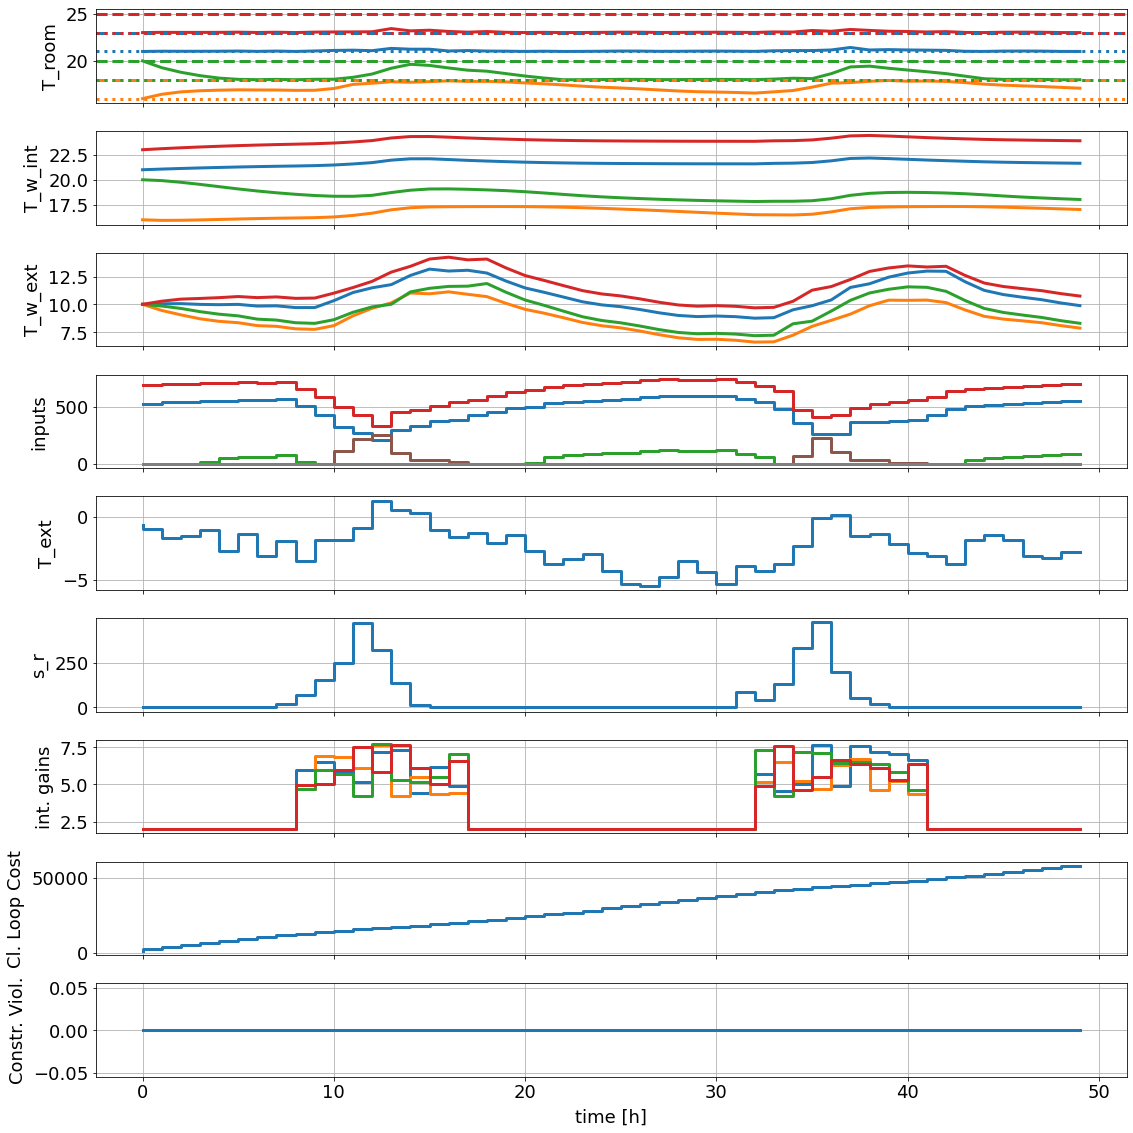

In [232]:
fig, ax = plt.subplots(9,1, sharex=True,figsize=(16,16))

# plot the states
ax[0].plot(hcb_mpc_data['_time'],hcb_mpc_data['_x','T_r'])
ax[0].axhline(lb_x[0],color='tab:blue',linestyle=':')
ax[0].axhline(ub_x[0],color='tab:blue',linestyle='--')
ax[0].axhline(lb_x[1],color='tab:orange',linestyle=':')
ax[0].axhline(ub_x[1],color='tab:orange',linestyle='--')
ax[0].axhline(lb_x[2],color='tab:green',linestyle=':')
ax[0].axhline(ub_x[2],color='tab:green',linestyle='--')
ax[0].axhline(lb_x[3],color='tab:red',linestyle=':')
ax[0].axhline(ub_x[3],color='tab:red',linestyle='--')
ax[1].plot(hcb_mpc_data['_time'],hcb_mpc_data['_x','T_w_int'])
ax[2].plot(hcb_mpc_data['_time'],hcb_mpc_data['_x','T_w_ext'])
ax[3].step(hcb_mpc_data['_time'],hcb_mpc_data['_u'])
ax[4].step(hcb_mpc_data['_time'],hcb_mpc_data['_tvp','T_ext'])
ax[5].step(hcb_mpc_data['_time'],hcb_mpc_data['_tvp','s_r'])
ax[6].step(hcb_mpc_data['_time'],hcb_mpc_data['_tvp','in_g'])
ax[7].step(hcb_mpc_data['_time'],clc_HCB)
ax[8].step(hcb_mpc_data['_time'],cv_HCB)
# Set labels
ax[0].set_ylabel('T_room')
ax[3].set_ylabel('inputs')
ax[1].set_ylabel('T_w_int')
ax[2].set_ylabel('T_w_ext')
ax[4].set_ylabel('T_ext')
ax[5].set_ylabel('s_r')
ax[6].set_ylabel('int. gains')
ax[7].set_ylabel('Cl. Loop Cost')
ax[8].set_ylabel('Constr. Viol.')
ax[-1].set_xlabel('time [h]')
#fig.align_labels()
fig.tight_layout()

# Computation of a Robust invariant control set

As the system has time varying parameters, the RCIS cannot be computed just once, but needs to be computed for every realization of the forecast. As the RCIS then could be different from one another, they need to be computed interconnected which is done here.

The here presented approach can also be used, when the parameters are not timevarying, but when you want to introduce feedback into more dimensions, than you can afford to cut. Then you can alternate the dimensions in each time step. For a RCIS including that, the RCIS needs to be computed for this amount of time steps.

If you do not want to cut in alternating directions, look at the code in Chapter 8.

This calculation is for the RCISs for the multistage-approach

In [62]:
# Predefine the number of partitions per Dimension for each step in the prediction horizon

cuts=[]
cuts.append(np.zeros((nx,1)))
cuts[0][0:nr]=1
#cuts[0][4]=1
ns1=1
for i in range(nx):
    ns1*=(cuts[0][i]+1)
nsl=[ns1]
for i in range(1,N_sim+N+1,1):
    nsl.append(ns1)
    cuts.append(np.zeros((nx,1)))
    cuts[i][0:nr]=1

In [63]:
opt_x_ro = struct_symSX([
    entry('x_min', shape=nx, repeat=[len(nsl),ns]),
    entry('x_max', shape=nx, repeat=[len(nsl),ns]),
    entry('delta',shape=(nx),repeat=[len(nsl),int(np.max(cuts))]),
    entry('u', shape=nu, repeat=[len(nsl),ns])
])
opt_p=struct_symSX([
    entry('p_min',shape=nd, repeat=[len(nsl)]),
    entry('p_max',shape=nd, repeat=[len(nsl)])
])

In [64]:
lb_opt_x_ro=opt_x_ro(-inf)
ub_opt_x_ro=opt_x_ro(inf)
lb_opt_x_ro['x_min'] = lb_x
lb_opt_x_ro['x_max'] = lb_x
ub_opt_x_ro['x_min'] = ub_x
ub_opt_x_ro['x_max'] = ub_x


lb_opt_x_ro['delta',:] = np.zeros((nx,1))
ub_opt_x_ro['delta',:] = np.ones((nx,1))*inf

lb_opt_x_ro['u'] = lb_u
ub_opt_x_ro['u'] = ub_u

Calculating the Volume as a cost function proved itself numerically unstable for the maximization of the whole RCIS. Therefore, the volume was just calculated for the constrained states. The others were weigthed quadratically. All other states were additionally constrained to keep them in a realistic region for the initial conditions

In [65]:
lb_opt_x_ro['x_min',:,:,nr:2*nr] = lb_x[0:nr]-5
lb_opt_x_ro['x_max',:,:,nr:2*nr] = lb_x[0:nr]-5
ub_opt_x_ro['x_min',:,:,nr:2*nr] = ub_x[0:nr]+3
ub_opt_x_ro['x_max',:,:,nr:2*nr] = ub_x[0:nr]+3

lb_opt_x_ro['x_min',:,:,2*nr:] = lb_x[0:nr]/2-5
lb_opt_x_ro['x_max',:,:,2*nr:] = lb_x[0:nr]/2-5
ub_opt_x_ro['x_min',:,:,2*nr:] = ub_x[0:nr]/2+5
ub_opt_x_ro['x_max',:,:,2*nr:] = ub_x[0:nr]/2+5

In [66]:
J=0
g=[]
lb_g=[]
ub_g=[]

for i in range(len(nsl)):
    # This is h(x)<0: define the offsets in each dimension for the individual subsets
    atled=SX.sym('atled',nx,int(np.max(cuts[i])))
    for m in range(nx):
        for h in range(int(np.max(cuts[i]))):
            if cuts[i][m]<=h:
                g.append(opt_x_ro['delta',i,h][m])            
                lb_g.append(0)
                ub_g.append(0)
            elif cuts[i][m]-1>h:
                g.append(opt_x_ro['delta',i,h+1][m]-opt_x_ro['delta',i,h][m])
                lb_g.append(0)
                ub_g.append(inf)
            if cuts[i][m]<=h:
                atled[m,h]=0
            else:
                atled[m,h]=opt_x_ro['x_max',i,-1][m]-opt_x_ro['x_min',i,0][m]-opt_x_ro['delta',i,h][m]
            if cuts[i][m]>h:   
                g.append(opt_x_ro['x_max',i,-1][m]-opt_x_ro['x_min',i,0][m]-opt_x_ro['delta',i,h][m])
                lb_g.append(0)
                ub_g.append(inf)


    # This is h(x)<0: constraint the corners of the subset to have the same offsets in specific dimensions
    for s in range(ns):
        count=np.zeros((nx,1))
        remainder=ns
        rest=s
        for l in range(nx):
            if cuts[i][l]>0:
                remainder/=(cuts[i][l]+1)
                count[l]=rest//remainder
                rest-=remainder*count[l]
        for k in range(nx):
            if count[k]==0 and count[k]==cuts[i][k]:
                g.append(opt_x_ro['x_min',i,s][k]-opt_x_ro['x_min',i,0][k])
                lb_g.append(0)
                ub_g.append(0)
                g.append(opt_x_ro['x_max',i,-1][k]-opt_x_ro['x_max',i,s][k])
                lb_g.append(0)
                ub_g.append(0)
            elif count[k]==0 and count[k]!=cuts[i][k]:
                g.append(opt_x_ro['x_min',i,s][k]-opt_x_ro['x_min',i,0][k])
                lb_g.append(0)
                ub_g.append(0)
                g.append(opt_x_ro['x_max',i,-1][k]-opt_x_ro['x_max',i,s][k]-atled[k,int(count[k])])
                lb_g.append(0)
                ub_g.append(0)
            elif count[k]==cuts[i][k] and count[k]!=0:
                g.append(opt_x_ro['x_min',i,s][k]-opt_x_ro['x_min',i,0][k]-opt_x_ro['delta',i,int(count[k]-1)][k])
                lb_g.append(0)
                ub_g.append(0)
                g.append(opt_x_ro['x_max',i,-1][k]-opt_x_ro['x_max',i,s][k])
                lb_g.append(0)
                ub_g.append(0)
            else:
                g.append(opt_x_ro['x_min',i,s][k]-opt_x_ro['x_min',i,0][k]-opt_x_ro['delta',i,int(count[k]-1)][k])
                lb_g.append(0)
                ub_g.append(0)
                g.append(opt_x_ro['x_max',i,-1][k]-opt_x_ro['x_max',i,s][k]-atled[k,int(count[k])])
                lb_g.append(0)
                ub_g.append(0)


    for s in range(ns):
        
        if i==len(nsl)-1:
            g.append(system(opt_x_ro['x_min',i,s], opt_x_ro['u',i,s],opt_p['p_min',i])-opt_x_ro['x_min',0,0])
            g.append(-system(opt_x_ro['x_max',i,s], opt_x_ro['u',i,s],opt_p['p_max',i])+opt_x_ro['x_max',0,-1])
            lb_g.append(np.zeros((2*nx,1)))
            ub_g.append(np.ones((2*nx,1))*inf)
        else:
            g.append(system(opt_x_ro['x_min',i,s], opt_x_ro['u',i,s],opt_p['p_min',i])-opt_x_ro['x_min',i+1,0])
            g.append(-system(opt_x_ro['x_max',i,s], opt_x_ro['u',i,s],opt_p['p_max',i])+opt_x_ro['x_max',i+1,-1])
            lb_g.append(np.zeros((2*nx,1)))
            ub_g.append(np.ones((2*nx,1))*inf)





    g.append(opt_x_ro['x_max',i,-1]-opt_x_ro['x_min',i,0])
    lb_g.append(np.zeros((nx,1)))
    ub_g.append(inf*np.ones((nx,1)))


    j=-1
    for h in range(nr):
        j*=(opt_x_ro['x_max',i,-1][h]-opt_x_ro['x_min',i,0][h]+1e-4)
    J+=j
    for h in range(2*nr):
        J+=(ub_opt_x_ro['x_max',i,-1][h+nr]-opt_x_ro['x_max',i,-1][h+nr])**2
        J+=(opt_x_ro['x_min',i,0][h+nr]-lb_opt_x_ro['x_min',i,0][h+nr])**2

g = vertcat(*g)
lb_g = vertcat(*lb_g)
ub_g = vertcat(*ub_g)

prob = {'f':J,'x':vertcat(opt_x_ro),'g':g, 'p':vertcat(opt_p)}
solver_mx_inv_set = nlpsol('solver','ipopt',prob,{'ipopt':{'max_iter':5000}})#,'hessian_approximation':'limited-memory'}})

In [67]:
opt_p_k=opt_p(0)
for k in range(len(nsl)):
    opt_p_k['p_min',k]=vertcat(p_fun_min(k*dt))
    opt_p_k['p_max',k]=vertcat(p_fun_max(k*dt))

In [68]:
opt_x_initial=opt_x_ro(0)
#opt_x_initial['x_min']=x_0
#opt_x_initial['x_max']=x

opt_x_initial['u']=0.0
results=solver_mx_inv_set(p=vertcat(opt_p_k),lbg=lb_g,ubg=ub_g,lbx=lb_opt_x_ro,ubx=ub_opt_x_ro,x0=opt_x_initial)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    51912
Number of nonzeros in inequality constraint Jacobian.:   163548
Number of nonzeros in Lagrangian Hessian.............:     2520

Total number of variables............................:    33012
                     variables with only lower bounds:      756
                variables with lower and upper bounds:    32256
                     variables with only upper bounds:        0
Total number of equality constraints.................:    24696
Total number of inequality constraints...............:    25200
        inequality constraints with only lower bounds:    25200
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

  81 3.3543336e+004 2.45e+000 1.28e+002  -1.0 6.59e+002    -  1.42e-003 8.96e-004f  1
  82 3.3490463e+004 2.44e+000 1.28e+002  -1.0 6.64e+002    -  1.24e-003 1.82e-003f  1
  83 3.3460352e+004 2.44e+000 1.28e+002  -1.0 6.33e+002    -  1.24e-003 1.05e-003f  1
  84 3.3404445e+004 2.43e+000 1.28e+002  -1.0 6.30e+002    -  1.46e-003 1.96e-003f  1
  85 3.3372433e+004 2.43e+000 1.28e+002  -1.0 6.26e+002    -  1.78e-003 1.13e-003f  1
  86 3.3312074e+004 2.43e+000 1.27e+002  -1.0 6.25e+002    -  1.05e-003 2.15e-003f  1
  87 3.3280637e+004 2.42e+000 1.27e+002  -1.0 6.24e+002    -  1.35e-003 1.13e-003f  1
  88 3.3201956e+004 2.42e+000 1.27e+002  -1.0 6.24e+002    -  1.48e-003 2.87e-003f  1
  89 3.3170636e+004 2.41e+000 1.27e+002  -1.0 6.23e+002    -  1.21e-003 1.17e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 3.3122569e+004 2.41e+000 1.27e+002  -1.0 6.24e+002    -  1.44e-003 1.82e-003f  1
  91 3.3060885e+004 2.40e+000 1.27e+002  -1.0 6.22e+002    

 172 3.0817461e+004 2.07e+000 1.38e+002  -1.0 8.86e+002    -  1.09e-003 1.45e-003f  1
 173 3.0803661e+004 2.07e+000 1.38e+002  -1.0 8.60e+002    -  2.42e-003 1.91e-003f  1
 174 3.0792350e+004 2.07e+000 1.38e+002  -1.0 9.80e+002    -  2.51e-003 1.64e-003f  1
 175 3.0774717e+004 2.06e+000 1.38e+002  -1.0 1.04e+003    -  2.94e-003 2.54e-003f  1
 176 3.0748863e+004 2.05e+000 1.37e+002  -1.0 1.05e+003    -  2.89e-003 3.64e-003f  1
 177 3.0722695e+004 2.05e+000 1.37e+002  -1.0 1.02e+003    -  1.52e-003 3.47e-003f  1
 178 3.0716728e+004 2.05e+000 1.37e+002  -1.0 9.22e+002    -  2.17e-003 7.41e-004f  1
 179 3.0696103e+004 2.04e+000 1.36e+002  -1.0 9.02e+002    -  2.04e-003 2.49e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 3.0676324e+004 2.04e+000 1.36e+002  -1.0 8.99e+002    -  1.73e-003 2.48e-003f  1
 181 3.0669373e+004 2.03e+000 1.36e+002  -1.0 8.98e+002    -  2.23e-003 9.14e-004f  1
 182 3.0653107e+004 2.03e+000 1.35e+002  -1.0 8.99e+002    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 2.9063800e+004 1.58e+000 1.21e+002  -1.0 6.71e+002    -  1.97e-003 5.50e-004f  1
 261 2.9049208e+004 1.57e+000 1.21e+002  -1.0 6.69e+002    -  1.60e-003 2.16e-003f  1
 262 2.8984593e+004 1.56e+000 1.19e+002  -1.0 6.65e+002    -  1.66e-003 9.18e-003f  1
 263 2.8973852e+004 1.56e+000 1.19e+002  -1.0 6.51e+002    -  3.31e-003 1.48e-003f  1
 264 2.8944021e+004 1.55e+000 1.18e+002  -1.0 6.43e+002    -  5.57e-003 3.95e-003f  1
 265 2.8901251e+004 1.54e+000 1.18e+002  -1.0 6.19e+002    -  5.35e-003 5.39e-003f  1
 266 2.8861650e+004 1.53e+000 1.17e+002  -1.0 1.18e+003    -  5.05e-003 4.93e-003f  1
 267 2.8830296e+004 1.53e+000 1.17e+002  -1.0 5.49e+002    -  3.84e-003 3.61e-003f  1
 268 2.8759490e+004 1.51e+000 1.15e+002  -1.0 6.01e+002    -  4.49e-003 8.24e-003f  1
 269 2.8752665e+004 1.51e+000 1.16e+002  -1.0 1.47e+003    -  4.83e-003 8.33e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 349 2.5576500e+004 1.09e+000 8.07e+001  -1.0 5.14e+002    -  5.75e-003 2.67e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350 2.5518573e+004 1.08e+000 8.02e+001  -1.0 4.96e+002    -  3.39e-003 4.76e-003f  1
 351 2.5489865e+004 1.08e+000 8.01e+001  -1.0 4.62e+002    -  3.15e-003 2.34e-003f  1
 352 2.5434975e+004 1.08e+000 7.96e+001  -1.0 4.55e+002    -  2.91e-003 4.45e-003f  1
 353 2.5388300e+004 1.07e+000 7.93e+001  -1.0 4.88e+002    -  3.70e-003 3.77e-003f  1
 354 2.5328542e+004 1.07e+000 7.89e+001  -1.0 4.02e+002    -  3.58e-003 4.83e-003f  1
 355 2.5308968e+004 1.07e+000 7.89e+001  -1.0 5.29e+002    -  4.60e-003 1.58e-003f  1
 356 2.5255974e+004 1.06e+000 7.85e+001  -1.0 6.07e+002    -  2.86e-003 4.22e-003f  1
 357 2.5222092e+004 1.06e+000 7.83e+001  -1.0 6.36e+002    -  3.33e-003 2.71e-003f  1
 358 2.5152733e+004 1.05e+000 7.77e+001  -1.0 6.30e+002    -  3.40e-003 5.57e-003f  1
 359 2.5112341e+004 1.05e+000 7.75e+001  -1.0 5.98e+002    

 437 2.0282101e+004 6.13e-001 4.49e+001  -1.0 2.67e+002    -  1.31e-002 8.85e-003f  1
 438 2.0208012e+004 6.06e-001 4.45e+001  -1.0 2.64e+002    -  1.15e-002 1.03e-002f  1
 439 2.0128038e+004 6.00e-001 4.39e+001  -1.0 2.59e+002    -  9.18e-003 1.12e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440 2.0062215e+004 5.94e-001 4.36e+001  -1.0 2.51e+002    -  1.15e-002 9.34e-003f  1
 441 1.9980685e+004 5.87e-001 4.30e+001  -1.0 2.43e+002    -  1.04e-002 1.16e-002f  1
 442 1.9909970e+004 5.81e-001 4.27e+001  -1.0 2.36e+002    -  1.17e-002 1.03e-002f  1
 443 1.9831510e+004 5.74e-001 4.23e+001  -1.0 2.28e+002    -  1.30e-002 1.16e-002f  1
 444 1.9743776e+004 5.67e-001 4.15e+001  -1.0 2.32e+002    -  1.01e-002 1.32e-002f  1
 445 1.9652743e+004 5.59e-001 4.09e+001  -1.0 2.42e+002    -  1.27e-002 1.39e-002f  1
 446 1.9581749e+004 5.53e-001 4.05e+001  -1.0 2.47e+002    -  1.24e-002 1.09e-002f  1
 447 1.9468447e+004 5.43e-001 3.95e+001  -1.0 2.49e+002    

In [69]:
res=opt_x_ro(results['x'])

In [70]:
lb_x_ro=res['x_min',:,0]
#print(lb_x_ro)

In [71]:
ub_x_ro=res['x_max',:,-1]
#print(ub_x_ro)

# Simplified Closed Loop Approach
$
\min_{x_{\left[0:N\right]}^+,x_{\left[0:N\right]}^-,u_{\left[0:N-1\right]}^+,u_{\left[0:N-1\right]}^-} \quad \sum_{k=0}^{N-1} (\ell(x_k^+,u_k^+)+\ell(x_k^-,u_k^-))+V_f(x_{N}^+)+V_f(x_{N}^-)\\
\begin{aligned}
	s.t:\quad&x_0^{\pm}=x_0,\\
	&x_{k+1}^{\pm}=f(x_k^{\pm},u_k^{\pm},p^{\pm}),\ \forall k\in\{0,...,N-1\}\\
	&x_k^{\pm}\in X_{\text{RCIS}},\ k\in\{1,...,N\}\\
	&u_k^{\pm}\in U ,\ \forall k\in\{0,...,N-1\},\\
	&u_0^+=u_0^-.
\end{aligned}
$

In [120]:
opt_x = struct_symSX([
    entry('x', shape=nx, repeat=[N+1,2]),
    entry('u', shape=nu, repeat=[N,2])
])
opt_p=struct_symSX([
    entry('p_min',shape=nd, repeat=[N]),
    entry('p_max',shape=nd, repeat=[N])
])

In [121]:
lb_opt_x = opt_x(0)
ub_opt_x = opt_x(0)

In [122]:
lb_opt_x['x'] = lb_x_ro
ub_opt_x['x'] = ub_x_ro

lb_opt_x['u'] = lb_u
ub_opt_x['u'] = ub_u

In [123]:
J = 0
g = []    # constraint expression g
lb_g = []  # lower bound for constraint expression g
ub_g = []  # upper bound for constraint expression g

In [124]:
x_init = SX.sym('x_init', nx)
u_in = SX.sym('u_in', nu)
p_plus=SX.sym('p_plus', nd)
p_minus=SX.sym('p_minus', nd)
x0 = opt_x['x', 0, 0]
g.append(opt_x['x', 0,0]-opt_x['x', 0,1])
g.append(x0-x_init)
lb_g.append(np.zeros((2*nx,1)))
ub_g.append(np.zeros((2*nx,1)))
# 01

for i in range(N):
    # 02 - Your code here!
    # objective
    if i>0:
        J += stage_cost_fcn(opt_x['x',i,0], opt_x['u',i,0],opt_x['u',i-1,0])
        J += stage_cost_fcn(opt_x['x',i,1], opt_x['u',i,1],opt_x['u',i-1,1])
    else:
        J += stage_cost_fcn(opt_x['x',i,0], opt_x['u',i,0],u_in)
        J += stage_cost_fcn(opt_x['x',i,1], opt_x['u',i,1],u_in)
    # 02

    # 03 - Your code here!
    # equality constraints (system equation)


    # 04 - Your code here!
    x_next_plus = system(opt_x['x',i,0], opt_x['u',i,0],opt_p['p_max',i])
    x_next_minus = system(opt_x['x',i,1], opt_x['u',i,1],opt_p['p_min',i])
    g.append(x_next_plus - opt_x['x', i+1, 0])
    g.append(x_next_minus - opt_x['x', i+1, 1])
    lb_g.append(np.zeros((2*nx,1)))
    ub_g.append(np.zeros((2*nx,1)))
    # 04


# 05 - Your code here!
J += terminal_cost_fcn(opt_x['x', N,0])
J += terminal_cost_fcn(opt_x['x', N,1])
# 05
g.append(opt_x['u', 0, 1] - opt_x['u', 0, 0])
lb_g.append(np.zeros((nu,1)))
ub_g.append(np.zeros((nu,1)))
# 06 - Your code here!
g = vertcat(*g)
lb_g = vertcat(*lb_g)
ub_g = vertcat(*ub_g)

prob = {'f':J,'x':vertcat(opt_x),'g':g, 'p':vertcat(x_init,u_in,opt_p)}
mpc_mon_solver = nlpsol('solver','ipopt',prob)

In [130]:
# Define the initial state
x_0 = 20*np.ones((nx,1))
for i in range(nx):
    if lb_x[i]<=x_0[i] and x_0[i]<=ub_x[i]:
        1
    else:
        x_0[i::nr]=lb_x[i]
x_0[-nr:]=10

#x_0=(lb_list[0]+ub_list[0])/2

# Initialize result lists for states and inputs
res_x_mpc = [x_0]
res_u_mpc = []

# Set number of iterations
N_sim = 50

In [131]:
simulator.set_tvp_fun(p_fun_max)
simulator.reset_history()
simulator.x0=x_0

In [132]:
tic=time.time()
opt_p_k=opt_p(0)
clc_MS_MPC=np.zeros((N_sim,1))
cv_MS_MPC=np.zeros((N_sim,1))

for i in range(N_sim):
    print(i)
    # 01 - Your code here!
    lb_opt_x['x',:,:] = lb_x_ro[i:i+N+1]
    ub_opt_x['x',:,:] = ub_x_ro[i:i+N+1]


    for k in range(N):
        opt_p_k['p_min',k]=vertcat(p_fun_min(k*dt+i*dt))
        opt_p_k['p_max',k]=vertcat(p_fun_max(k*dt+i*dt))
    # solve optimization problem
    # optionally: Warmstart the optimizer by passing the previous solution as an initial guess!
    if i>0:
        mpc_res = mpc_mon_solver(p=vertcat(x_0,u_k,opt_p_k), x0=opt_x_k, lbg=lb_g, ubg=ub_g, lbx = lb_opt_x, ubx = ub_opt_x)
    else:
        mpc_res = mpc_mon_solver(p=vertcat(x_0,np.zeros((nu,1)),opt_p_k), lbg=lb_g, ubg=ub_g, lbx = lb_opt_x, ubx = ub_opt_x)



    # Extract the control input
    opt_x_k = opt_x(mpc_res['x'])
    u_k = opt_x_k['u',0,0]
    # 02
    if i>0:
        clc_MS_MPC[i]=clc_MS_MPC[i-1]+stage_cost_fcn(x_0,u_k,res_u_mpc[-1])
    else:
        clc_MS_MPC[i]=stage_cost_fcn(x_0,u_k,u0)
    # simulate the system
    # 03
    cv_MS_MPC[i]=np.sum([np.max([lb_x[l]-x_0[l],0]) for l in range(nx)])+np.sum([np.max([x_0[l]-ub_x[l],0]) for l in range(nx)])

    # simulate the system
    x_next = simulator.make_step(u_k)
    # 03
    
    # 04 - Your code here!
    # Update the initial state
    x_0 = x_next

    res_x_mpc.append(x_next)
    res_u_mpc.append(u_k)
toc_MSMPC=time.time()-tic

0
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1972
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      504
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      504
                     variables with only upper bounds:        0
Total number of equality constraints.................:      320
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0

C:\Users\smmzhein\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


                     variables with only lower bounds:        0
                variables with lower and upper bounds:      504
                     variables with only upper bounds:        0
Total number of equality constraints.................:      320
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.6690314e+004 1.17e+000 1.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.6626006e+004 1.15e+000 7.92e+000  -1.0 1.81e+002    -  9.70e-002 1.14e-002f  1
   2 2.6589819e+004 1.13e+000 1.06e+002  -1.0 1.42e+002    -  2.71e-001 1.89e-002f  1
   3 2.6557341e+004 1.10e+000 1.18e+002  -1.0 1.45e+002    -  7.40e-002 2.57e-002f  1
   4 2.6530705e+004 1.08e+000 2.69e+002  -1.0 1.45e+002    -  

   2 2.2944243e+004 1.14e+000 8.59e+001  -1.0 1.57e+002    -  2.24e-001 2.49e-002f  1
   3 2.2917809e+004 1.10e+000 1.89e+002  -1.0 1.59e+002    -  1.47e-001 2.92e-002f  1
   4 2.2876685e+004 1.02e+000 2.47e+002  -1.0 1.38e+002    -  1.91e-001 7.22e-002f  1
   5 2.2819565e+004 8.73e-001 2.14e+002  -1.0 1.98e+002    -  2.17e-001 1.47e-001f  1
   6 2.2771236e+004 7.50e-001 1.88e+002  -1.0 1.70e+002    -  3.58e-001 1.41e-001f  1
   7 2.2742929e+004 6.70e-001 1.65e+002  -1.0 1.47e+002    -  5.33e-001 1.07e-001f  1
   8 2.2669541e+004 4.49e-001 1.01e+002  -1.0 1.31e+002    -  7.58e-001 3.30e-001f  1
   9 2.2668709e+004 4.46e-001 1.27e+002  -1.0 8.77e+001    -  4.77e-002 5.48e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.2646557e+004 3.65e-001 8.53e+001  -1.0 8.73e+001    -  4.49e-003 1.83e-001f  1
  11 2.2646301e+004 3.64e-001 1.00e+002  -1.0 6.61e+001    -  3.06e-002 2.61e-003h  1
  12 2.2616466e+004 2.14e-001 5.98e+001  -1.0 5.54e+001    


Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............:  2.4290348751283549e+004   2.4290348751283549e+004
Dual infeasibility......:  1.4305114746093750e-006   1.4305114746093750e-006
Constraint violation....:  4.5542236648543621e-011   4.5542236648543621e-011
Complementarity.........:  2.5911489647385095e-009   2.5911489647385095e-009
Overall NLP error.......:  4.5542236648543621e-011   1.4305114746093750e-006


Number of objective function evaluations             = 24
Number of objective gradient evaluations             = 24
Number of equality constraint evaluations            = 24
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 24
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 23
Total CPU secs in IPOPT (w/o function evaluations)   =      0.043
Total CPU secs in NLP function evaluation

  11 2.8810639e+004 9.71e-009 1.93e+005  -1.0 6.59e-003    -  1.00e+000 9.82e-001h  1
  12 2.8810639e+004 4.34e-009 4.88e+008  -1.0 1.17e-004    -  1.00e+000 5.54e-001h  1
  13 2.8810639e+004 1.64e-010 1.19e-007  -1.0 5.22e-005    -  1.00e+000 1.00e+000f  1
In iteration 13, 2 Slacks too small, adjusting variable bounds
  14 2.8800120e+004 7.27e-011 2.09e+008  -8.6 1.17e+000    -  9.81e-001 5.56e-001f  1
In iteration 14, 2 Slacks too small, adjusting variable bounds
  15 2.8791767e+004 4.31e-010 1.54e+006  -8.6 5.00e-001    -  9.93e-001 9.95e-001f  1
In iteration 15, 2 Slacks too small, adjusting variable bounds
  16 2.8791725e+004 7.27e-011 1.54e-004  -8.6 1.49e-003    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:  2.8791725303429899e+004   2.8791725303429899e+004
Dual infeasibility......:  1.5389919281005859e-004   1.5389919281005859e-004
Constraint violation....:  7.2688521868

  14 3.0883399e+004 1.42e-014 7.27e-014  -2.5 9.67e-002    -  1.00e+000 1.00e+000f  1
  15 3.0882893e+004 1.07e-014 9.10e-014  -3.8 2.05e-002    -  1.00e+000 1.00e+000f  1
  16 3.0882865e+004 7.11e-015 7.97e-014  -5.7 1.16e-003    -  1.00e+000 1.00e+000f  1
  17 3.0882864e+004 1.07e-014 8.18e-014  -8.6 1.42e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:  3.0882864375359331e+004   3.0882864375359331e+004
Dual infeasibility......:  8.1755698419532690e-014   8.1755698419532690e-014
Constraint violation....:  1.0658141036401503e-014   1.0658141036401503e-014
Complementarity.........:  2.5125704969406654e-009   2.5125704969406654e-009
Overall NLP error.......:  2.5125704969406654e-009   2.5125704969406654e-009


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations          

   8 2.6398966e+004 7.00e-001 3.70e+002  -1.0 1.83e+002    -  5.10e-001 1.43e-001f  1
   9 2.6345870e+004 6.27e-001 3.32e+002  -1.0 1.67e+002    -  3.02e-001 1.04e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.6320486e+004 5.88e-001 3.11e+002  -1.0 1.44e+002    -  3.62e-001 6.26e-002f  1
  11 2.6238598e+004 4.58e-001 2.42e+002  -1.0 1.32e+002    -  1.42e-002 2.22e-001f  1
  12 2.6192638e+004 3.79e-001 1.98e+002  -1.0 1.03e+002    -  8.65e-001 1.71e-001f  1
  13 2.6178543e+004 3.56e-001 1.86e+002  -1.0 8.52e+001    -  7.14e-002 6.13e-002f  1
  14 2.5976765e+004 1.07e-014 4.48e+001  -1.0 8.00e+001    -  5.15e-001 1.00e+000f  1
  15 2.5976731e+004 7.11e-015 1.39e-001  -1.0 6.63e-001    -  9.99e-001 1.00e+000f  1
  16 2.5960147e+004 1.07e-014 2.53e-001  -2.5 1.02e+000    -  9.23e-001 9.02e-001f  1
  17 2.5958357e+004 1.07e-014 1.04e-013  -2.5 9.82e-002    -  1.00e+000 1.00e+000f  1
  18 2.5957850e+004 1.07e-014 9.12e-014  -3.8 2.77e-002    


EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        26
       nlp_g  |        0 (       0)        0 (       0)        26
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        27
  nlp_hess_l  |        0 (       0)        0 (       0)        25
   nlp_jac_g  |        0 (       0)        0 (       0)        27
       total  |  38.00ms ( 38.00ms)  38.02ms ( 38.02ms)         1
34
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1972
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      504
                     variables with on

Total CPU secs in IPOPT (w/o function evaluations)   =      0.028
Total CPU secs in NLP function evaluations           =      0.001

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        19
       nlp_g  |   1.00ms ( 52.63us)   1.00ms ( 52.68us)        19
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        19
  nlp_hess_l  |        0 (       0)        0 (       0)        17
   nlp_jac_g  |        0 (       0)        0 (       0)        19
       total  |  30.00ms ( 30.00ms)  30.28ms ( 30.28ms)         1
40
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1972
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian He

   9 3.0442443e+004 1.07e-014 7.38e-014  -2.5 1.38e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.0441934e+004 1.42e-014 8.87e-014  -3.8 3.94e-002    -  1.00e+000 1.00e+000f  1
  11 3.0441906e+004 1.07e-014 8.02e-014  -5.7 1.88e-003    -  1.00e+000 1.00e+000f  1
  12 3.0441906e+004 1.42e-014 8.48e-014  -8.6 2.33e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  3.0441905660421053e+004   3.0441905660421053e+004
Dual infeasibility......:  8.4825711950373725e-014   8.4825711950373725e-014
Constraint violation....:  1.4210854715202004e-014   1.4210854715202004e-014
Complementarity.........:  2.5301160155763766e-009   2.5301160155763766e-009
Overall NLP error.......:  2.5301160155763766e-009   2.5301160155763766e-009


Number of objective function evaluations             = 16
Number of objective gradient

In [133]:
ms_mpc_data=copy.copy(simulator.data)

Text(0.5, 0, 'time [h]')

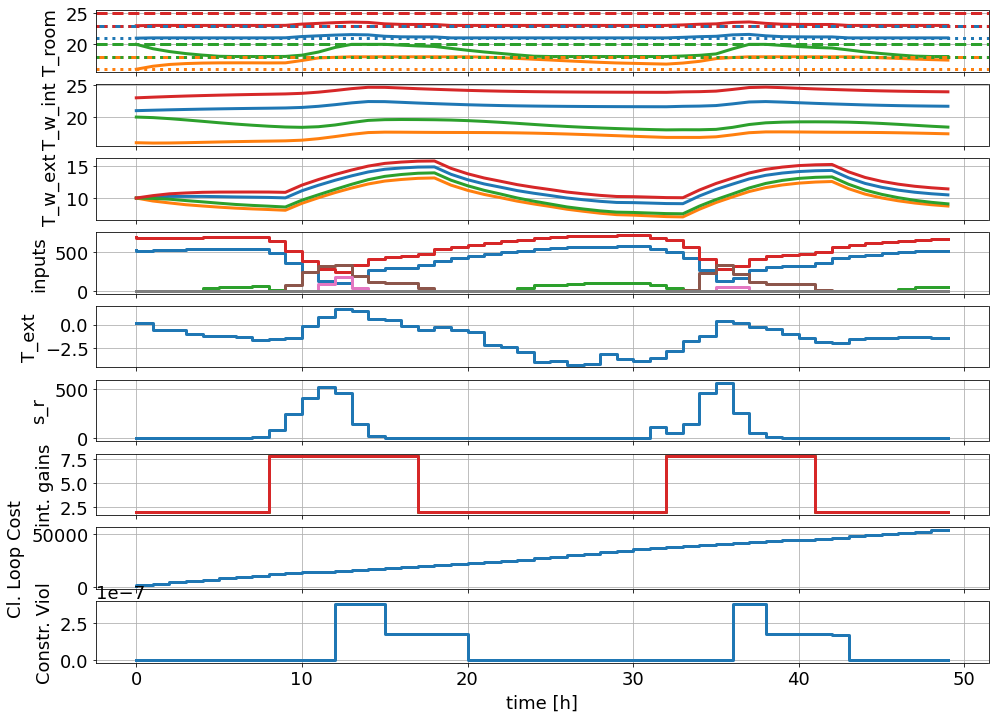

In [134]:
fig, ax = plt.subplots(9,1, sharex=True,figsize=(16,12))

# plot the states
ax[0].plot(ms_mpc_data['_time'],ms_mpc_data['_x','T_r'])
ax[0].axhline(lb_x[0],color='tab:blue',linestyle=':')
ax[0].axhline(ub_x[0],color='tab:blue',linestyle='--')
ax[0].axhline(lb_x[1],color='tab:orange',linestyle=':')
ax[0].axhline(ub_x[1],color='tab:orange',linestyle='--')
ax[0].axhline(lb_x[2],color='tab:green',linestyle=':')
ax[0].axhline(ub_x[2],color='tab:green',linestyle='--')
ax[0].axhline(lb_x[3],color='tab:red',linestyle=':')
ax[0].axhline(ub_x[3],color='tab:red',linestyle='--')
ax[1].plot(ms_mpc_data['_time'],ms_mpc_data['_x','T_w_int'])
ax[2].plot(ms_mpc_data['_time'],ms_mpc_data['_x','T_w_ext'])
ax[3].step(ms_mpc_data['_time'],ms_mpc_data['_u'])
ax[4].step(ms_mpc_data['_time'],ms_mpc_data['_tvp','T_ext'])
ax[5].step(ms_mpc_data['_time'],ms_mpc_data['_tvp','s_r'])
ax[6].step(ms_mpc_data['_time'],ms_mpc_data['_tvp','in_g'])
ax[7].step(ms_mpc_data['_time'],clc_MS_MPC)
ax[8].step(ms_mpc_data['_time'],cv_MS_MPC)
# Set labels
ax[0].set_ylabel('T_room')
ax[3].set_ylabel('inputs')
ax[1].set_ylabel('T_w_int')
ax[2].set_ylabel('T_w_ext')
ax[4].set_ylabel('T_ext')
ax[5].set_ylabel('s_r')
ax[6].set_ylabel('int. gains')
ax[7].set_ylabel('Cl. Loop Cost')
ax[8].set_ylabel('Constr. Viol')
ax[-1].set_xlabel('time [h]')

Saving the solutions for Postprocessing

In [246]:
#data_dict={'MPC':[mpc_data,clc_MPC,cv_MPC,toc_MPC],'HCB':[hcb_mpc_data,clc_HCB,cv_HCB,toc_HCB],'MS-MPC':[ms_mpc_data,clc_MS_MPC,cv_MS_MPC,toc_MSMPC]}

In [289]:
#np.save('4room_var.npy',data_dict,allow_pickle=True) # Needs to be renamed according to uncertainty realization

# Calculation of RCIS after Equation (12)

Can be used for systems with no time-varying parameters.

In [93]:
cuts=np.zeros((nx,1))
cuts[0:nr]=1
#cuts[4:]=1
ns=1
for i in range(nx):
    ns*=(cuts[i]+1)
ns=int(ns[0])
print(ns)

16


In [94]:
x_ref=SX.sym('x_ref',nx,1)

In [95]:
opt_x_ro = struct_symSX([
    entry('x_min', shape=nx, repeat=[ns]),
    entry('x_max', shape=nx, repeat=[ns]),
    entry('delta',shape=(nx),repeat=[int(np.max(cuts))]),
    entry('u', shape=nu, repeat=[ns])
])

In [96]:
lb_opt_x_ro = opt_x_ro(0)
ub_opt_x_ro = opt_x_ro(np.inf)
lb_opt_x_ro['u'] = lb_u
ub_opt_x_ro['u'] = ub_u
#lb_opt_x_ro['delta',:] = np.zeros((nx,1))
#ub_opt_x_ro['delta',:] = np.ones((nx,1))*inf

In [97]:
lb_opt_x_ro['x_min'] = lb_x
lb_opt_x_ro['x_max'] = lb_x
ub_opt_x_ro['x_min'] = ub_x
ub_opt_x_ro['x_max'] = ub_x


lb_opt_x_ro['delta',:] = np.zeros((nx,1))
ub_opt_x_ro['delta',:] = np.ones((nx,1))*inf

lb_opt_x_ro['u'] = lb_u
ub_opt_x_ro['u'] = ub_u

In [98]:
lb_opt_x_ro['x_min',:,nr:2*nr] = lb_x[0:nr]-5
lb_opt_x_ro['x_max',:,nr:2*nr] = lb_x[0:nr]-5
ub_opt_x_ro['x_min',:,nr:2*nr] = ub_x[0:nr]+3
ub_opt_x_ro['x_max',:,nr:2*nr] = ub_x[0:nr]+3

lb_opt_x_ro['x_min',:,2*nr:] = lb_x[0:nr]/2-5
lb_opt_x_ro['x_max',:,2*nr:] = lb_x[0:nr]/2-5
ub_opt_x_ro['x_min',:,2*nr:] = ub_x[0:nr]/2+5
ub_opt_x_ro['x_max',:,2*nr:] = ub_x[0:nr]/2+5

In [99]:
x_0=np.ones((nx,1))*20
for i in range(nx):
    if lb_x[i]<=x_0[i] and x_0[i]<=ub_x[i]:
        1
    else:
        x_0[i::nr]=lb_x[i]
x_0[-nr:]=10

In [100]:
J=0
g=[]
lb_g=[]
ub_g=[]
x_ref=SX.sym('x_ref',nx)
p_plus=SX.sym('p_plus',nd)
p_minus=SX.sym('p_minus',nd)
atled=SX.sym('atled',nx,int(np.max(cuts)))
for m in range(nx):
    for h in range(int(np.max(cuts))):
        if cuts[m]<=h:
            g.append(opt_x_ro['delta',h][m])            
            lb_g.append(0)
            ub_g.append(0)
        elif cuts[m]-1>h:
            g.append(opt_x_ro['delta',h+1][m]-opt_x_ro['delta',h][m])
            lb_g.append(0)
            ub_g.append(inf)
        if cuts[m]<=h:
            atled[m,h]=0
        else:
            atled[m,h]=opt_x_ro['x_max',-1][m]-opt_x_ro['x_min',0][m]-opt_x_ro['delta',h][m]
        if cuts[m]>h:   
            g.append(opt_x_ro['x_max',-1][m]-opt_x_ro['x_min',0][m]-opt_x_ro['delta',h][m])
            lb_g.append(0)
            ub_g.append(inf)
    


for s in range(ns):
    count=np.zeros((nx,1))
    remainder=ns
    rest=s
    for l in range(nx):
        if cuts[l]>0:
            remainder/=(cuts[l]+1)
            count[l]=rest//remainder
            rest-=remainder*count[l]
    for k in range(nx):
        if count[k]==0 and count[k]==cuts[k]:
            g.append(opt_x_ro['x_min',s][k]-opt_x_ro['x_min',0][k])
            lb_g.append(0)
            ub_g.append(0)
            g.append(opt_x_ro['x_max',-1][k]-opt_x_ro['x_max',s][k])
            lb_g.append(0)
            ub_g.append(0)
        elif count[k]==0 and count[k]!=cuts[k]:
            g.append(opt_x_ro['x_min',s][k]-opt_x_ro['x_min',0][k])
            lb_g.append(0)
            ub_g.append(0)
            g.append(opt_x_ro['x_max',-1][k]-opt_x_ro['x_max',s][k]-atled[k,int(count[k])])
            lb_g.append(0)
            ub_g.append(0)
        elif count[k]==cuts[k] and count[k]!=0:
            g.append(opt_x_ro['x_min',s][k]-opt_x_ro['x_min',0][k]-opt_x_ro['delta',int(count[k]-1)][k])
            lb_g.append(0)
            ub_g.append(0)
            g.append(opt_x_ro['x_max',-1][k]-opt_x_ro['x_max',s][k])
            lb_g.append(0)
            ub_g.append(0)
        else:
            g.append(opt_x_ro['x_min',s][k]-opt_x_ro['x_min',0][k]-opt_x_ro['delta',int(count[k]-1)][k])
            lb_g.append(0)
            ub_g.append(0)
            g.append(opt_x_ro['x_max',-1][k]-opt_x_ro['x_max',s][k]-atled[k,int(count[k])])
            lb_g.append(0)
            ub_g.append(0)



    # The new states should lie in the old states -> shrinking set
    g.append(system(opt_x_ro['x_min',s], opt_x_ro['u',s],p_minus)-opt_x_ro['x_min',0])
    g.append(-system(opt_x_ro['x_max',s], opt_x_ro['u',s],p_plus)+opt_x_ro['x_max',-1])
    lb_g.append(np.zeros((2*nx,1)))
    ub_g.append(np.ones((2*nx,1))*inf)
    
    
        
g.append(opt_x_ro['x_max',-1]-opt_x_ro['x_min',0])
lb_g.append(np.zeros((nx,1)))
ub_g.append(inf*np.ones((nx,1)))

J=-1
for i in range(nr):
    J*=(opt_x_ro['x_max',-1][i]-opt_x_ro['x_min',0][i]+1e-4)
for i in range(2*nr):
    J+=(ub_opt_x_ro['x_max',-1][i+nr]-opt_x_ro['x_max',-1][i+nr])**2
    J+=(opt_x_ro['x_min',0][i+nr]-lb_opt_x_ro['x_min',0][i+nr])**2
g = vertcat(*g)
lb_g = vertcat(*lb_g)
ub_g = vertcat(*ub_g)

prob = {'f':J,'x':vertcat(opt_x_ro),'g':g, 'p':vertcat(p_plus,p_minus)}
solver_mx_inv_set = nlpsol('solver','ipopt',prob,{'ipopt':{'max_iter':5000}})#,'hessian_approximation':'limited-memory'}})

In [102]:
t=12
pt_min=vertcat(p_fun_min(t))
pt_max=vertcat(p_fun_max(t))

In [103]:
opt_x_initial=opt_x_ro(0)
#opt_x_initial=res
results=solver_mx_inv_set(p=vertcat(pt_max,pt_min),lbg=lb_g,ubg=ub_g,lbx=lb_opt_x_ro,ubx=ub_opt_x_ro,x0=opt_x_initial)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      824
Number of nonzeros in inequality constraint Jacobian.:     2572
Number of nonzeros in Lagrangian Hessian.............:       40

Total number of variables............................:      524
                     variables with only lower bounds:       12
                variables with lower and upper bounds:      512
                     variables with only upper bounds:        0
Total number of equality constraints.................:      392
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

  78 3.1438805e+002 5.65e-001 9.79e+001  -1.0 3.48e+002    -  1.34e-002 1.28e-003h  1
  79 3.1630090e+002 5.41e-001 1.02e+002  -1.0 3.55e+002    -  1.35e-003 4.24e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 3.2428151e+002 4.75e-001 1.63e+002  -1.0 3.36e+002    -  6.42e-002 1.23e-001h  1
  81 3.2406475e+002 4.72e-001 1.61e+002  -1.0 2.79e+002    -  1.34e-002 5.15e-003h  1
  82 3.2657510e+002 4.55e-001 1.46e+002  -1.0 2.88e+002    -  1.03e-001 3.62e-002h  1
  83 3.2612332e+002 4.10e-001 1.19e+002  -1.0 2.85e+002    -  2.34e-003 1.00e-001f  1
  84 3.2040693e+002 3.79e-001 1.11e+002  -1.0 2.48e+002    -  7.88e-002 7.49e-002f  1
  85 2.8530488e+002 1.76e-001 1.19e+002  -1.0 2.20e+002    -  3.27e-002 5.34e-001f  1
  86 2.7201438e+002 1.26e-001 1.21e+002  -1.0 1.08e+002    -  1.14e-001 2.82e-001f  1
  87 2.6732903e+002 1.14e-001 1.05e+002  -1.0 9.35e+001    -  1.18e-001 9.34e-002f  1
  88 2.6591362e+002 1.10e-001 9.49e+001  -1.0 1.10e+002    

In [104]:
res=opt_x_ro(results['x'])

In [105]:
res['x_min',0]

DM([21, 16, 18, 23, 20.8842, 15.3185, 17.3759, 23.1366, 11.6939, 8.64365, 9.71863, 12.6197])

In [106]:
res['x_max',-1]

DM([23, 18, 20, 25, 25.6626, 19.4252, 21.6776, 27.9149, 16.1966, 13.6603, 14.5861, 17.1224])

# Plotting results

Load all results

In [135]:
plot_min=np.load('4room_min.npy',allow_pickle=True).item()
plot_max=np.load('4room_max.npy',allow_pickle=True).item()
plot_var=np.load('4room_var.npy',allow_pickle=True).item()
dat=[plot_var,plot_min,plot_max]

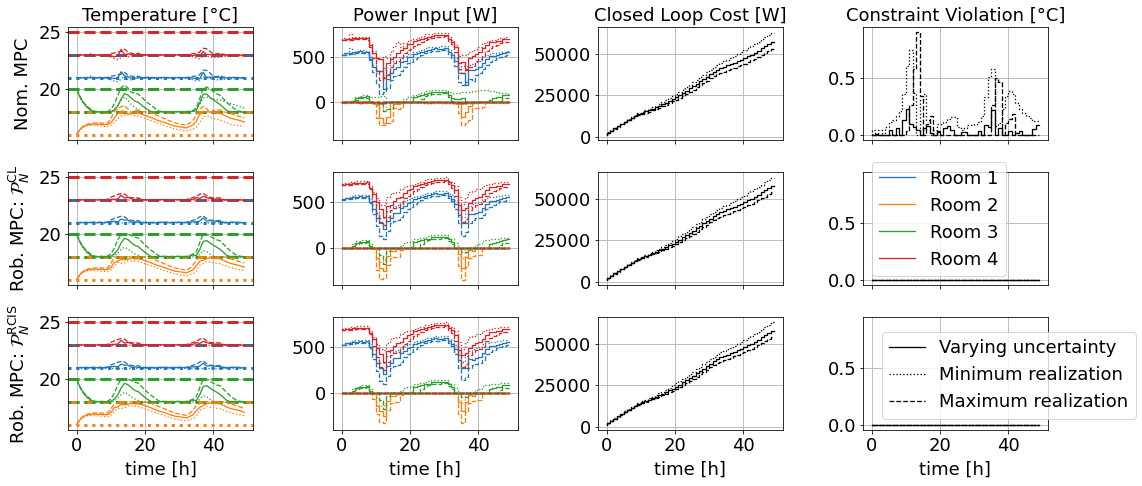

In [143]:
scale=1
fig, ax = plt.subplots(3,4, sharex=True,sharey='col',figsize=(scale*16,scale*7))
for i in range(3):
    ax[i,0].axhline(lb_x[0],color='tab:blue',linestyle=':')
    ax[i,0].axhline(ub_x[0],color='tab:blue',linestyle='--')
    ax[i,0].axhline(lb_x[1],color='tab:orange',linestyle=':')
    ax[i,0].axhline(ub_x[1],color='tab:orange',linestyle='--')
    ax[i,0].axhline(lb_x[2],color='tab:green',linestyle=':')
    ax[i,0].axhline(ub_x[2],color='tab:green',linestyle='--')
    ax[i,0].axhline(lb_x[3],color='tab:red',linestyle=':')
    ax[i,0].axhline(ub_x[3],color='tab:red',linestyle='--')

style=['-',':','--']
label_style=['Varying uncertainty','Minimum realization', 'Maximum realization']
label_color=['Room 1','Room 2','Room 3', 'Room 4']
widht=1.3
# plot for min
k=0
for plot in dat:
    # For nominal MPC
    ax[0,0].plot(plot['MPC'][0]['_time'],plot['MPC'][0]['_x','T_r'],linewidth=widht,linestyle=style[k])
    ax[0,1].step(plot['MPC'][0]['_time'],plot['MPC'][0]['_u','u_heat'],linewidth=widht,linestyle=style[k])
    ax[0,1].set_prop_cycle(None)
    ax[0,1].step(plot['MPC'][0]['_time'],-plot['MPC'][0]['_u','u_cool'],linewidth=widht,linestyle=style[k])
    ax[0,2].step(plot['MPC'][0]['_time'],plot['MPC'][1],linewidth=widht,linestyle=style[k],color='black')
    ax[0,3].step(plot['MPC'][0]['_time'],plot['MPC'][2],linewidth=widht,linestyle=style[k],color='black')
    # For Hyperrectangle Cutting and Bonding
    if k==0:
        ax[1,0].plot(plot['HCB'][0]['_time'],plot['HCB'][0]['_x','T_r'],linewidth=widht,linestyle=style[k])
    else:
        ax[1,0].plot(plot['HCB'][0]['_time'],plot['HCB'][0]['_x','T_r'],linewidth=widht,linestyle=style[k])
    ax[1,1].step(plot['HCB'][0]['_time'],plot['HCB'][0]['_u','u_heat'],linewidth=widht,linestyle=style[k])
    ax[1,1].set_prop_cycle(None)
    ax[1,1].step(plot['HCB'][0]['_time'],-plot['HCB'][0]['_u','u_cool'],linewidth=widht,linestyle=style[k])
    ax[1,2].step(plot['HCB'][0]['_time'],plot['HCB'][1],linewidth=widht,linestyle=style[k],color='black')
    ax[1,3].step(plot['HCB'][0]['_time'],plot['HCB'][2],linewidth=widht,linestyle=style[k],color='black')
    # For Multi-Stage
    ax[2,0].plot(plot['MS-MPC'][0]['_time'],plot['MS-MPC'][0]['_x','T_r'],linewidth=widht,linestyle=style[k])
    ax[2,1].step(plot['MS-MPC'][0]['_time'],plot['MS-MPC'][0]['_u','u_heat'],linewidth=widht,linestyle=style[k])
    ax[2,1].set_prop_cycle(None)
    ax[2,1].step(plot['MS-MPC'][0]['_time'],-plot['MS-MPC'][0]['_u','u_cool'],linewidth=widht,linestyle=style[k])
    ax[2,2].step(plot['MS-MPC'][0]['_time'],plot['MS-MPC'][1],linewidth=widht,linestyle=style[k],color='black')
    ax[2,3].step(plot['MS-MPC'][0]['_time'],plot['MS-MPC'][2],linewidth=widht,linestyle=style[k],color='black',label=label_style[k])
    for i in range(3):
        for j in range(4):
            ax[i,j].set_prop_cycle(None)
    k+=1

for i in range(4):
    ax[1,3].plot(0,0,linewidth=widht,linestyle=style[0],label=label_color[i])
# Set labels
ax[0,0].set_ylabel('Nom. MPC')
ax[1,0].set_ylabel('Rob. MPC: $\mathcal{P}_N^{\mathrm{CL}}$')
ax[2,0].set_ylabel('Rob. MPC: $\mathcal{P}_N^{\mathrm{RCIS}}$')
ax[0,0].title.set_text('Temperature [°C]')
ax[0,1].title.set_text('Power Input [W]')
ax[0,2].title.set_text('Closed Loop Cost [W]')
ax[0,3].title.set_text('Constraint Violation [°C]')

ax[-1,0].set_xlabel('time [h]')
ax[-1,1].set_xlabel('time [h]')
ax[-1,2].set_xlabel('time [h]')
ax[-1,3].set_xlabel('time [h]')
ax[2,3].legend(loc=[0.1,0.1])
ax[1,3].legend()
#fig.legend()
fig.tight_layout()
fig.align_labels()

In [144]:
fig.savefig('4rooms_34.pdf')

Compute the mean computation times per MPC iteration

In [138]:
t_mean=np.zeros((3,1))
for i in range(len(plot)):
    t_mean[0]+=dat[i]['MPC'][-1]
    t_mean[1]+=dat[i]['HCB'][-1]
    t_mean[2]+=dat[i]['MS-MPC'][-1]
t_mean/=(len(plot)*N_sim)
print(t_mean)

[[ 0.0399306 ]
 [16.32188937]
 [ 0.04103337]]
